# RTED-TDS Co-Sim

Authored by [Jinning Wang](https://scholar.google.com/citations?user=Wr7nQZAAAAAJ&hl=en&oi=ao), recently updated on 06/06/2022.

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented with an equation defined PI controller.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted2`` has attributes ``mdl`` which is a gurobipy model.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance
- ``sse`` EV aggregator

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, matplotlib, scipy

## Import case

In [1]:
%run -i 'cosim_import.py'

0.post4530.dev0+g4b3d19a
2.8.0


`caseH` is the start time [H] of the co-simulation, now 10 and 18 are supported.

In [2]:
caseH = 18
ict = True
ecc = True

%run -i 'cosim_setup_andes.py'

EVA: ts=18[H], 50000 EVs, Total Q=434.54 MWh
Online 14477, Q=362.27 MWh, SoC=0.7435
Power(MW): Pt=-39.0266, Pc=-39.0266, Pd=-0.0
Ctrl: 0=7897; 1=6580; 
EVA: Load A from Aest.csv.
Working directory: "/Users/jinningwang/Documents/work/andes/jwang/notes"
> Loaded config from file "/Users/jinningwang/.andes/andes.rc"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 8 processes.


Saved generated pycode to "/Users/jinningwang/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.3226 seconds.
Parsing input file "/Users/jinningwang/Documents/work/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.1576 seconds.
System internal structure set up in 0.0609 seconds.


## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


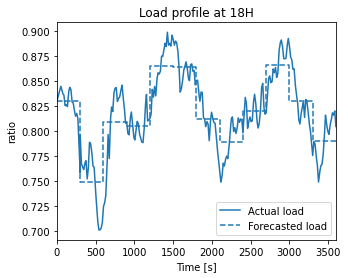

In [3]:
%run -i 'cosim_loadsyn.py'

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [4]:
%run -i 'cosim_setup_dispatch.py'
dc_comp.round(4)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.1600 seconds.
0: |F(x)| = 9.101680411
1: |F(x)| = 3.497456331
2: |F(x)| = 0.1830766282
3: |F(x)| = 0.000718302703
4: |F(x)| = 1.659287907e-08
Converged in 5 iterations in 0.0130 seconds.
Power flow results are consistent. Conversion is successful.


Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-08


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0106 seconds.
0: |F(x)| = 9.101680411
1: |F(x)| = 3.497456331
2: |F(x)| = 0.1830766282
3: |F(x)| = 0.000718302703
4: |F(x)| = 1.659287907e-08
Converged in 5 iterations in 0.0133 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED limited: sfru, sfrd
RTED: total cost=4889.131


pp cost=2184.5741560778906, gb cost=4889.131241556355


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,970.0313,39.9756,15.8831,1.0,970.0312
1,646.0000,228.9208,2.2281,1.0,646.0000
2,290.0000,81.0987,-0.8653,1.0,290.0000
3,652.0000,114.2245,7.2985,1.0,652.0000
4,508.0000,137.9576,5.4672,1.0,508.0000
5,646.6875,212.0871,6.4196,1.0,646.6875
6,232.0000,55.2884,3.4379,1.0,232.0000
7,564.0000,-59.8950,13.9534,1.0,564.0000
8,865.0000,49.8766,18.9462,1.0,865.0000
9,30.0000,49.8766,18.9462,1.0,30.0000


## Prepare

### Make link table

In [5]:
%run -i 'cosim_linktable.py'
ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,rg_idx,rexc_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,False,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,False,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,False,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,False,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,False,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,False,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,False,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,False,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,False,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,False,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

In [6]:
# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 3600

rru, rrd, rsfr = 1.0, 1.0, 0.05

# Define functions and constants used in loop
%run -i 'cosim_const.py'

Check convergence

In [7]:
# %run -i 'cosim_bmain.py'

Loop

In [8]:
%run -i 'cosim_main.py'

RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED is solved.
RTED: total cost=4703.808
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0074 seconds.
0: |F(x)| = 7.905038032
1: |F(x)| = 3.450481617
2: |F(x)| = 0.1825587949
3: |F(x)| = 0.00114240321
4: |F(x)| = 3.253570791e-08
Converged in 5 iterations in 0.0159 seconds.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initialization for 

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=4.00 sec completed in 0.0638 seconds.
Simulation to t=5.00 sec completed in 0.0558 seconds.
Simulation to t=6.00 sec completed in 0.0488 seconds.
Simulation to t=7.00 sec completed in 0.0485 seconds.


       c  lc    p        pv   pu    na   nam
7855  -1   1  1.0  0.178813  0.0  3541  3541
8684  -1   1  1.0  0.178813  0.0  3891  3891
9735  -1   1  1.0  0.178813  0.0  3412  3412
12141 -1   1  1.0  0.178813  0.0  3453  3453
15628 -1   1  1.0  0.178813  0.0  2793  2793


Simulation to t=8.00 sec completed in 0.0513 seconds.
Simulation to t=9.00 sec completed in 0.0539 seconds.
Simulation to t=10.00 sec completed in 0.0781 seconds.
Simulation to t=11.00 sec completed in 0.0471 seconds.


       c  lc    p        pv   pu    na   nam
11583 -1   1  1.0  0.423916  0.0  3531  3531


Simulation to t=12.00 sec completed in 0.0534 seconds.
Simulation to t=13.00 sec completed in 0.0635 seconds.
Simulation to t=14.00 sec completed in 0.0657 seconds.
Simulation to t=15.00 sec completed in 0.0489 seconds.


       c  lc    p      pv   pu    na   nam
17260 -1   1  1.0  0.6001  0.0  3350  3350


Simulation to t=16.00 sec completed in 0.0514 seconds.
Simulation to t=17.00 sec completed in 0.0525 seconds.
Simulation to t=18.00 sec completed in 0.0623 seconds.
Simulation to t=19.00 sec completed in 0.0478 seconds.


      c  lc    p   pv   pu    na   nam
1604 -1   1  1.0  1.0  0.0  3190  3190
2298 -1   1  1.0  1.0  0.0  3256  3256
8920 -1   1  1.0  1.0  0.0  3766  3766


Simulation to t=20.00 sec completed in 0.0464 seconds.
Simulation to t=21.00 sec completed in 0.0624 seconds.
Simulation to t=22.00 sec completed in 0.0561 seconds.
Simulation to t=23.00 sec completed in 0.0602 seconds.


      c  lc    p   pv   pu    na   nam
31   -1   1  1.0  0.0  0.0  3692  3692
3228 -1   1  1.0  0.0  0.0  2886  2886
4810 -1   1  1.0  0.0  0.0  3858  3858
7706 -1   1  1.0  0.0  0.0  2657  2657


Simulation to t=24.00 sec completed in 0.0563 seconds.
Simulation to t=25.00 sec completed in 0.0483 seconds.
Simulation to t=26.00 sec completed in 0.0571 seconds.
Simulation to t=27.00 sec completed in 0.0489 seconds.


       c  lc    p        pv   pu    na   nam
10982 -1   1  1.0  0.000000  0.0  3150  3150
11481 -1   1  1.0  0.722332  0.0  3451  3451
12649 -1   1  1.0  0.000000  0.0  2891  2891


Simulation to t=28.00 sec completed in 0.0622 seconds.
Simulation to t=29.00 sec completed in 0.0510 seconds.
Simulation to t=30.00 sec completed in 0.0683 seconds.
Simulation to t=31.00 sec completed in 0.0606 seconds.


       c  lc    p   pv   pu    na   nam
1161  -1   1  1.0  1.0  0.0  2797  2797
5837  -1   1  1.0  0.0  0.0  3874  3874
7079  -1   1  1.0  1.0  0.0  3690  3690
9531  -1   1  1.0  0.0  0.0  3544  3544
10991 -1   1  1.0  1.0  0.0  3212  3212
15323 -1   1  1.0  0.0  0.0  4006  4006
15627 -1   1  1.0  0.0  0.0  3177  3177


Simulation to t=32.00 sec completed in 0.0521 seconds.
Simulation to t=33.00 sec completed in 0.0527 seconds.
Simulation to t=34.00 sec completed in 0.0503 seconds.
Simulation to t=35.00 sec completed in 0.0676 seconds.


       c  lc    p   pv   pu    na   nam
5554  -1   1  1.0  0.0  0.0  3813  3813
8227  -1   1  1.0  0.0  0.0  2839  2839
14723 -1   1  1.0  0.0  0.0  3185  3185


Simulation to t=36.00 sec completed in 0.0539 seconds.
Simulation to t=37.00 sec completed in 0.0566 seconds.
Simulation to t=38.00 sec completed in 0.0543 seconds.
Simulation to t=39.00 sec completed in 0.0601 seconds.


       c  lc    p   pv   pu    na   nam
443   -1   1  1.0  0.0  0.0  3309  3309
6979  -1   1  1.0  0.0  0.0  3955  3955
12598 -1   1  1.0  0.0  0.0  3761  3761


Simulation to t=40.00 sec completed in 0.0746 seconds.
Simulation to t=41.00 sec completed in 0.0584 seconds.
Simulation to t=42.00 sec completed in 0.0516 seconds.
Simulation to t=43.00 sec completed in 0.0722 seconds.


       c  lc    p   pv   pu    na   nam
1953  -1   1  1.0  0.0  0.0  3176  3176
6726  -1   1  1.0  0.0  0.0  2640  2640
8824  -1   1  1.0  0.0  0.0  3208  3208
16330 -1   1  1.0  0.0  0.0  2424  2424


Simulation to t=44.00 sec completed in 0.0522 seconds.
Simulation to t=45.00 sec completed in 0.0602 seconds.
Simulation to t=46.00 sec completed in 0.0645 seconds.
Simulation to t=47.00 sec completed in 0.0457 seconds.


      c  lc    p   pv   pu    na   nam
4907 -1   1  1.0  0.0  0.0  3844  3844
5830 -1   1  1.0  0.0  0.0  3637  3637
7994 -1   1  1.0  0.0  0.0  3441  3441


Simulation to t=48.00 sec completed in 0.0555 seconds.
Simulation to t=49.00 sec completed in 0.0590 seconds.
Simulation to t=50.00 sec completed in 0.0591 seconds.
Simulation to t=51.00 sec completed in 0.0528 seconds.


       c  lc    p   pv   pu    na   nam
3309  -1   1  1.0  0.0  0.0  3449  3449
6401  -1   1  1.0  0.0  0.0  3158  3158
13616 -1   1  1.0  0.0  0.0  4185  4185


Simulation to t=52.00 sec completed in 0.0525 seconds.
Simulation to t=53.00 sec completed in 0.0566 seconds.
Simulation to t=54.00 sec completed in 0.0755 seconds.
Simulation to t=55.00 sec completed in 0.0601 seconds.
Simulation to t=56.00 sec completed in 0.1162 seconds.
Simulation to t=57.00 sec completed in 0.0497 seconds.
Simulation to t=58.00 sec completed in 0.0701 seconds.
Simulation to t=59.00 sec completed in 0.0681 seconds.
Simulation to t=60.00 sec completed in 0.0598 seconds.
Simulation to t=61.00 sec completed in 0.0485 seconds.
Simulation to t=62.00 sec completed in 0.0602 seconds.
Simulation to t=63.00 sec completed in 0.0470 seconds.
Simulation to t=64.00 sec completed in 0.0495 seconds.
Simulation to t=65.00 sec completed in 0.0594 seconds.
Simulation to t=66.00 sec completed in 0.0532 seconds.
Simulation to t=67.00 sec completed in 0.0540 seconds.
Simulation to t=68.00 sec completed in 0.0530 seconds.
Simulation to t=69.00 sec completed in 0.0716 seconds.
Simulation

       c  lc    p   pv   pu    na   nam
1177  -1   1  1.0  0.0  0.0  3699  3699
3720  -1   1  1.0  0.0  0.0  3250  3250
4424  -1   1  1.0  0.0  0.0  3058  3058
8161  -1   1  1.0  0.0  0.0  3128  3128
12015 -1   1  1.0  0.0  0.0  2907  2907
13658 -1   1  1.0  0.0  0.0  3522  3522


Simulation to t=84.00 sec completed in 0.0518 seconds.
Simulation to t=85.00 sec completed in 0.0640 seconds.
Simulation to t=86.00 sec completed in 0.0767 seconds.
Simulation to t=87.00 sec completed in 0.0714 seconds.
Simulation to t=88.00 sec completed in 0.0574 seconds.
Simulation to t=89.00 sec completed in 0.0545 seconds.
Simulation to t=90.00 sec completed in 0.0507 seconds.
Simulation to t=91.00 sec completed in 0.0528 seconds.
Simulation to t=92.00 sec completed in 0.0580 seconds.
Simulation to t=93.00 sec completed in 0.0520 seconds.
Simulation to t=94.00 sec completed in 0.0543 seconds.
Simulation to t=95.00 sec completed in 0.0489 seconds.
Simulation to t=96.00 sec completed in 0.0500 seconds.
Simulation to t=97.00 sec completed in 0.0553 seconds.
Simulation to t=98.00 sec completed in 0.0492 seconds.
Simulation to t=99.00 sec completed in 0.0566 seconds.
Simulation to t=100.00 sec completed in 0.0663 seconds.
Simulation to t=101.00 sec completed in 0.0520 seconds.
Simulati

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=108.00 sec completed in 0.0632 seconds.
Simulation to t=109.00 sec completed in 0.0506 seconds.
Simulation to t=110.00 sec completed in 0.0684 seconds.
Simulation to t=111.00 sec completed in 0.0516 seconds.
Simulation to t=112.00 sec completed in 0.0612 seconds.
Simulation to t=113.00 sec completed in 0.0851 seconds.
Simulation to t=114.00 sec completed in 0.0531 seconds.
Simulation to t=115.00 sec completed in 0.0728 seconds.
Simulation to t=116.00 sec completed in 0.0507 seconds.
Simulation to t=117.00 sec completed in 0.0500 seconds.
Simulation to t=118.00 sec completed in 0.0696 seconds.
Simulation to t=119.00 sec completed in 0.0514 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=120.00 sec completed in 0.0564 seconds.
Simulation to t=121.00 sec completed in 0.0599 seconds.
Simulation to t=122.00 sec completed in 0.0824 seconds.
Simulation to t=123.00 sec completed in 0.0518 seconds.
Simulation to t=124.00 sec completed in 0.0522 seconds.
Simulation to t=125.00 sec completed in 0.0692 seconds.
Simulation to t=126.00 sec completed in 0.0579 seconds.
Simulation to t=127.00 sec completed in 0.0523 seconds.
Simulation to t=128.00 sec completed in 0.0551 seconds.
Simulation to t=129.00 sec completed in 0.0531 seconds.
Simulation to t=130.00 sec completed in 0.0550 seconds.
Simulation to t=131.00 sec completed in 0.0510 seconds.
Simulation to t=132.00 sec completed in 0.0630 seconds.
Simulation to t=133.00 sec completed in 0.0536 seconds.
Simulation to t=134.00 sec completed in 0.0525 seconds.
Simulation to t=135.00 sec completed in 0.0763 seconds.
Simulation to t=136.00 sec completed in 0.0491 seconds.
Simulation to t=137.00 sec completed in 0.1407 s

      c  lc    p        pv   pu    na   nam
511  -1   1  1.0  0.185962  0.0  3510  3510
1505 -1   1  1.0  0.185962  0.0  3332  3332


Simulation to t=140.00 sec completed in 0.0482 seconds.
Simulation to t=141.00 sec completed in 0.0530 seconds.
Simulation to t=142.00 sec completed in 0.0715 seconds.
Simulation to t=143.00 sec completed in 0.0528 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=144.00 sec completed in 0.0521 seconds.
Simulation to t=145.00 sec completed in 0.0610 seconds.
Simulation to t=146.00 sec completed in 0.0598 seconds.
Simulation to t=147.00 sec completed in 0.1706 seconds.


      c  lc    p   pv   pu    na   nam
3379 -1   1  1.0  0.0  0.0  3909  3909
8721 -1   1  1.0  0.0  0.0  3578  3578


Simulation to t=148.00 sec completed in 0.0471 seconds.
Simulation to t=149.00 sec completed in 0.0523 seconds.
Simulation to t=150.00 sec completed in 0.0536 seconds.
Simulation to t=151.00 sec completed in 0.0664 seconds.


       c  lc    p   pv   pu    na   nam
1336  -1   1  1.0  0.0  0.0  3455  3455
1409  -1   1  1.0  0.0  0.0  3206  3206
8170  -1   1  1.0  0.0  0.0  2826  2826
9872  -1   1  1.0  0.0  0.0  3812  3812
10243 -1   1  1.0  0.0  0.0  3063  3063
11164 -1   1  1.0  0.0  0.0  3266  3266
14171 -1   1  1.0  0.0  0.0  2978  2978


Simulation to t=152.00 sec completed in 0.0587 seconds.
Simulation to t=153.00 sec completed in 0.0596 seconds.
Simulation to t=154.00 sec completed in 0.0668 seconds.
Simulation to t=155.00 sec completed in 0.1025 seconds.


       c  lc    p   pv   pu    na   nam
1014  -1   1  1.0  0.0  0.0  3356  3356
4166  -1   1  1.0  0.0  0.0  3449  3449
10198 -1   1  1.0  0.0  0.0  3194  3194
10309 -1   1  1.0  0.0  0.0  3392  3392
11531 -1   1  1.0  0.0  0.0  3025  3025


Simulation to t=156.00 sec completed in 0.0684 seconds.
Simulation to t=157.00 sec completed in 0.0631 seconds.
Simulation to t=158.00 sec completed in 0.0639 seconds.
Simulation to t=159.00 sec completed in 0.0533 seconds.
Simulation to t=160.00 sec completed in 0.0623 seconds.
Simulation to t=161.00 sec completed in 0.0541 seconds.
Simulation to t=162.00 sec completed in 0.0579 seconds.
Simulation to t=163.00 sec completed in 0.0589 seconds.


       c  lc    p   pv   pu    na   nam
1881  -1   1  1.0  0.0  1.0  3107  3107
9761  -1   1  1.0  0.0  0.0  3136  3136
16032 -1   1  1.0  0.0  1.0  2867  2867
16781 -1   1  1.0  0.0  1.0  3678  3678


Simulation to t=164.00 sec completed in 0.0661 seconds.
Simulation to t=165.00 sec completed in 0.0579 seconds.
Simulation to t=166.00 sec completed in 0.0571 seconds.
Simulation to t=167.00 sec completed in 0.0545 seconds.


       c  lc    p   pv   pu    na   nam
874   -1   1  1.0  0.0  0.0  2904  2904
10220 -1   1  1.0  1.0  0.0  2766  2766
11066 -1   1  1.0  1.0  0.0  3517  3517
11228 -1   1  1.0  0.0  0.0  3379  3379
12942 -1   1  1.0  1.0  0.0  2834  2834
15745 -1   1  1.0  1.0  0.0  3305  3305


Simulation to t=168.00 sec completed in 0.0691 seconds.
Simulation to t=169.00 sec completed in 0.0548 seconds.
Simulation to t=170.00 sec completed in 0.0638 seconds.
Simulation to t=171.00 sec completed in 0.0725 seconds.


       c  lc    p   pv   pu    na   nam
14648 -1   1  1.0  0.0  0.0  3671  3671


Simulation to t=172.00 sec completed in 0.0547 seconds.
Simulation to t=173.00 sec completed in 0.0652 seconds.
Simulation to t=174.00 sec completed in 0.0526 seconds.
Simulation to t=175.00 sec completed in 0.0676 seconds.


       c  lc    p   pv   pu    na   nam
3296  -1   1  1.0  0.0  0.0  2880  2880
5628  -1   1  1.0  0.0  0.0  2832  2832
6582  -1   1  1.0  0.0  0.0  3471  3471
15020 -1   1  1.0  0.0  0.0  3653  3653
15930 -1   1  1.0  0.0  0.0  3949  3949


Simulation to t=176.00 sec completed in 0.0513 seconds.
Simulation to t=177.00 sec completed in 0.0609 seconds.
Simulation to t=178.00 sec completed in 0.0546 seconds.
Simulation to t=179.00 sec completed in 0.0579 seconds.
Simulation to t=180.00 sec completed in 0.0538 seconds.
Simulation to t=181.00 sec completed in 0.0694 seconds.
Simulation to t=182.00 sec completed in 0.0547 seconds.
Simulation to t=183.00 sec completed in 0.0675 seconds.
Simulation to t=184.00 sec completed in 0.0568 seconds.
Simulation to t=185.00 sec completed in 0.0657 seconds.
Simulation to t=186.00 sec completed in 0.0540 seconds.
Simulation to t=187.00 sec completed in 0.0646 seconds.
Simulation to t=188.00 sec completed in 0.0550 seconds.
Simulation to t=189.00 sec completed in 0.0605 seconds.
Simulation to t=190.00 sec completed in 0.0529 seconds.
Simulation to t=191.00 sec completed in 0.0619 seconds.
Simulation to t=192.00 sec completed in 0.0619 seconds.
Simulation to t=193.00 sec completed in 0.0766 s

       c  lc    p   pv   pu    na   nam
3227  -1   1  1.0  0.0  0.0  4009  4009
6536  -1   1  1.0  0.0  0.0  3030  3030
7827  -1   1  1.0  0.0  0.0  2941  2941
12067 -1   1  1.0  0.0  0.0  3507  3507
12397 -1   1  1.0  0.0  0.0  3417  3417
12557 -1   1  1.0  0.0  0.0  3593  3593
14031 -1   1  1.0  0.0  0.0  3667  3667


Simulation to t=200.00 sec completed in 0.0653 seconds.
Simulation to t=201.00 sec completed in 0.0616 seconds.
Simulation to t=202.00 sec completed in 0.0668 seconds.
Simulation to t=203.00 sec completed in 0.0546 seconds.
Simulation to t=204.00 sec completed in 0.0565 seconds.
Simulation to t=205.00 sec completed in 0.0670 seconds.
Simulation to t=206.00 sec completed in 0.0538 seconds.
Simulation to t=207.00 sec completed in 0.0607 seconds.
Simulation to t=208.00 sec completed in 0.0629 seconds.
Simulation to t=209.00 sec completed in 0.0679 seconds.
Simulation to t=210.00 sec completed in 0.0613 seconds.
Simulation to t=211.00 sec completed in 0.0632 seconds.
Simulation to t=212.00 sec completed in 0.0579 seconds.
Simulation to t=213.00 sec completed in 0.0535 seconds.
Simulation to t=214.00 sec completed in 0.0500 seconds.
Simulation to t=215.00 sec completed in 0.0631 seconds.
Simulation to t=216.00 sec completed in 0.0570 seconds.
Simulation to t=217.00 sec completed in 0.0607 s

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=224.00 sec completed in 0.0565 seconds.
Simulation to t=225.00 sec completed in 0.0749 seconds.
Simulation to t=226.00 sec completed in 0.0672 seconds.
Simulation to t=227.00 sec completed in 0.0507 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=228.00 sec completed in 0.0627 seconds.
Simulation to t=229.00 sec completed in 0.1005 seconds.
Simulation to t=230.00 sec completed in 0.0698 seconds.
Simulation to t=231.00 sec completed in 0.0785 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=232.00 sec completed in 0.0630 seconds.
Simulation to t=233.00 sec completed in 0.0634 seconds.
Simulation to t=234.00 sec completed in 0.0576 seconds.
Simulation to t=235.00 sec completed in 0.0849 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=236.00 sec completed in 0.0915 seconds.
Simulation to t=237.00 sec completed in 0.0906 seconds.
Simulation to t=238.00 sec completed in 0.0724 seconds.
Simulation to t=239.00 sec completed in 0.0725 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=240.00 sec completed in 0.1115 seconds.
Simulation to t=241.00 sec completed in 0.0840 seconds.
Simulation to t=242.00 sec completed in 0.0936 seconds.
Simulation to t=243.00 sec completed in 0.0805 seconds.


      c  lc    p        pv   pu    na   nam
3620 -1   1  1.0  0.035159  0.0  3610  3610


Simulation to t=244.00 sec completed in 0.0706 seconds.
Simulation to t=245.00 sec completed in 0.0719 seconds.
Simulation to t=246.00 sec completed in 0.0676 seconds.
Simulation to t=247.00 sec completed in 0.0693 seconds.
Simulation to t=248.00 sec completed in 0.0819 seconds.
Simulation to t=249.00 sec completed in 0.1239 seconds.
Simulation to t=250.00 sec completed in 0.1372 seconds.
Simulation to t=251.00 sec completed in 0.1171 seconds.


       c  lc    p        pv   pu    na   nam
12233 -1   1  1.0  0.125259  0.0  3218  3218
15728 -1   1  1.0  0.125259  0.0  3511  3511
16957 -1   1  1.0  0.125259  0.0  2341  2341


Simulation to t=252.00 sec completed in 0.1029 seconds.
Simulation to t=253.00 sec completed in 0.0546 seconds.
Simulation to t=254.00 sec completed in 0.0583 seconds.
Simulation to t=255.00 sec completed in 0.0583 seconds.


       c  lc    p        pv   pu    na   nam
716   -1   1  1.0  0.177839  0.0  3565  3565
5484  -1   1  1.0  0.177839  0.0  3826  3826
6646  -1   1  1.0  0.177839  0.0  2842  2842
8837  -1   1  1.0  0.177839  0.0  3615  3615
11130 -1   1  1.0  0.177839  0.0  3254  3254
12544 -1   1  1.0  0.177839  0.0  2983  2983


Simulation to t=256.00 sec completed in 0.2410 seconds.
Simulation to t=257.00 sec completed in 0.1601 seconds.
Simulation to t=258.00 sec completed in 0.1004 seconds.
Simulation to t=259.00 sec completed in 0.1030 seconds.
Simulation to t=260.00 sec completed in 0.1033 seconds.
Simulation to t=261.00 sec completed in 0.1956 seconds.
Simulation to t=262.00 sec completed in 0.0579 seconds.
Simulation to t=263.00 sec completed in 0.0649 seconds.
Simulation to t=264.00 sec completed in 0.0610 seconds.
Simulation to t=265.00 sec completed in 0.0636 seconds.
Simulation to t=266.00 sec completed in 0.0745 seconds.
Simulation to t=267.00 sec completed in 0.0517 seconds.
Simulation to t=268.00 sec completed in 0.1888 seconds.
Simulation to t=269.00 sec completed in 0.1002 seconds.
Simulation to t=270.00 sec completed in 0.0778 seconds.
Simulation to t=271.00 sec completed in 0.0864 seconds.
Simulation to t=272.00 sec completed in 0.1218 seconds.
Simulation to t=273.00 sec completed in 0.1079 s

      c  lc    p        pv   pu    na   nam
9156 -1   1  1.0  0.944009  1.0  2838  2838


Simulation to t=280.00 sec completed in 0.1087 seconds.
Simulation to t=281.00 sec completed in 0.0691 seconds.
Simulation to t=282.00 sec completed in 0.0797 seconds.
Simulation to t=283.00 sec completed in 0.0748 seconds.
Simulation to t=284.00 sec completed in 0.0748 seconds.
Simulation to t=285.00 sec completed in 0.1070 seconds.
Simulation to t=286.00 sec completed in 0.0883 seconds.
Simulation to t=287.00 sec completed in 0.1368 seconds.
Simulation to t=288.00 sec completed in 0.1060 seconds.
Simulation to t=289.00 sec completed in 0.0865 seconds.
Simulation to t=290.00 sec completed in 0.0812 seconds.
Simulation to t=291.00 sec completed in 0.0789 seconds.


       c  lc    p   pv        pu    na   nam
4608  -1   1  1.0  0.0  0.728673  3455  3455
12830 -1   1  1.0  0.0  0.728673  3188  3188


Simulation to t=292.00 sec completed in 0.0914 seconds.
Simulation to t=293.00 sec completed in 0.0900 seconds.
Simulation to t=294.00 sec completed in 0.0796 seconds.
Simulation to t=295.00 sec completed in 0.0857 seconds.
Simulation to t=296.00 sec completed in 0.0857 seconds.
Simulation to t=297.00 sec completed in 0.0985 seconds.
Simulation to t=298.00 sec completed in 0.0725 seconds.
Simulation to t=299.00 sec completed in 0.0724 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4619.224


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=300.00 sec completed in 0.1231 seconds.
Simulation to t=301.00 sec completed in 0.1063 seconds.
Simulation to t=302.00 sec completed in 0.0977 seconds.
Simulation to t=303.00 sec completed in 0.1044 seconds.
Simulation to t=304.00 sec completed in 0.0812 seconds.
Simulation to t=305.00 sec completed in 0.0623 seconds.
Simulation to t=306.00 sec completed in 0.0667 seconds.
Simulation to t=307.00 sec completed in 0.0948 seconds.
Simulation to t=308.00 sec completed in 0.0741 seconds.
Simulation to t=309.00 sec completed in 0.0695 seconds.
Simulation to t=310.00 sec completed in 0.0815 seconds.
Simulation to t=311.00 sec completed in 0.0883 seconds.
Simulation to t=312.00 sec completed in 0.0894 seconds.
Simulation to t=313.00 sec completed in 0.0891 seconds.
Simulation to t=314.00 sec completed in 0.0757 seconds.
Simulation to t=315.00 sec completed in 0.0765 seconds.
Simulation to t=316.00 sec completed in 0.0978 seconds.
Simulation to t=317.00 sec completed in 0.0766 s

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=320.00 sec completed in 0.1014 seconds.
Simulation to t=321.00 sec completed in 0.1069 seconds.
Simulation to t=322.00 sec completed in 0.0641 seconds.
Simulation to t=323.00 sec completed in 0.0877 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=324.00 sec completed in 0.1235 seconds.
Simulation to t=325.00 sec completed in 0.0834 seconds.
Simulation to t=326.00 sec completed in 0.0876 seconds.
Simulation to t=327.00 sec completed in 0.0684 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=328.00 sec completed in 0.0712 seconds.
Simulation to t=329.00 sec completed in 0.0965 seconds.
Simulation to t=330.00 sec completed in 0.0829 seconds.
Simulation to t=331.00 sec completed in 0.0686 seconds.


      c  lc    p        pv   pu    na   nam
6957 -1   1  1.0  0.018857  0.0  3087  3087


Simulation to t=332.00 sec completed in 0.0804 seconds.
Simulation to t=333.00 sec completed in 0.0806 seconds.
Simulation to t=334.00 sec completed in 0.0801 seconds.
Simulation to t=335.00 sec completed in 0.0812 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=336.00 sec completed in 0.0724 seconds.
Simulation to t=337.00 sec completed in 0.0716 seconds.
Simulation to t=338.00 sec completed in 0.0659 seconds.
Simulation to t=339.00 sec completed in 0.0583 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=340.00 sec completed in 0.0477 seconds.
Simulation to t=341.00 sec completed in 0.0525 seconds.
Simulation to t=342.00 sec completed in 0.0465 seconds.
Simulation to t=343.00 sec completed in 0.0537 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=344.00 sec completed in 0.0525 seconds.
Simulation to t=345.00 sec completed in 0.0670 seconds.
Simulation to t=346.00 sec completed in 0.0603 seconds.
Simulation to t=347.00 sec completed in 0.0598 seconds.


     c  lc    p        pv   pu    na   nam
987 -1   1  1.0  0.388882  0.0  3648  3648


Simulation to t=348.00 sec completed in 0.0780 seconds.
Simulation to t=349.00 sec completed in 0.0690 seconds.
Simulation to t=350.00 sec completed in 0.1276 seconds.
Simulation to t=351.00 sec completed in 0.0762 seconds.


      c  lc    p   pv   pu    na   nam
1098 -1   1  1.0  1.0  0.0  3137  3137
7131 -1   1  1.0  1.0  0.0  2768  2768


Simulation to t=352.00 sec completed in 0.0896 seconds.
Simulation to t=353.00 sec completed in 0.0949 seconds.
Simulation to t=354.00 sec completed in 0.0837 seconds.
Simulation to t=355.00 sec completed in 0.0619 seconds.


       c  lc    p   pv   pu    na   nam
1334  -1   1  1.0  0.0  0.0  3880  3880
2329  -1   1  1.0  0.0  0.0  3461  3461
2366  -1   1  1.0  0.0  0.0  3292  3292
2767  -1   1  1.0  1.0  0.0  2964  2964
11771 -1   1  1.0  0.0  0.0  3893  3893


Simulation to t=356.00 sec completed in 0.0794 seconds.
Simulation to t=357.00 sec completed in 0.0778 seconds.
Simulation to t=358.00 sec completed in 0.0708 seconds.
Simulation to t=359.00 sec completed in 0.0719 seconds.


      c  lc    p   pv   pu    na   nam
205  -1   1  1.0  0.0  0.0  3705  3705
1660 -1   1  1.0  0.0  0.0  3309  3309
2646 -1   1  1.0  0.0  0.0  3998  3998


Simulation to t=360.00 sec completed in 0.0992 seconds.
Simulation to t=361.00 sec completed in 0.0702 seconds.
Simulation to t=362.00 sec completed in 0.0918 seconds.
Simulation to t=363.00 sec completed in 0.0746 seconds.


       c  lc    p   pv   pu    na   nam
829   -1   1  1.0  0.0  0.0  3539  3539
13928 -1   1  1.0  0.0  0.0  3578  3578


Simulation to t=364.00 sec completed in 0.0812 seconds.
Simulation to t=365.00 sec completed in 0.0891 seconds.
Simulation to t=366.00 sec completed in 0.1049 seconds.
Simulation to t=367.00 sec completed in 0.0733 seconds.


       c  lc    p   pv   pu    na   nam
16873 -1   1  1.0  0.0  0.0  3550  3550


Simulation to t=368.00 sec completed in 0.0876 seconds.
Simulation to t=369.00 sec completed in 0.0875 seconds.
Simulation to t=370.00 sec completed in 0.0899 seconds.
Simulation to t=371.00 sec completed in 0.0863 seconds.


      c  lc    p   pv   pu    na   nam
1749 -1   1  1.0  0.0  0.0  2883  2883


Simulation to t=372.00 sec completed in 0.0777 seconds.
Simulation to t=373.00 sec completed in 0.0796 seconds.
Simulation to t=374.00 sec completed in 0.0843 seconds.
Simulation to t=375.00 sec completed in 0.1024 seconds.


     c  lc    p   pv   pu    na   nam
420 -1   1  1.0  0.0  0.0  3493  3493


Simulation to t=376.00 sec completed in 0.1244 seconds.
Simulation to t=377.00 sec completed in 0.2835 seconds.
Simulation to t=378.00 sec completed in 0.1643 seconds.
Simulation to t=379.00 sec completed in 0.1174 seconds.
Simulation to t=380.00 sec completed in 0.1401 seconds.
Simulation to t=381.00 sec completed in 0.2866 seconds.
Simulation to t=382.00 sec completed in 0.1294 seconds.
Simulation to t=383.00 sec completed in 0.1206 seconds.
Simulation to t=384.00 sec completed in 0.1600 seconds.
Simulation to t=385.00 sec completed in 0.1421 seconds.
Simulation to t=386.00 sec completed in 0.1241 seconds.
Simulation to t=387.00 sec completed in 0.0823 seconds.
Simulation to t=388.00 sec completed in 0.2300 seconds.
Simulation to t=389.00 sec completed in 0.1901 seconds.
Simulation to t=390.00 sec completed in 0.1971 seconds.
Simulation to t=391.00 sec completed in 0.1248 seconds.
Simulation to t=392.00 sec completed in 0.2027 seconds.
Simulation to t=393.00 sec completed in 0.1562 s

      c  lc    p        pv   pu    na   nam
2223 -1   1  1.0  0.317727  0.0  3194  3194


Simulation to t=396.00 sec completed in 0.2134 seconds.
Simulation to t=397.00 sec completed in 0.2180 seconds.
Simulation to t=398.00 sec completed in 0.1544 seconds.
Simulation to t=399.00 sec completed in 0.1540 seconds.


       c  lc    p        pv   pu    na   nam
16696 -1   1  1.0  0.130212  0.0  3634  3634


Simulation to t=400.00 sec completed in 0.1996 seconds.
Simulation to t=401.00 sec completed in 0.2707 seconds.
Simulation to t=402.00 sec completed in 0.1065 seconds.
Simulation to t=403.00 sec completed in 0.1488 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=404.00 sec completed in 0.1257 seconds.
Simulation to t=405.00 sec completed in 0.1264 seconds.
Simulation to t=406.00 sec completed in 0.1123 seconds.
Simulation to t=407.00 sec completed in 0.1215 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=408.00 sec completed in 0.0941 seconds.
Simulation to t=409.00 sec completed in 0.0671 seconds.
Simulation to t=410.00 sec completed in 0.1773 seconds.
Simulation to t=411.00 sec completed in 0.2162 seconds.


      c  lc    p   pv   pu    na   nam
3101 -1   1  1.0  0.0  0.0  3749  3749


Simulation to t=412.00 sec completed in 0.1290 seconds.
Simulation to t=413.00 sec completed in 0.1560 seconds.
Simulation to t=414.00 sec completed in 0.1471 seconds.
Simulation to t=415.00 sec completed in 0.1512 seconds.


       c  lc    p   pv   pu    na   nam
5697  -1   1  1.0  0.0  0.0  2950  2950
8117  -1   1  1.0  0.0  0.0  3182  3182
9804  -1   1  1.0  0.0  0.0  3362  3362
10872 -1   1  1.0  0.0  0.0  3326  3326
14038 -1   1  1.0  0.0  0.0  3362  3362


Simulation to t=416.00 sec completed in 0.0790 seconds.
Simulation to t=417.00 sec completed in 0.0904 seconds.
Simulation to t=418.00 sec completed in 0.0940 seconds.
Simulation to t=419.00 sec completed in 0.0720 seconds.


       c  lc    p   pv   pu    na   nam
3521  -1   1  1.0  0.0  0.0  3546  3546
5346  -1   1  1.0  0.0  0.0  3166  3166
13805 -1   1  1.0  0.0  0.0  2667  2667


Simulation to t=420.00 sec completed in 0.0925 seconds.
Simulation to t=421.00 sec completed in 0.1386 seconds.
Simulation to t=422.00 sec completed in 0.0940 seconds.
Simulation to t=423.00 sec completed in 0.0870 seconds.


      c  lc    p   pv   pu    na   nam
13   -1   1  1.0  0.0  0.0  3793  3793
199  -1   1  1.0  0.0  0.0  2943  2943
3115 -1   1  1.0  0.0  0.0  3503  3503
5370 -1   1  1.0  0.0  0.0  3002  3002
9670 -1   1  1.0  0.0  0.0  3616  3616


Simulation to t=424.00 sec completed in 0.1070 seconds.
Simulation to t=425.00 sec completed in 0.1685 seconds.
Simulation to t=426.00 sec completed in 0.0699 seconds.
Simulation to t=427.00 sec completed in 0.0800 seconds.


       c  lc    p   pv   pu    na   nam
4015  -1   1  1.0  0.0  0.0  4015  4015
6824  -1   1  1.0  0.0  0.0  3177  3177
10752 -1   1  1.0  0.0  0.0  3515  3515
11973 -1   1  1.0  0.0  0.0  3575  3575
14133 -1   1  1.0  0.0  0.0  3562  3562
14336 -1   1  1.0  0.0  0.0  3481  3481


Simulation to t=428.00 sec completed in 0.0858 seconds.
Simulation to t=429.00 sec completed in 0.1075 seconds.
Simulation to t=430.00 sec completed in 0.0968 seconds.
Simulation to t=431.00 sec completed in 0.0887 seconds.


       c  lc    p   pv   pu    na   nam
569   -1   1  1.0  0.0  0.0  3894  3894
2239  -1   1  1.0  0.0  0.0  3108  3108
4843  -1   1  1.0  0.0  0.0  3471  3471
6127  -1   1  1.0  0.0  0.0  3301  3301
11686 -1   1  1.0  0.0  0.0  3053  3053


Simulation to t=432.00 sec completed in 0.0858 seconds.
Simulation to t=433.00 sec completed in 0.0853 seconds.
Simulation to t=434.00 sec completed in 0.1333 seconds.
Simulation to t=435.00 sec completed in 0.1064 seconds.


       c  lc    p   pv   pu    na   nam
1914  -1   1  1.0  0.0  0.0  2678  2678
12904 -1   1  1.0  0.0  0.0  3316  3316
13390 -1   1  1.0  0.0  0.0  2839  2839
15441 -1   1  1.0  0.0  0.0  2513  2513


Simulation to t=436.00 sec completed in 0.0604 seconds.
Simulation to t=437.00 sec completed in 0.0800 seconds.
Simulation to t=438.00 sec completed in 0.0813 seconds.
Simulation to t=439.00 sec completed in 0.0745 seconds.


      c  lc    p   pv   pu    na   nam
8084 -1   1  1.0  0.0  0.0  3168  3168


Simulation to t=440.00 sec completed in 0.0768 seconds.
Simulation to t=441.00 sec completed in 0.0798 seconds.
Simulation to t=442.00 sec completed in 0.0732 seconds.
Simulation to t=443.00 sec completed in 0.0715 seconds.
Simulation to t=444.00 sec completed in 0.1012 seconds.
Simulation to t=445.00 sec completed in 0.0812 seconds.
Simulation to t=446.00 sec completed in 0.0877 seconds.
Simulation to t=447.00 sec completed in 0.0610 seconds.
Simulation to t=448.00 sec completed in 0.0864 seconds.
Simulation to t=449.00 sec completed in 0.0896 seconds.
Simulation to t=450.00 sec completed in 0.0832 seconds.
Simulation to t=451.00 sec completed in 0.0569 seconds.
Simulation to t=452.00 sec completed in 0.0865 seconds.
Simulation to t=453.00 sec completed in 0.0705 seconds.
Simulation to t=454.00 sec completed in 0.0665 seconds.
Simulation to t=455.00 sec completed in 0.0816 seconds.
Simulation to t=456.00 sec completed in 0.1032 seconds.
Simulation to t=457.00 sec completed in 0.1027 s

      c  lc    p        pv   pu    na   nam
1189 -1   1  1.0  0.184651  0.0  2628  2628
4213 -1   1  1.0  0.184651  0.0  3740  3740
8329 -1   1  1.0  0.184651  0.0  3900  3900
8779 -1   1  1.0  0.184651  0.0  3663  3663


Simulation to t=480.00 sec completed in 0.2758 seconds.
Simulation to t=481.00 sec completed in 0.0877 seconds.
Simulation to t=482.00 sec completed in 0.0870 seconds.
Simulation to t=483.00 sec completed in 0.1008 seconds.


       c  lc    p        pv   pu    na   nam
16683 -1   1  1.0  0.368658  0.0  3497  3497


Simulation to t=484.00 sec completed in 0.0634 seconds.
Simulation to t=485.00 sec completed in 0.0763 seconds.
Simulation to t=486.00 sec completed in 0.0811 seconds.
Simulation to t=487.00 sec completed in 0.0855 seconds.


      c  lc    p        pv   pu    na   nam
1017 -1   1  1.0  0.434788  0.0  3330  3330


Simulation to t=488.00 sec completed in 0.0748 seconds.
Simulation to t=489.00 sec completed in 0.1435 seconds.
Simulation to t=490.00 sec completed in 0.0682 seconds.
Simulation to t=491.00 sec completed in 0.0843 seconds.


      c  lc    p        pv   pu    na   nam
5264 -1   1  1.0  0.398693  0.0  3374  3374
7954 -1   1  1.0  0.398693  0.0  3445  3445


Simulation to t=492.00 sec completed in 0.0787 seconds.
Simulation to t=493.00 sec completed in 0.0946 seconds.
Simulation to t=494.00 sec completed in 0.0650 seconds.
Simulation to t=495.00 sec completed in 0.1992 seconds.


       c  lc    p        pv   pu    na   nam
13126 -1   1  1.0  0.879437  0.0  3303  3303


Simulation to t=496.00 sec completed in 0.0807 seconds.
Simulation to t=497.00 sec completed in 0.0773 seconds.
Simulation to t=498.00 sec completed in 0.1028 seconds.
Simulation to t=499.00 sec completed in 0.0743 seconds.
Simulation to t=500.00 sec completed in 0.1072 seconds.
Simulation to t=501.00 sec completed in 0.0777 seconds.
Simulation to t=502.00 sec completed in 0.0718 seconds.
Simulation to t=503.00 sec completed in 0.1081 seconds.
Simulation to t=504.00 sec completed in 0.1355 seconds.
Simulation to t=505.00 sec completed in 0.0692 seconds.
Simulation to t=506.00 sec completed in 0.0953 seconds.
Simulation to t=507.00 sec completed in 0.0965 seconds.
Simulation to t=508.00 sec completed in 0.1004 seconds.
Simulation to t=509.00 sec completed in 0.0956 seconds.
Simulation to t=510.00 sec completed in 0.1430 seconds.
Simulation to t=511.00 sec completed in 0.1706 seconds.
Simulation to t=512.00 sec completed in 0.0901 seconds.
Simulation to t=513.00 sec completed in 0.1111 s

       c  lc    p        pv   pu    na   nam
10053 -1   1  1.0  0.995652  1.0  3429  3429
14993 -1   1  1.0  0.995652  1.0  3523  3523


Simulation to t=520.00 sec completed in 0.2427 seconds.
Simulation to t=521.00 sec completed in 0.0811 seconds.
Simulation to t=522.00 sec completed in 0.1853 seconds.
Simulation to t=523.00 sec completed in 0.1302 seconds.
Simulation to t=524.00 sec completed in 0.0863 seconds.
Simulation to t=525.00 sec completed in 0.0611 seconds.
Simulation to t=526.00 sec completed in 0.0714 seconds.
Simulation to t=527.00 sec completed in 0.0539 seconds.
Simulation to t=528.00 sec completed in 0.1486 seconds.
Simulation to t=529.00 sec completed in 0.1113 seconds.
Simulation to t=530.00 sec completed in 0.1423 seconds.
Simulation to t=531.00 sec completed in 0.1254 seconds.
Simulation to t=532.00 sec completed in 0.1308 seconds.
Simulation to t=533.00 sec completed in 0.0761 seconds.
Simulation to t=534.00 sec completed in 0.2161 seconds.
Simulation to t=535.00 sec completed in 0.0566 seconds.
Simulation to t=536.00 sec completed in 0.0885 seconds.
Simulation to t=537.00 sec completed in 0.0960 s

      c  lc    p        pv   pu    na   nam
2909 -1   1  1.0  0.058791  0.0  3550  3550


Simulation to t=600.00 sec completed in 0.0762 seconds.
Simulation to t=601.00 sec completed in 0.0849 seconds.
Simulation to t=602.00 sec completed in 0.1784 seconds.
Simulation to t=603.00 sec completed in 0.0558 seconds.
Simulation to t=604.00 sec completed in 0.0602 seconds.
Simulation to t=605.00 sec completed in 0.0572 seconds.
Simulation to t=606.00 sec completed in 0.0559 seconds.
Simulation to t=607.00 sec completed in 0.0481 seconds.
Simulation to t=608.00 sec completed in 0.0784 seconds.
Simulation to t=609.00 sec completed in 0.0615 seconds.
Simulation to t=610.00 sec completed in 0.0519 seconds.
Simulation to t=611.00 sec completed in 0.1360 seconds.
Simulation to t=612.00 sec completed in 0.0777 seconds.
Simulation to t=613.00 sec completed in 0.1086 seconds.
Simulation to t=614.00 sec completed in 0.0835 seconds.
Simulation to t=615.00 sec completed in 0.0672 seconds.
Simulation to t=616.00 sec completed in 0.0977 seconds.
Simulation to t=617.00 sec completed in 0.0825 s

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=640.00 sec completed in 0.1162 seconds.
Simulation to t=641.00 sec completed in 0.0853 seconds.
Simulation to t=642.00 sec completed in 0.1690 seconds.
Simulation to t=643.00 sec completed in 0.1128 seconds.
Simulation to t=644.00 sec completed in 0.1024 seconds.
Simulation to t=645.00 sec completed in 0.1957 seconds.
Simulation to t=646.00 sec completed in 0.1246 seconds.
Simulation to t=647.00 sec completed in 0.1327 seconds.
Simulation to t=648.00 sec completed in 0.0785 seconds.
Simulation to t=649.00 sec completed in 0.0741 seconds.
Simulation to t=650.00 sec completed in 0.0929 seconds.
Simulation to t=651.00 sec completed in 0.0942 seconds.
Simulation to t=652.00 sec completed in 0.0937 seconds.
Simulation to t=653.00 sec completed in 0.1021 seconds.
Simulation to t=654.00 sec completed in 0.0801 seconds.
Simulation to t=655.00 sec completed in 0.0989 seconds.
Simulation to t=656.00 sec completed in 0.0821 seconds.
Simulation to t=657.00 sec completed in 0.0876 s

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=680.00 sec completed in 0.2675 seconds.
Simulation to t=681.00 sec completed in 0.0952 seconds.
Simulation to t=682.00 sec completed in 0.0787 seconds.
Simulation to t=683.00 sec completed in 0.0591 seconds.
Simulation to t=684.00 sec completed in 0.0752 seconds.
Simulation to t=685.00 sec completed in 0.0858 seconds.
Simulation to t=686.00 sec completed in 0.0866 seconds.
Simulation to t=687.00 sec completed in 0.1004 seconds.
Simulation to t=688.00 sec completed in 0.0854 seconds.
Simulation to t=689.00 sec completed in 0.0946 seconds.
Simulation to t=690.00 sec completed in 0.0686 seconds.
Simulation to t=691.00 sec completed in 0.0878 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=692.00 sec completed in 0.0788 seconds.
Simulation to t=693.00 sec completed in 0.0862 seconds.
Simulation to t=694.00 sec completed in 0.0837 seconds.
Simulation to t=695.00 sec completed in 0.0841 seconds.


       c  lc    p   pv   pu    na   nam
5034  -1   1  1.0  0.0  0.0  3512  3512
7529  -1   1  1.0  0.0  0.0  3362  3362
11418 -1   1  1.0  0.0  0.0  3494  3494
11624 -1   1  1.0  0.0  0.0  3353  3353
16418 -1   1  1.0  0.0  0.0  3541  3541
16495 -1   1  1.0  0.0  0.0  3850  3850


Simulation to t=696.00 sec completed in 0.0830 seconds.
Simulation to t=697.00 sec completed in 0.0731 seconds.
Simulation to t=698.00 sec completed in 0.0838 seconds.
Simulation to t=699.00 sec completed in 0.0973 seconds.


       c  lc    p   pv   pu    na   nam
14156 -1   1  1.0  0.0  0.0  3767  3767


Simulation to t=700.00 sec completed in 0.0782 seconds.
Simulation to t=701.00 sec completed in 0.0803 seconds.
Simulation to t=702.00 sec completed in 0.1763 seconds.
Simulation to t=703.00 sec completed in 0.0696 seconds.


       c  lc    p   pv   pu    na   nam
3851  -1   1  1.0  0.0  0.0  3234  3234
11233 -1   1  1.0  0.0  0.0  3695  3695


Simulation to t=704.00 sec completed in 0.0589 seconds.
Simulation to t=705.00 sec completed in 0.0548 seconds.
Simulation to t=706.00 sec completed in 0.0485 seconds.
Simulation to t=707.00 sec completed in 0.0542 seconds.


      c  lc    p   pv   pu    na   nam
1078 -1   1  1.0  0.0  0.0  3520  3520
4519 -1   1  1.0  0.0  0.0  3504  3504


Simulation to t=708.00 sec completed in 0.0703 seconds.
Simulation to t=709.00 sec completed in 0.0622 seconds.
Simulation to t=710.00 sec completed in 0.0691 seconds.
Simulation to t=711.00 sec completed in 0.1021 seconds.


       c  lc    p   pv   pu    na   nam
7029  -1   1  1.0  0.0  0.0  4112  4112
10575 -1   1  1.0  0.0  0.0  3585  3585
11155 -1   1  1.0  0.0  0.0  3154  3154


Simulation to t=712.00 sec completed in 0.0689 seconds.
Simulation to t=713.00 sec completed in 0.0733 seconds.
Simulation to t=714.00 sec completed in 0.0859 seconds.
Simulation to t=715.00 sec completed in 0.0781 seconds.


     c  lc    p   pv   pu    na   nam
431 -1   1  1.0  0.0  0.0  3636  3636
945 -1   1  1.0  0.0  0.0  3777  3777


Simulation to t=716.00 sec completed in 0.1062 seconds.
Simulation to t=717.00 sec completed in 0.0918 seconds.
Simulation to t=718.00 sec completed in 0.0642 seconds.
Simulation to t=719.00 sec completed in 0.0550 seconds.
Simulation to t=720.00 sec completed in 0.0563 seconds.
Simulation to t=721.00 sec completed in 0.0910 seconds.
Simulation to t=722.00 sec completed in 0.0674 seconds.
Simulation to t=723.00 sec completed in 0.0832 seconds.


       c  lc    p   pv   pu    na   nam
947   -1   1  1.0  0.0  1.0  3325  3325
7378  -1   1  1.0  0.0  1.0  3323  3323
7430  -1   1  1.0  0.0  1.0  3282  3282
8106  -1   1  1.0  0.0  1.0  3545  3545
9121  -1   1  1.0  0.0  1.0  3306  3306
11125 -1   1  1.0  0.0  1.0  3444  3444


Simulation to t=724.00 sec completed in 0.0855 seconds.
Simulation to t=725.00 sec completed in 0.0778 seconds.
Simulation to t=726.00 sec completed in 0.0551 seconds.
Simulation to t=727.00 sec completed in 0.0675 seconds.


       c  lc    p   pv   pu    na   nam
11616 -1   1  1.0  1.0  0.0  3818  3818


Simulation to t=728.00 sec completed in 0.0672 seconds.
Simulation to t=729.00 sec completed in 0.0625 seconds.
Simulation to t=730.00 sec completed in 0.0808 seconds.
Simulation to t=731.00 sec completed in 0.0650 seconds.


       c  lc    p   pv   pu    na   nam
4873  -1   1  1.0  0.0  0.0  3311  3311
12353 -1   1  1.0  0.0  0.0  3792  3792


Simulation to t=732.00 sec completed in 0.0926 seconds.
Simulation to t=733.00 sec completed in 0.0966 seconds.
Simulation to t=734.00 sec completed in 0.0833 seconds.
Simulation to t=735.00 sec completed in 0.0788 seconds.


       c  lc    p   pv   pu    na   nam
8050  -1   1  1.0  0.0  0.0  3550  3550
15527 -1   1  1.0  0.0  0.0  3560  3560


Simulation to t=736.00 sec completed in 0.0793 seconds.
Simulation to t=737.00 sec completed in 0.0657 seconds.
Simulation to t=738.00 sec completed in 0.0704 seconds.
Simulation to t=739.00 sec completed in 0.0899 seconds.


       c  lc    p   pv   pu    na   nam
10461 -1   1  1.0  0.0  0.0  3339  3339
10744 -1   1  1.0  0.0  0.0  3091  3091


Simulation to t=740.00 sec completed in 0.1036 seconds.
Simulation to t=741.00 sec completed in 0.1309 seconds.
Simulation to t=742.00 sec completed in 0.0922 seconds.
Simulation to t=743.00 sec completed in 0.0818 seconds.


       c  lc    p   pv   pu    na   nam
5319  -1   1  1.0  0.0  0.0  3465  3465
13042 -1   1  1.0  0.0  0.0  4007  4007


Simulation to t=744.00 sec completed in 0.1587 seconds.
Simulation to t=745.00 sec completed in 0.0883 seconds.
Simulation to t=746.00 sec completed in 0.0953 seconds.
Simulation to t=747.00 sec completed in 0.0608 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=748.00 sec completed in 0.0936 seconds.
Simulation to t=749.00 sec completed in 0.0547 seconds.
Simulation to t=750.00 sec completed in 0.0682 seconds.
Simulation to t=751.00 sec completed in 0.0758 seconds.


       c  lc    p   pv   pu    na   nam
16635 -1   1  1.0  0.0  0.0  3182  3182


Simulation to t=752.00 sec completed in 0.0745 seconds.
Simulation to t=753.00 sec completed in 0.0565 seconds.
Simulation to t=754.00 sec completed in 0.1074 seconds.
Simulation to t=755.00 sec completed in 0.0514 seconds.


      c  lc    p   pv   pu    na   nam
566  -1   1  1.0  0.0  0.0  3717  3717
2358 -1   1  1.0  0.0  0.0  3760  3760
8698 -1   1  1.0  0.0  0.0  3355  3355


Simulation to t=756.00 sec completed in 0.0748 seconds.
Simulation to t=757.00 sec completed in 0.0662 seconds.
Simulation to t=758.00 sec completed in 0.0578 seconds.
Simulation to t=759.00 sec completed in 0.0556 seconds.


      c  lc    p   pv   pu    na   nam
1833 -1   1  1.0  0.0  0.0  3052  3052
4928 -1   1  1.0  0.0  0.0  3627  3627
8527 -1   1  1.0  0.0  0.0  2975  2975


Simulation to t=760.00 sec completed in 0.0919 seconds.
Simulation to t=761.00 sec completed in 0.0618 seconds.
Simulation to t=762.00 sec completed in 0.1229 seconds.
Simulation to t=763.00 sec completed in 0.0668 seconds.


      c  lc    p   pv   pu    na   nam
7470 -1   1  1.0  0.0  0.0  3628  3628


Simulation to t=764.00 sec completed in 0.0577 seconds.
Simulation to t=765.00 sec completed in 0.0702 seconds.
Simulation to t=766.00 sec completed in 0.0801 seconds.
Simulation to t=767.00 sec completed in 0.0796 seconds.
Simulation to t=768.00 sec completed in 0.0610 seconds.
Simulation to t=769.00 sec completed in 0.0668 seconds.
Simulation to t=770.00 sec completed in 0.0810 seconds.
Simulation to t=771.00 sec completed in 0.0593 seconds.
Simulation to t=772.00 sec completed in 0.0719 seconds.
Simulation to t=773.00 sec completed in 0.0618 seconds.
Simulation to t=774.00 sec completed in 0.0787 seconds.
Simulation to t=775.00 sec completed in 0.0672 seconds.
Simulation to t=776.00 sec completed in 0.0820 seconds.
Simulation to t=777.00 sec completed in 0.0609 seconds.
Simulation to t=778.00 sec completed in 0.0808 seconds.
Simulation to t=779.00 sec completed in 0.0633 seconds.
Simulation to t=780.00 sec completed in 0.0771 seconds.
Simulation to t=781.00 sec completed in 0.0912 s

       c  lc    p   pv   pu    na   nam
2726  -1   1  1.0  0.0  0.0  4061  4061
15090 -1   1  1.0  0.0  0.0  3216  3216


Simulation to t=796.00 sec completed in 0.0927 seconds.
Simulation to t=797.00 sec completed in 0.0879 seconds.
Simulation to t=798.00 sec completed in 0.0709 seconds.
Simulation to t=799.00 sec completed in 0.0714 seconds.
Simulation to t=800.00 sec completed in 0.2794 seconds.
Simulation to t=801.00 sec completed in 0.0838 seconds.
Simulation to t=802.00 sec completed in 0.0870 seconds.
Simulation to t=803.00 sec completed in 0.0802 seconds.


       c  lc    p   pv   pu    na   nam
360   -1   1  1.0  0.0  0.0  3285  3285
2722  -1   1  1.0  0.0  0.0  3726  3726
14868 -1   1  1.0  0.0  0.0  3890  3890


Simulation to t=804.00 sec completed in 0.0677 seconds.
Simulation to t=805.00 sec completed in 0.0589 seconds.
Simulation to t=806.00 sec completed in 0.0613 seconds.
Simulation to t=807.00 sec completed in 0.0599 seconds.


       c  lc    p   pv   pu    na   nam
2900  -1   1  1.0  0.0  0.0  3603  3603
5227  -1   1  1.0  0.0  0.0  3841  3841
7610  -1   1  1.0  0.0  0.0  4033  4033
16231 -1   1  1.0  0.0  0.0  3386  3386
17135 -1   1  1.0  0.0  0.0  3758  3758


Simulation to t=808.00 sec completed in 0.1663 seconds.
Simulation to t=809.00 sec completed in 0.0924 seconds.
Simulation to t=810.00 sec completed in 0.0713 seconds.
Simulation to t=811.00 sec completed in 0.0752 seconds.


       c  lc    p   pv   pu    na   nam
4184  -1   1  1.0  0.0  0.0  3399  3399
11577 -1   1  1.0  0.0  0.0  3114  3114
13620 -1   1  1.0  0.0  0.0  3125  3125
16064 -1   1  1.0  0.0  0.0  3387  3387


Simulation to t=812.00 sec completed in 0.0836 seconds.
Simulation to t=813.00 sec completed in 0.0620 seconds.
Simulation to t=814.00 sec completed in 0.0983 seconds.
Simulation to t=815.00 sec completed in 0.0750 seconds.


       c  lc    p   pv   pu    na   nam
2901  -1   1  1.0  0.0  0.0  2899  2899
15872 -1   1  1.0  0.0  0.0  3349  3349


Simulation to t=816.00 sec completed in 0.0585 seconds.
Simulation to t=817.00 sec completed in 0.0736 seconds.
Simulation to t=818.00 sec completed in 0.0510 seconds.
Simulation to t=819.00 sec completed in 0.0929 seconds.


       c  lc    p   pv   pu    na   nam
3161  -1   1  1.0  0.0  0.0  3716  3716
6433  -1   1  1.0  0.0  0.0  3333  3333
8141  -1   1  1.0  0.0  0.0  3613  3613
9046  -1   1  1.0  0.0  0.0  3143  3143
9249  -1   1  1.0  0.0  0.0  3344  3344
16519 -1   1  1.0  0.0  0.0  3883  3883


Simulation to t=820.00 sec completed in 0.0732 seconds.
Simulation to t=821.00 sec completed in 0.0510 seconds.
Simulation to t=822.00 sec completed in 0.0646 seconds.
Simulation to t=823.00 sec completed in 0.0628 seconds.


       c  lc    p   pv   pu    na   nam
66    -1   1  1.0  0.0  0.0  4035  4035
11179 -1   1  1.0  0.0  0.0  3464  3464


Simulation to t=824.00 sec completed in 0.1366 seconds.
Simulation to t=825.00 sec completed in 0.1262 seconds.
Simulation to t=826.00 sec completed in 0.0635 seconds.
Simulation to t=827.00 sec completed in 0.0594 seconds.


       c  lc    p   pv   pu    na   nam
1447  -1   1  1.0  0.0  0.0  3183  3183
15966 -1   1  1.0  0.0  0.0  3767  3767


Simulation to t=828.00 sec completed in 0.0603 seconds.
Simulation to t=829.00 sec completed in 0.0660 seconds.
Simulation to t=830.00 sec completed in 0.0689 seconds.
Simulation to t=831.00 sec completed in 0.0683 seconds.


      c  lc    p   pv   pu    na   nam
72   -1   1  1.0  0.0  0.0  2664  2664
2084 -1   1  1.0  0.0  0.0  3334  3334


Simulation to t=832.00 sec completed in 0.0977 seconds.
Simulation to t=833.00 sec completed in 0.0687 seconds.
Simulation to t=834.00 sec completed in 0.0529 seconds.
Simulation to t=835.00 sec completed in 0.0803 seconds.


       c  lc    p   pv   pu    na   nam
13575 -1   1  1.0  0.0  0.0  3969  3969


Simulation to t=836.00 sec completed in 0.0816 seconds.
Simulation to t=837.00 sec completed in 0.0731 seconds.
Simulation to t=838.00 sec completed in 0.0764 seconds.
Simulation to t=839.00 sec completed in 0.0677 seconds.


       c  lc    p   pv   pu    na   nam
6322  -1   1  1.0  0.0  0.0  3720  3720
12930 -1   1  1.0  0.0  0.0  3605  3605
14745 -1   1  1.0  0.0  0.0  3876  3876


Simulation to t=840.00 sec completed in 0.1317 seconds.
Simulation to t=841.00 sec completed in 0.0957 seconds.
Simulation to t=842.00 sec completed in 0.0720 seconds.
Simulation to t=843.00 sec completed in 0.0933 seconds.
Simulation to t=844.00 sec completed in 0.1443 seconds.
Simulation to t=845.00 sec completed in 0.0532 seconds.
Simulation to t=846.00 sec completed in 0.0609 seconds.
Simulation to t=847.00 sec completed in 0.0701 seconds.
Simulation to t=848.00 sec completed in 0.0698 seconds.
Simulation to t=849.00 sec completed in 0.0917 seconds.
Simulation to t=850.00 sec completed in 0.0811 seconds.
Simulation to t=851.00 sec completed in 0.0606 seconds.
Simulation to t=852.00 sec completed in 0.1447 seconds.
Simulation to t=853.00 sec completed in 0.0710 seconds.
Simulation to t=854.00 sec completed in 0.0643 seconds.
Simulation to t=855.00 sec completed in 0.0580 seconds.
Simulation to t=856.00 sec completed in 0.0772 seconds.
Simulation to t=857.00 sec completed in 0.0653 s

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=880.00 sec completed in 0.0892 seconds.
Simulation to t=881.00 sec completed in 0.1094 seconds.
Simulation to t=882.00 sec completed in 0.0868 seconds.
Simulation to t=883.00 sec completed in 0.0756 seconds.


       c  lc    p       pv   pu    na   nam
14019 -1   1  1.0  0.35211  0.0  3780  3780


Simulation to t=884.00 sec completed in 0.0865 seconds.
Simulation to t=885.00 sec completed in 0.0811 seconds.
Simulation to t=886.00 sec completed in 0.0894 seconds.
Simulation to t=887.00 sec completed in 0.0618 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=888.00 sec completed in 0.0862 seconds.
Simulation to t=889.00 sec completed in 0.0677 seconds.
Simulation to t=890.00 sec completed in 0.0621 seconds.
Simulation to t=891.00 sec completed in 0.0549 seconds.
Simulation to t=892.00 sec completed in 0.0760 seconds.
Simulation to t=893.00 sec completed in 0.0541 seconds.
Simulation to t=894.00 sec completed in 0.0664 seconds.
Simulation to t=895.00 sec completed in 0.0567 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=896.00 sec completed in 0.0625 seconds.
Simulation to t=897.00 sec completed in 0.0655 seconds.
Simulation to t=898.00 sec completed in 0.0827 seconds.
Simulation to t=899.00 sec completed in 0.0707 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4680.773


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=900.00 sec completed in 0.0660 seconds.
Simulation to t=901.00 sec completed in 0.0729 seconds.
Simulation to t=902.00 sec completed in 0.0691 seconds.
Simulation to t=903.00 sec completed in 0.0692 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=904.00 sec completed in 0.1152 seconds.
Simulation to t=905.00 sec completed in 0.0875 seconds.
Simulation to t=906.00 sec completed in 0.1119 seconds.
Simulation to t=907.00 sec completed in 0.1004 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=908.00 sec completed in 0.0720 seconds.
Simulation to t=909.00 sec completed in 0.0629 seconds.
Simulation to t=910.00 sec completed in 0.0766 seconds.
Simulation to t=911.00 sec completed in 0.0619 seconds.


      c  lc    p        pv   pu    na   nam
6397 -1   1  1.0  0.068062  0.0  3513  3513


Simulation to t=912.00 sec completed in 0.0911 seconds.
Simulation to t=913.00 sec completed in 0.0759 seconds.
Simulation to t=914.00 sec completed in 0.0889 seconds.
Simulation to t=915.00 sec completed in 0.0867 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=916.00 sec completed in 0.0679 seconds.
Simulation to t=917.00 sec completed in 0.1172 seconds.
Simulation to t=918.00 sec completed in 0.0610 seconds.
Simulation to t=919.00 sec completed in 0.0431 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=920.00 sec completed in 0.0590 seconds.
Simulation to t=921.00 sec completed in 0.0881 seconds.
Simulation to t=922.00 sec completed in 0.0529 seconds.
Simulation to t=923.00 sec completed in 0.0415 seconds.
Simulation to t=924.00 sec completed in 0.0448 seconds.
Simulation to t=925.00 sec completed in 0.0499 seconds.
Simulation to t=926.00 sec completed in 0.0630 seconds.
Simulation to t=927.00 sec completed in 0.0576 seconds.
Simulation to t=928.00 sec completed in 0.0454 seconds.
Simulation to t=929.00 sec completed in 0.0491 seconds.
Simulation to t=930.00 sec completed in 0.0409 seconds.
Simulation to t=931.00 sec completed in 0.0479 seconds.
Simulation to t=932.00 sec completed in 0.0612 seconds.
Simulation to t=933.00 sec completed in 0.0496 seconds.
Simulation to t=934.00 sec completed in 0.0466 seconds.
Simulation to t=935.00 sec completed in 0.0478 seconds.


       c  lc    p   pv   pu    na   nam
13188 -1   1  1.0  1.0  0.0  3642  3642


Simulation to t=936.00 sec completed in 0.0588 seconds.
Simulation to t=937.00 sec completed in 0.0849 seconds.
Simulation to t=938.00 sec completed in 0.0535 seconds.
Simulation to t=939.00 sec completed in 0.0558 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=940.00 sec completed in 0.0724 seconds.
Simulation to t=941.00 sec completed in 0.0481 seconds.
Simulation to t=942.00 sec completed in 0.1228 seconds.
Simulation to t=943.00 sec completed in 0.0689 seconds.


       c  lc    p   pv   pu    na   nam
16196 -1   1  1.0  0.0  0.0  3804  3804


Simulation to t=944.00 sec completed in 0.0886 seconds.
Simulation to t=945.00 sec completed in 0.0426 seconds.
Simulation to t=946.00 sec completed in 0.0500 seconds.
Simulation to t=947.00 sec completed in 0.0420 seconds.


      c  lc    p   pv   pu    na   nam
312  -1   1  1.0  0.0  0.0  3655  3655
2640 -1   1  1.0  0.0  0.0  3673  3673
5785 -1   1  1.0  0.0  0.0  3557  3557


Simulation to t=948.00 sec completed in 0.0487 seconds.
Simulation to t=949.00 sec completed in 0.0442 seconds.
Simulation to t=950.00 sec completed in 0.0455 seconds.
Simulation to t=951.00 sec completed in 0.0509 seconds.


       c  lc    p   pv   pu    na   nam
7794  -1   1  1.0  0.0  0.0  3514  3514
12122 -1   1  1.0  0.0  0.0  3790  3790
14828 -1   1  1.0  0.0  0.0  3573  3573
14898 -1   1  1.0  0.0  0.0  3710  3710


Simulation to t=952.00 sec completed in 0.0573 seconds.
Simulation to t=953.00 sec completed in 0.0425 seconds.
Simulation to t=954.00 sec completed in 0.0431 seconds.
Simulation to t=955.00 sec completed in 0.0699 seconds.


       c  lc    p   pv   pu    na   nam
10847 -1   1  1.0  0.0  0.0  3181  3181


Simulation to t=956.00 sec completed in 0.1338 seconds.
Simulation to t=957.00 sec completed in 0.0575 seconds.
Simulation to t=958.00 sec completed in 0.0443 seconds.
Simulation to t=959.00 sec completed in 0.0459 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=960.00 sec completed in 0.0725 seconds.
Simulation to t=961.00 sec completed in 0.0702 seconds.
Simulation to t=962.00 sec completed in 0.0429 seconds.
Simulation to t=963.00 sec completed in 0.0449 seconds.


     c  lc    p   pv   pu    na   nam
219 -1   1  1.0  1.0  0.0  3446  3446


Simulation to t=964.00 sec completed in 0.0504 seconds.
Simulation to t=965.00 sec completed in 0.0772 seconds.
Simulation to t=966.00 sec completed in 0.0495 seconds.
Simulation to t=967.00 sec completed in 0.0439 seconds.
Simulation to t=968.00 sec completed in 0.0455 seconds.
Simulation to t=969.00 sec completed in 0.0775 seconds.
Simulation to t=970.00 sec completed in 0.0544 seconds.
Simulation to t=971.00 sec completed in 0.0533 seconds.
Simulation to t=972.00 sec completed in 0.0859 seconds.
Simulation to t=973.00 sec completed in 0.0735 seconds.
Simulation to t=974.00 sec completed in 0.0630 seconds.
Simulation to t=975.00 sec completed in 0.0485 seconds.
Simulation to t=976.00 sec completed in 0.0646 seconds.
Simulation to t=977.00 sec completed in 0.0594 seconds.
Simulation to t=978.00 sec completed in 0.0419 seconds.
Simulation to t=979.00 sec completed in 0.0443 seconds.
Simulation to t=980.00 sec completed in 0.0788 seconds.
Simulation to t=981.00 sec completed in 0.0555 s

      c  lc    p   pv   pu    na   nam
4823 -1   1  1.0  1.0  0.0  3837  3837
4875 -1   1  1.0  1.0  0.0  4084  4084
5262 -1   1  1.0  1.0  0.0  3073  3073


Simulation to t=984.00 sec completed in 0.0690 seconds.
Simulation to t=985.00 sec completed in 0.0623 seconds.
Simulation to t=986.00 sec completed in 0.0546 seconds.
Simulation to t=987.00 sec completed in 0.0470 seconds.
Simulation to t=988.00 sec completed in 0.0654 seconds.
Simulation to t=989.00 sec completed in 0.0478 seconds.
Simulation to t=990.00 sec completed in 0.0504 seconds.
Simulation to t=991.00 sec completed in 0.0574 seconds.
Simulation to t=992.00 sec completed in 0.0503 seconds.
Simulation to t=993.00 sec completed in 0.0546 seconds.
Simulation to t=994.00 sec completed in 0.0572 seconds.
Simulation to t=995.00 sec completed in 0.0501 seconds.
Simulation to t=996.00 sec completed in 0.0490 seconds.
Simulation to t=997.00 sec completed in 0.0427 seconds.
Simulation to t=998.00 sec completed in 0.0491 seconds.
Simulation to t=999.00 sec completed in 0.0547 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1000.00 sec completed in 0.0426 seconds.
Simulation to t=1001.00 sec completed in 0.0470 seconds.
Simulation to t=1002.00 sec completed in 0.0418 seconds.
Simulation to t=1003.00 sec completed in 0.0403 seconds.
Simulation to t=1004.00 sec completed in 0.0442 seconds.
Simulation to t=1005.00 sec completed in 0.0447 seconds.
Simulation to t=1006.00 sec completed in 0.0541 seconds.
Simulation to t=1007.00 sec completed in 0.0418 seconds.
Simulation to t=1008.00 sec completed in 0.0436 seconds.
Simulation to t=1009.00 sec completed in 0.0530 seconds.
Simulation to t=1010.00 sec completed in 0.0417 seconds.
Simulation to t=1011.00 sec completed in 0.0445 seconds.


      c  lc    p       pv   pu    na   nam
279  -1   1  1.0  0.40463  0.0  3511  3511
2587 -1   1  1.0  0.40463  0.0  3641  3641
2963 -1   1  1.0  0.40463  0.0  3800  3800


Simulation to t=1012.00 sec completed in 0.0560 seconds.
Simulation to t=1013.00 sec completed in 0.0421 seconds.
Simulation to t=1014.00 sec completed in 0.0473 seconds.
Simulation to t=1015.00 sec completed in 0.0483 seconds.


      c  lc    p        pv   pu    na   nam
793  -1   1  1.0  0.821906  0.0  3568  3568
6986 -1   1  1.0  0.821906  0.0  3638  3638


Simulation to t=1016.00 sec completed in 0.0480 seconds.
Simulation to t=1017.00 sec completed in 0.0461 seconds.
Simulation to t=1018.00 sec completed in 0.0790 seconds.
Simulation to t=1019.00 sec completed in 0.0426 seconds.


      c  lc    p   pv   pu    na   nam
2551 -1   1  1.0  1.0  0.0  3996  3996


Simulation to t=1020.00 sec completed in 0.0448 seconds.
Simulation to t=1021.00 sec completed in 0.0433 seconds.
Simulation to t=1022.00 sec completed in 0.0508 seconds.
Simulation to t=1023.00 sec completed in 0.0488 seconds.


       c  lc    p   pv   pu    na   nam
1945  -1   1  1.0  0.0  0.0  3637  3637
7146  -1   1  1.0  0.0  0.0  3827  3827
15672 -1   1  1.0  0.0  0.0  3668  3668


Simulation to t=1024.00 sec completed in 0.0459 seconds.
Simulation to t=1025.00 sec completed in 0.0431 seconds.
Simulation to t=1026.00 sec completed in 0.0435 seconds.
Simulation to t=1027.00 sec completed in 0.0492 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1028.00 sec completed in 0.0402 seconds.
Simulation to t=1029.00 sec completed in 0.0392 seconds.
Simulation to t=1030.00 sec completed in 0.0455 seconds.
Simulation to t=1031.00 sec completed in 0.0486 seconds.


       c  lc    p   pv   pu    na   nam
594   -1   1  1.0  0.0  0.0  2999  2999
4553  -1   1  1.0  0.0  0.0  3322  3322
8055  -1   1  1.0  0.0  0.0  4054  4054
8732  -1   1  1.0  0.0  0.0  3733  3733
16701 -1   1  1.0  0.0  0.0  3662  3662


Simulation to t=1032.00 sec completed in 0.0469 seconds.
Simulation to t=1033.00 sec completed in 0.0431 seconds.
Simulation to t=1034.00 sec completed in 0.0498 seconds.
Simulation to t=1035.00 sec completed in 0.0590 seconds.


      c  lc    p   pv   pu    na   nam
3657 -1   1  1.0  0.0  0.0  3533  3533


Simulation to t=1036.00 sec completed in 0.0462 seconds.
Simulation to t=1037.00 sec completed in 0.0441 seconds.
Simulation to t=1038.00 sec completed in 0.0412 seconds.
Simulation to t=1039.00 sec completed in 0.0427 seconds.
Simulation to t=1040.00 sec completed in 0.0411 seconds.
Simulation to t=1041.00 sec completed in 0.0567 seconds.
Simulation to t=1042.00 sec completed in 0.0423 seconds.
Simulation to t=1043.00 sec completed in 0.0427 seconds.


       c  lc    p        pv   pu    na   nam
6596  -1   1  1.0  0.995092  1.0  3374  3374
15317 -1   1  1.0  0.995092  1.0  4093  4093


Simulation to t=1044.00 sec completed in 0.0518 seconds.
Simulation to t=1045.00 sec completed in 0.0528 seconds.
Simulation to t=1046.00 sec completed in 0.0431 seconds.
Simulation to t=1047.00 sec completed in 0.0531 seconds.


       c  lc    p   pv   pu    na   nam
7956  -1   1  1.0  1.0  0.0  3713  3713
13716 -1   1  1.0  1.0  0.0  4026  4026
15073 -1   1  1.0  1.0  0.0  3760  3760


Simulation to t=1048.00 sec completed in 0.0449 seconds.
Simulation to t=1049.00 sec completed in 0.0475 seconds.
Simulation to t=1050.00 sec completed in 0.0442 seconds.
Simulation to t=1051.00 sec completed in 0.0470 seconds.


      c  lc    p   pv   pu    na   nam
2112 -1   1  1.0  0.0  0.0  3981  3981
5245 -1   1  1.0  0.0  0.0  3504  3504


Simulation to t=1052.00 sec completed in 0.0599 seconds.
Simulation to t=1053.00 sec completed in 0.0444 seconds.
Simulation to t=1054.00 sec completed in 0.0427 seconds.
Simulation to t=1055.00 sec completed in 0.0419 seconds.
Simulation to t=1056.00 sec completed in 0.0460 seconds.
Simulation to t=1057.00 sec completed in 0.0485 seconds.
Simulation to t=1058.00 sec completed in 0.0456 seconds.
Simulation to t=1059.00 sec completed in 0.0418 seconds.


       c  lc    p        pv   pu    na   nam
17304 -1   1  1.0  0.525946  0.0  3424  3424


Simulation to t=1060.00 sec completed in 0.0696 seconds.
Simulation to t=1061.00 sec completed in 0.0441 seconds.
Simulation to t=1062.00 sec completed in 0.0548 seconds.
Simulation to t=1063.00 sec completed in 0.0515 seconds.
Simulation to t=1064.00 sec completed in 0.0818 seconds.
Simulation to t=1065.00 sec completed in 0.0455 seconds.
Simulation to t=1066.00 sec completed in 0.1513 seconds.
Simulation to t=1067.00 sec completed in 0.0490 seconds.
Simulation to t=1068.00 sec completed in 0.0498 seconds.
Simulation to t=1069.00 sec completed in 0.0503 seconds.
Simulation to t=1070.00 sec completed in 0.0489 seconds.
Simulation to t=1071.00 sec completed in 0.0575 seconds.
Simulation to t=1072.00 sec completed in 0.0514 seconds.
Simulation to t=1073.00 sec completed in 0.0479 seconds.
Simulation to t=1074.00 sec completed in 0.0408 seconds.
Simulation to t=1075.00 sec completed in 0.0489 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1076.00 sec completed in 0.0517 seconds.
Simulation to t=1077.00 sec completed in 0.0496 seconds.
Simulation to t=1078.00 sec completed in 0.0615 seconds.
Simulation to t=1079.00 sec completed in 0.1471 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1080.00 sec completed in 0.0734 seconds.
Simulation to t=1081.00 sec completed in 0.0520 seconds.
Simulation to t=1082.00 sec completed in 0.0564 seconds.
Simulation to t=1083.00 sec completed in 0.0560 seconds.
Simulation to t=1084.00 sec completed in 0.0466 seconds.
Simulation to t=1085.00 sec completed in 0.0466 seconds.
Simulation to t=1086.00 sec completed in 0.0802 seconds.
Simulation to t=1087.00 sec completed in 0.1045 seconds.
Simulation to t=1088.00 sec completed in 0.0607 seconds.
Simulation to t=1089.00 sec completed in 0.0586 seconds.
Simulation to t=1090.00 sec completed in 0.0491 seconds.
Simulation to t=1091.00 sec completed in 0.0664 seconds.
Simulation to t=1092.00 sec completed in 0.0726 seconds.
Simulation to t=1093.00 sec completed in 0.0578 seconds.
Simulation to t=1094.00 sec completed in 0.0469 seconds.
Simulation to t=1095.00 sec completed in 0.0467 seconds.
Simulation to t=1096.00 sec completed in 0.0512 seconds.
Simulation to t=1097.00 sec com

      c  lc    p        pv   pu    na   nam
8098 -1   1  1.0  0.734435  0.0  3615  3615


Simulation to t=1116.00 sec completed in 0.0576 seconds.
Simulation to t=1117.00 sec completed in 0.0794 seconds.
Simulation to t=1118.00 sec completed in 0.0790 seconds.
Simulation to t=1119.00 sec completed in 0.0867 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1120.00 sec completed in 0.3586 seconds.
Simulation to t=1121.00 sec completed in 0.0859 seconds.
Simulation to t=1122.00 sec completed in 0.0714 seconds.
Simulation to t=1123.00 sec completed in 0.2256 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1124.00 sec completed in 0.0710 seconds.
Simulation to t=1125.00 sec completed in 0.1284 seconds.
Simulation to t=1126.00 sec completed in 0.1384 seconds.
Simulation to t=1127.00 sec completed in 0.2566 seconds.


       c  lc    p        pv   pu    na   nam
3480  -1   1  1.0  0.594559  0.0  3216  3216
13866 -1   1  1.0  0.594559  0.0  3582  3582


Simulation to t=1128.00 sec completed in 0.6118 seconds.
Simulation to t=1129.00 sec completed in 0.1362 seconds.
Simulation to t=1130.00 sec completed in 0.0773 seconds.
Simulation to t=1131.00 sec completed in 0.1143 seconds.


      c  lc    p   pv   pu    na   nam
3249 -1   1  1.0  1.0  0.0  3460  3460
3523 -1   1  1.0  1.0  0.0  3512  3512


Simulation to t=1132.00 sec completed in 0.1199 seconds.
Simulation to t=1133.00 sec completed in 0.0885 seconds.
Simulation to t=1134.00 sec completed in 0.0611 seconds.
Simulation to t=1135.00 sec completed in 0.0599 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1136.00 sec completed in 0.0901 seconds.
Simulation to t=1137.00 sec completed in 0.0884 seconds.
Simulation to t=1138.00 sec completed in 0.0957 seconds.
Simulation to t=1139.00 sec completed in 0.0840 seconds.


      c  lc    p   pv   pu    na   nam
9987 -1   1  1.0  0.0  0.0  3881  3881


Simulation to t=1140.00 sec completed in 0.0880 seconds.
Simulation to t=1141.00 sec completed in 0.1122 seconds.
Simulation to t=1142.00 sec completed in 0.1187 seconds.
Simulation to t=1143.00 sec completed in 0.0804 seconds.


       c  lc    p   pv   pu    na   nam
138   -1   1  1.0  0.0  0.0  3925  3925
10442 -1   1  1.0  0.0  0.0  3775  3775


Simulation to t=1144.00 sec completed in 0.0924 seconds.
Simulation to t=1145.00 sec completed in 0.0888 seconds.
Simulation to t=1146.00 sec completed in 0.0811 seconds.
Simulation to t=1147.00 sec completed in 0.0823 seconds.


       c  lc    p   pv   pu    na   nam
14813 -1   1  1.0  0.0  0.0  3874  3874


Simulation to t=1148.00 sec completed in 0.0734 seconds.
Simulation to t=1149.00 sec completed in 0.0832 seconds.
Simulation to t=1150.00 sec completed in 0.0771 seconds.
Simulation to t=1151.00 sec completed in 0.0814 seconds.


      c  lc    p   pv   pu    na   nam
3359 -1   1  1.0  0.0  0.0  4106  4106
9307 -1   1  1.0  0.0  0.0  2799  2799
9938 -1   1  1.0  0.0  0.0  3902  3902


Simulation to t=1152.00 sec completed in 0.0853 seconds.
Simulation to t=1153.00 sec completed in 0.0892 seconds.
Simulation to t=1154.00 sec completed in 0.0924 seconds.
Simulation to t=1155.00 sec completed in 0.1167 seconds.


       c  lc    p   pv   pu    na   nam
519   -1   1  1.0  0.0  0.0  3884  3884
14505 -1   1  1.0  0.0  0.0  4122  4122
16405 -1   1  1.0  0.0  0.0  3808  3808


Simulation to t=1156.00 sec completed in 0.0765 seconds.
Simulation to t=1157.00 sec completed in 0.1053 seconds.
Simulation to t=1158.00 sec completed in 0.1126 seconds.
Simulation to t=1159.00 sec completed in 0.0860 seconds.


       c  lc    p   pv   pu    na   nam
2072  -1   1  1.0  0.0  1.0  3682  3682
11942 -1   1  1.0  0.0  1.0  2713  2713
12907 -1   1  1.0  0.0  1.0  3918  3918


Simulation to t=1160.00 sec completed in 0.0742 seconds.
Simulation to t=1161.00 sec completed in 0.0656 seconds.
Simulation to t=1162.00 sec completed in 0.0636 seconds.
Simulation to t=1163.00 sec completed in 0.0628 seconds.
Simulation to t=1164.00 sec completed in 0.0736 seconds.
Simulation to t=1165.00 sec completed in 0.0685 seconds.
Simulation to t=1166.00 sec completed in 0.0706 seconds.
Simulation to t=1167.00 sec completed in 0.0663 seconds.
Simulation to t=1168.00 sec completed in 0.0772 seconds.
Simulation to t=1169.00 sec completed in 0.0775 seconds.
Simulation to t=1170.00 sec completed in 0.0641 seconds.
Simulation to t=1171.00 sec completed in 0.0569 seconds.
Simulation to t=1172.00 sec completed in 0.0754 seconds.
Simulation to t=1173.00 sec completed in 0.0668 seconds.
Simulation to t=1174.00 sec completed in 0.0705 seconds.
Simulation to t=1175.00 sec completed in 0.0696 seconds.
Simulation to t=1176.00 sec completed in 0.0739 seconds.
Simulation to t=1177.00 sec com

       c  lc    p        pv   pu    na   nam
9982  -1   1  1.0  0.000000  0.0  3631  3631
11628 -1   1  1.0  0.277216  0.0  3539  3539


Simulation to t=1180.00 sec completed in 0.0562 seconds.
Simulation to t=1181.00 sec completed in 0.0569 seconds.
Simulation to t=1182.00 sec completed in 0.0595 seconds.
Simulation to t=1183.00 sec completed in 0.0540 seconds.


       c  lc    p        pv   pu    na   nam
15986 -1   1  1.0  0.072551  0.0  3707  3707


Simulation to t=1184.00 sec completed in 0.0523 seconds.
Simulation to t=1185.00 sec completed in 0.0551 seconds.
Simulation to t=1186.00 sec completed in 0.0548 seconds.
Simulation to t=1187.00 sec completed in 0.0612 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1188.00 sec completed in 0.0602 seconds.
Simulation to t=1189.00 sec completed in 0.0659 seconds.
Simulation to t=1190.00 sec completed in 0.0662 seconds.
Simulation to t=1191.00 sec completed in 0.0586 seconds.
Simulation to t=1192.00 sec completed in 0.0653 seconds.
Simulation to t=1193.00 sec completed in 0.0574 seconds.
Simulation to t=1194.00 sec completed in 0.0515 seconds.
Simulation to t=1195.00 sec completed in 0.0583 seconds.
Simulation to t=1196.00 sec completed in 0.0526 seconds.
Simulation to t=1197.00 sec completed in 0.0679 seconds.
Simulation to t=1198.00 sec completed in 0.0541 seconds.
Simulation to t=1199.00 sec completed in 0.0571 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4747.422


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1200.00 sec completed in 0.0692 seconds.
Simulation to t=1201.00 sec completed in 0.0657 seconds.
Simulation to t=1202.00 sec completed in 0.0591 seconds.
Simulation to t=1203.00 sec completed in 0.0506 seconds.
Simulation to t=1204.00 sec completed in 0.0815 seconds.
Simulation to t=1205.00 sec completed in 0.0596 seconds.
Simulation to t=1206.00 sec completed in 0.0551 seconds.
Simulation to t=1207.00 sec completed in 0.0430 seconds.


      c  lc    p        pv   pu    na   nam
3646 -1   1  1.0  0.256466  0.0  3952  3952


Simulation to t=1208.00 sec completed in 0.0577 seconds.
Simulation to t=1209.00 sec completed in 0.0509 seconds.
Simulation to t=1210.00 sec completed in 0.0503 seconds.
Simulation to t=1211.00 sec completed in 0.0436 seconds.


       c  lc    p   pv   pu    na   nam
17027 -1   1  1.0  1.0  0.0  4096  4096


Simulation to t=1212.00 sec completed in 0.0671 seconds.
Simulation to t=1213.00 sec completed in 0.0536 seconds.
Simulation to t=1214.00 sec completed in 0.0503 seconds.
Simulation to t=1215.00 sec completed in 0.0585 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1216.00 sec completed in 0.0757 seconds.
Simulation to t=1217.00 sec completed in 0.0755 seconds.
Simulation to t=1218.00 sec completed in 0.0707 seconds.
Simulation to t=1219.00 sec completed in 0.0758 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1220.00 sec completed in 0.0734 seconds.
Simulation to t=1221.00 sec completed in 0.0646 seconds.
Simulation to t=1222.00 sec completed in 0.1076 seconds.
Simulation to t=1223.00 sec completed in 0.0451 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1224.00 sec completed in 0.0477 seconds.
Simulation to t=1225.00 sec completed in 0.0509 seconds.
Simulation to t=1226.00 sec completed in 0.0534 seconds.
Simulation to t=1227.00 sec completed in 0.0570 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1228.00 sec completed in 0.0625 seconds.
Simulation to t=1229.00 sec completed in 0.0534 seconds.
Simulation to t=1230.00 sec completed in 0.0589 seconds.
Simulation to t=1231.00 sec completed in 0.0560 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1232.00 sec completed in 0.0608 seconds.
Simulation to t=1233.00 sec completed in 0.0629 seconds.
Simulation to t=1234.00 sec completed in 0.0578 seconds.
Simulation to t=1235.00 sec completed in 0.0438 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1236.00 sec completed in 0.0588 seconds.
Simulation to t=1237.00 sec completed in 0.0527 seconds.
Simulation to t=1238.00 sec completed in 0.0540 seconds.
Simulation to t=1239.00 sec completed in 0.0622 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1240.00 sec completed in 0.0558 seconds.
Simulation to t=1241.00 sec completed in 0.0555 seconds.
Simulation to t=1242.00 sec completed in 0.0601 seconds.
Simulation to t=1243.00 sec completed in 0.0599 seconds.


       c  lc    p        pv   pu    na   nam
10103 -1   1  1.0  0.172565  0.0  4039  4039


Simulation to t=1244.00 sec completed in 0.0554 seconds.
Simulation to t=1245.00 sec completed in 0.0539 seconds.
Simulation to t=1246.00 sec completed in 0.0426 seconds.
Simulation to t=1247.00 sec completed in 0.0514 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1248.00 sec completed in 0.0604 seconds.
Simulation to t=1249.00 sec completed in 0.0546 seconds.
Simulation to t=1250.00 sec completed in 0.0558 seconds.
Simulation to t=1251.00 sec completed in 0.0553 seconds.
Simulation to t=1252.00 sec completed in 0.0539 seconds.
Simulation to t=1253.00 sec completed in 0.0535 seconds.
Simulation to t=1254.00 sec completed in 0.0543 seconds.
Simulation to t=1255.00 sec completed in 0.0568 seconds.
Simulation to t=1256.00 sec completed in 0.0492 seconds.
Simulation to t=1257.00 sec completed in 0.0588 seconds.
Simulation to t=1258.00 sec completed in 0.0552 seconds.
Simulation to t=1259.00 sec completed in 0.0577 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1260.00 sec completed in 0.0655 seconds.
Simulation to t=1261.00 sec completed in 0.0578 seconds.
Simulation to t=1262.00 sec completed in 0.0579 seconds.
Simulation to t=1263.00 sec completed in 0.0562 seconds.
Simulation to t=1264.00 sec completed in 0.0592 seconds.
Simulation to t=1265.00 sec completed in 0.0563 seconds.
Simulation to t=1266.00 sec completed in 0.0526 seconds.
Simulation to t=1267.00 sec completed in 0.0519 seconds.
Simulation to t=1268.00 sec completed in 0.0592 seconds.
Simulation to t=1269.00 sec completed in 0.0587 seconds.
Simulation to t=1270.00 sec completed in 0.0485 seconds.
Simulation to t=1271.00 sec completed in 0.0446 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1272.00 sec completed in 0.0479 seconds.
Simulation to t=1273.00 sec completed in 0.0493 seconds.
Simulation to t=1274.00 sec completed in 0.0488 seconds.
Simulation to t=1275.00 sec completed in 0.0482 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1276.00 sec completed in 0.0591 seconds.
Simulation to t=1277.00 sec completed in 0.0583 seconds.
Simulation to t=1278.00 sec completed in 0.0572 seconds.
Simulation to t=1279.00 sec completed in 0.0487 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1280.00 sec completed in 0.0587 seconds.
Simulation to t=1281.00 sec completed in 0.0589 seconds.
Simulation to t=1282.00 sec completed in 0.0570 seconds.
Simulation to t=1283.00 sec completed in 0.0430 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1284.00 sec completed in 0.0448 seconds.
Simulation to t=1285.00 sec completed in 0.0476 seconds.
Simulation to t=1286.00 sec completed in 0.0524 seconds.
Simulation to t=1287.00 sec completed in 0.0548 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1288.00 sec completed in 0.0533 seconds.
Simulation to t=1289.00 sec completed in 0.0548 seconds.
Simulation to t=1290.00 sec completed in 0.0565 seconds.
Simulation to t=1291.00 sec completed in 0.0574 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1292.00 sec completed in 0.0655 seconds.
Simulation to t=1293.00 sec completed in 0.0458 seconds.
Simulation to t=1294.00 sec completed in 0.0431 seconds.
Simulation to t=1295.00 sec completed in 0.0457 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1296.00 sec completed in 0.0528 seconds.
Simulation to t=1297.00 sec completed in 0.0442 seconds.
Simulation to t=1298.00 sec completed in 0.0432 seconds.
Simulation to t=1299.00 sec completed in 0.0468 seconds.


      c  lc    p   pv   pu    na   nam
9073 -1   1  1.0  0.0  0.0  4078  4078


Simulation to t=1300.00 sec completed in 0.0605 seconds.
Simulation to t=1301.00 sec completed in 0.0447 seconds.
Simulation to t=1302.00 sec completed in 0.0427 seconds.
Simulation to t=1303.00 sec completed in 0.0492 seconds.


      c  lc    p   pv   pu    na   nam
3219 -1   1  1.0  0.0  0.0  3748  3748
5042 -1   1  1.0  0.0  0.0  3305  3305
6663 -1   1  1.0  0.0  0.0  3458  3458
9830 -1   1  1.0  0.0  0.0  3670  3670


Simulation to t=1304.00 sec completed in 0.0634 seconds.
Simulation to t=1305.00 sec completed in 0.0587 seconds.
Simulation to t=1306.00 sec completed in 0.0560 seconds.
Simulation to t=1307.00 sec completed in 0.0585 seconds.


       c  lc    p   pv   pu    na   nam
11612 -1   1  1.0  0.0  0.0  2952  2952


Simulation to t=1308.00 sec completed in 0.0652 seconds.
Simulation to t=1309.00 sec completed in 0.0536 seconds.
Simulation to t=1310.00 sec completed in 0.0520 seconds.
Simulation to t=1311.00 sec completed in 0.0503 seconds.


       c  lc    p   pv   pu    na   nam
15034 -1   1  1.0  0.0  0.0  3753  3753
17274 -1   1  1.0  0.0  0.0  3589  3589


Simulation to t=1312.00 sec completed in 0.0513 seconds.
Simulation to t=1313.00 sec completed in 0.0510 seconds.
Simulation to t=1314.00 sec completed in 0.0519 seconds.
Simulation to t=1315.00 sec completed in 0.0538 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1316.00 sec completed in 0.0569 seconds.
Simulation to t=1317.00 sec completed in 0.0537 seconds.
Simulation to t=1318.00 sec completed in 0.0644 seconds.
Simulation to t=1319.00 sec completed in 0.0527 seconds.


       c  lc    p   pv   pu    na   nam
15912 -1   1  1.0  0.0  1.0  4004  4004


Simulation to t=1320.00 sec completed in 0.0586 seconds.
Simulation to t=1321.00 sec completed in 0.0576 seconds.
Simulation to t=1322.00 sec completed in 0.0681 seconds.
Simulation to t=1323.00 sec completed in 0.0603 seconds.
Simulation to t=1324.00 sec completed in 0.0608 seconds.
Simulation to t=1325.00 sec completed in 0.0550 seconds.
Simulation to t=1326.00 sec completed in 0.0542 seconds.
Simulation to t=1327.00 sec completed in 0.0531 seconds.


      c  lc    p   pv   pu    na   nam
1082 -1   1  1.0  1.0  0.0  2808  2808
9494 -1   1  1.0  1.0  0.0  4106  4106


Simulation to t=1328.00 sec completed in 0.0519 seconds.
Simulation to t=1329.00 sec completed in 0.0527 seconds.
Simulation to t=1330.00 sec completed in 0.0590 seconds.
Simulation to t=1331.00 sec completed in 0.0531 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1332.00 sec completed in 0.0537 seconds.
Simulation to t=1333.00 sec completed in 0.0591 seconds.
Simulation to t=1334.00 sec completed in 0.0542 seconds.
Simulation to t=1335.00 sec completed in 0.0536 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1336.00 sec completed in 0.0616 seconds.
Simulation to t=1337.00 sec completed in 0.0631 seconds.
Simulation to t=1338.00 sec completed in 0.0618 seconds.
Simulation to t=1339.00 sec completed in 0.0530 seconds.


       c  lc    p   pv   pu    na   nam
5002  -1   1  1.0  0.0  0.0  3691  3691
12546 -1   1  1.0  0.0  0.0  3799  3799


Simulation to t=1340.00 sec completed in 0.0546 seconds.
Simulation to t=1341.00 sec completed in 0.0480 seconds.
Simulation to t=1342.00 sec completed in 0.0550 seconds.
Simulation to t=1343.00 sec completed in 0.0455 seconds.


       c  lc    p   pv   pu    na   nam
6833  -1   1  1.0  0.0  0.0  3733  3733
16877 -1   1  1.0  0.0  0.0  3805  3805


Simulation to t=1344.00 sec completed in 0.0598 seconds.
Simulation to t=1345.00 sec completed in 0.0566 seconds.
Simulation to t=1346.00 sec completed in 0.0542 seconds.
Simulation to t=1347.00 sec completed in 0.0493 seconds.


       c  lc    p   pv   pu    na   nam
16572 -1   1  1.0  0.0  0.0  4031  4031


Simulation to t=1348.00 sec completed in 0.0629 seconds.
Simulation to t=1349.00 sec completed in 0.0598 seconds.
Simulation to t=1350.00 sec completed in 0.0646 seconds.
Simulation to t=1351.00 sec completed in 0.0670 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1352.00 sec completed in 0.0786 seconds.
Simulation to t=1353.00 sec completed in 0.0717 seconds.
Simulation to t=1354.00 sec completed in 0.0718 seconds.
Simulation to t=1355.00 sec completed in 0.0618 seconds.


       c  lc    p   pv   pu    na   nam
7689  -1   1  1.0  0.0  0.0  3966  3966
7847  -1   1  1.0  0.0  0.0  4110  4110
10154 -1   1  1.0  0.0  0.0  3463  3463


Simulation to t=1356.00 sec completed in 0.0775 seconds.
Simulation to t=1357.00 sec completed in 0.0730 seconds.
Simulation to t=1358.00 sec completed in 0.0523 seconds.
Simulation to t=1359.00 sec completed in 0.0442 seconds.
Simulation to t=1360.00 sec completed in 0.0576 seconds.
Simulation to t=1361.00 sec completed in 0.0563 seconds.
Simulation to t=1362.00 sec completed in 0.0630 seconds.
Simulation to t=1363.00 sec completed in 0.0608 seconds.


      c  lc    p   pv   pu    na   nam
8314 -1   1  1.0  0.0  0.0  4066  4066


Simulation to t=1364.00 sec completed in 0.0609 seconds.
Simulation to t=1365.00 sec completed in 0.0755 seconds.
Simulation to t=1366.00 sec completed in 0.0527 seconds.
Simulation to t=1367.00 sec completed in 0.0596 seconds.


      c  lc    p   pv   pu    na   nam
7955 -1   1  1.0  0.0  0.0  3235  3235
8385 -1   1  1.0  0.0  0.0  3801  3801


Simulation to t=1368.00 sec completed in 0.1245 seconds.
Simulation to t=1369.00 sec completed in 0.0640 seconds.
Simulation to t=1370.00 sec completed in 0.0593 seconds.
Simulation to t=1371.00 sec completed in 0.1075 seconds.


      c  lc    p   pv   pu    na   nam
9362 -1   1  1.0  0.0  0.0  3959  3959


Simulation to t=1372.00 sec completed in 0.0622 seconds.
Simulation to t=1373.00 sec completed in 0.0613 seconds.
Simulation to t=1374.00 sec completed in 0.0537 seconds.
Simulation to t=1375.00 sec completed in 0.0455 seconds.


       c  lc    p   pv   pu    na   nam
10989 -1   1  1.0  0.0  0.0  3555  3555


Simulation to t=1376.00 sec completed in 0.0684 seconds.
Simulation to t=1377.00 sec completed in 0.0652 seconds.
Simulation to t=1378.00 sec completed in 0.0758 seconds.
Simulation to t=1379.00 sec completed in 0.0937 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1380.00 sec completed in 0.0713 seconds.
Simulation to t=1381.00 sec completed in 0.0587 seconds.
Simulation to t=1382.00 sec completed in 0.0525 seconds.
Simulation to t=1383.00 sec completed in 0.0473 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1384.00 sec completed in 0.1099 seconds.
Simulation to t=1385.00 sec completed in 0.0580 seconds.
Simulation to t=1386.00 sec completed in 0.0713 seconds.
Simulation to t=1387.00 sec completed in 0.0778 seconds.


      c  lc    p   pv   pu    na   nam
5995 -1   1  1.0  0.0  0.0  3589  3589


Simulation to t=1388.00 sec completed in 0.1021 seconds.
Simulation to t=1389.00 sec completed in 0.0848 seconds.
Simulation to t=1390.00 sec completed in 0.0721 seconds.
Simulation to t=1391.00 sec completed in 0.0798 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1392.00 sec completed in 0.1017 seconds.
Simulation to t=1393.00 sec completed in 0.0934 seconds.
Simulation to t=1394.00 sec completed in 0.0733 seconds.
Simulation to t=1395.00 sec completed in 0.1287 seconds.


    c  lc    p   pv   pu    na   nam
27 -1   1  1.0  0.0  0.0  3934  3934


Simulation to t=1396.00 sec completed in 0.0489 seconds.
Simulation to t=1397.00 sec completed in 0.0443 seconds.
Simulation to t=1398.00 sec completed in 0.1239 seconds.
Simulation to t=1399.00 sec completed in 0.0682 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1400.00 sec completed in 0.0993 seconds.
Simulation to t=1401.00 sec completed in 0.0589 seconds.
Simulation to t=1402.00 sec completed in 0.0564 seconds.
Simulation to t=1403.00 sec completed in 0.0501 seconds.
Simulation to t=1404.00 sec completed in 0.0502 seconds.
Simulation to t=1405.00 sec completed in 0.0427 seconds.
Simulation to t=1406.00 sec completed in 0.0830 seconds.
Simulation to t=1407.00 sec completed in 0.0673 seconds.
Simulation to t=1408.00 sec completed in 0.0536 seconds.
Simulation to t=1409.00 sec completed in 0.0470 seconds.
Simulation to t=1410.00 sec completed in 0.0436 seconds.
Simulation to t=1411.00 sec completed in 0.0421 seconds.
Simulation to t=1412.00 sec completed in 0.0595 seconds.
Simulation to t=1413.00 sec completed in 0.0420 seconds.
Simulation to t=1414.00 sec completed in 0.0529 seconds.
Simulation to t=1415.00 sec completed in 0.0586 seconds.


      c  lc    p   pv   pu    na   nam
6759 -1   1  1.0  0.0  0.0  3616  3616


Simulation to t=1416.00 sec completed in 0.0536 seconds.
Simulation to t=1417.00 sec completed in 0.0504 seconds.
Simulation to t=1418.00 sec completed in 0.0445 seconds.
Simulation to t=1419.00 sec completed in 0.0558 seconds.


       c  lc    p   pv   pu    na   nam
4886  -1   1  1.0  0.0  0.0  3968  3968
11490 -1   1  1.0  0.0  0.0  3809  3809


Simulation to t=1420.00 sec completed in 0.0571 seconds.
Simulation to t=1421.00 sec completed in 0.0454 seconds.
Simulation to t=1422.00 sec completed in 0.0540 seconds.
Simulation to t=1423.00 sec completed in 0.0469 seconds.


       c  lc    p   pv   pu    na   nam
16752 -1   1  1.0  0.0  0.0  4074  4074


Simulation to t=1424.00 sec completed in 0.0593 seconds.
Simulation to t=1425.00 sec completed in 0.0455 seconds.
Simulation to t=1426.00 sec completed in 0.0622 seconds.
Simulation to t=1427.00 sec completed in 0.0507 seconds.


      c  lc    p   pv   pu    na   nam
773  -1   1  1.0  0.0  0.0  3453  3453
3353 -1   1  1.0  0.0  0.0  3709  3709
5643 -1   1  1.0  0.0  0.0  3703  3703
5839 -1   1  1.0  0.0  0.0  3758  3758


Simulation to t=1428.00 sec completed in 0.0551 seconds.
Simulation to t=1429.00 sec completed in 0.0562 seconds.
Simulation to t=1430.00 sec completed in 0.0509 seconds.
Simulation to t=1431.00 sec completed in 0.0486 seconds.
Simulation to t=1432.00 sec completed in 0.0522 seconds.
Simulation to t=1433.00 sec completed in 0.0449 seconds.
Simulation to t=1434.00 sec completed in 0.0479 seconds.
Simulation to t=1435.00 sec completed in 0.0498 seconds.
Simulation to t=1436.00 sec completed in 0.0495 seconds.
Simulation to t=1437.00 sec completed in 0.0512 seconds.
Simulation to t=1438.00 sec completed in 0.0495 seconds.
Simulation to t=1439.00 sec completed in 0.0570 seconds.
Simulation to t=1440.00 sec completed in 0.0673 seconds.
Simulation to t=1441.00 sec completed in 0.0539 seconds.
Simulation to t=1442.00 sec completed in 0.0561 seconds.
Simulation to t=1443.00 sec completed in 0.0457 seconds.
Simulation to t=1444.00 sec completed in 0.0453 seconds.
Simulation to t=1445.00 sec com

      c  lc    p   pv   pu    na   nam
7607 -1   1  1.0  0.0  0.0  4172  4172


Simulation to t=1456.00 sec completed in 0.0713 seconds.
Simulation to t=1457.00 sec completed in 0.0566 seconds.
Simulation to t=1458.00 sec completed in 0.0465 seconds.
Simulation to t=1459.00 sec completed in 0.0408 seconds.
Simulation to t=1460.00 sec completed in 0.0474 seconds.
Simulation to t=1461.00 sec completed in 0.0403 seconds.
Simulation to t=1462.00 sec completed in 0.0428 seconds.
Simulation to t=1463.00 sec completed in 0.0485 seconds.
Simulation to t=1464.00 sec completed in 0.0451 seconds.
Simulation to t=1465.00 sec completed in 0.0488 seconds.
Simulation to t=1466.00 sec completed in 0.0442 seconds.
Simulation to t=1467.00 sec completed in 0.0412 seconds.
Simulation to t=1468.00 sec completed in 0.0459 seconds.
Simulation to t=1469.00 sec completed in 0.0507 seconds.
Simulation to t=1470.00 sec completed in 0.0415 seconds.
Simulation to t=1471.00 sec completed in 0.0476 seconds.
Simulation to t=1472.00 sec completed in 0.0420 seconds.
Simulation to t=1473.00 sec com

      c  lc    p   pv   pu    na   nam
9070 -1   1  1.0  0.0  0.0  3686  3686


Simulation to t=1476.00 sec completed in 0.0538 seconds.
Simulation to t=1477.00 sec completed in 0.0432 seconds.
Simulation to t=1478.00 sec completed in 0.0436 seconds.
Simulation to t=1479.00 sec completed in 0.0418 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1480.00 sec completed in 0.0672 seconds.
Simulation to t=1481.00 sec completed in 0.0413 seconds.
Simulation to t=1482.00 sec completed in 0.0437 seconds.
Simulation to t=1483.00 sec completed in 0.0430 seconds.


      c  lc    p   pv   pu    na   nam
3343 -1   1  1.0  0.0  0.0  3571  3571
4871 -1   1  1.0  0.0  0.0  3932  3932


Simulation to t=1484.00 sec completed in 0.0470 seconds.
Simulation to t=1485.00 sec completed in 0.0439 seconds.
Simulation to t=1486.00 sec completed in 0.0408 seconds.
Simulation to t=1487.00 sec completed in 0.0408 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1488.00 sec completed in 0.0439 seconds.
Simulation to t=1489.00 sec completed in 0.0410 seconds.
Simulation to t=1490.00 sec completed in 0.0411 seconds.
Simulation to t=1491.00 sec completed in 0.0465 seconds.
Simulation to t=1492.00 sec completed in 0.0401 seconds.
Simulation to t=1493.00 sec completed in 0.0435 seconds.
Simulation to t=1494.00 sec completed in 0.0463 seconds.
Simulation to t=1495.00 sec completed in 0.0424 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1496.00 sec completed in 0.0512 seconds.
Simulation to t=1497.00 sec completed in 0.0488 seconds.
Simulation to t=1498.00 sec completed in 0.0371 seconds.
Simulation to t=1499.00 sec completed in 0.0361 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4735.139
Simulation to t=1500.00 sec completed in 0.0528 seconds.
Simulation to t=1501.00 sec completed in 0.0363 seconds.
Simulation to t=1502.00 sec completed in 0.0382 seconds.
Simulation to t=1503.00 sec completed in 0.0378 seconds.
Simulation to t=1504.00 sec completed in 0.0356 seconds.
Simulation to t=1505.00 sec completed in 0.0346 seconds.
Simulation to t=1506.00 sec completed in 0.0353 seconds.
Simulation to t=1507.00 sec completed in 0.0363 seconds.
Simulation to t=1508.00 sec completed in 0.0384 seconds.
Simulation to t=1509.00 sec completed in 0.0350 seconds.
Simulation to t=1510.00 sec completed in 0.0344 seconds.
Simulation to t=1511.00 sec completed in 0.0374 seconds.
Simulation to t=1512.

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1524.00 sec completed in 0.0472 seconds.
Simulation to t=1525.00 sec completed in 0.0495 seconds.
Simulation to t=1526.00 sec completed in 0.0505 seconds.
Simulation to t=1527.00 sec completed in 0.0455 seconds.


      c  lc    p   pv   pu    na   nam
3440 -1   1  1.0  0.0  0.0  3620  3620


Simulation to t=1528.00 sec completed in 0.0501 seconds.
Simulation to t=1529.00 sec completed in 0.0517 seconds.
Simulation to t=1530.00 sec completed in 0.0504 seconds.
Simulation to t=1531.00 sec completed in 0.0516 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1532.00 sec completed in 0.0520 seconds.
Simulation to t=1533.00 sec completed in 0.0519 seconds.
Simulation to t=1534.00 sec completed in 0.0481 seconds.
Simulation to t=1535.00 sec completed in 0.0412 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1536.00 sec completed in 0.0423 seconds.
Simulation to t=1537.00 sec completed in 0.0419 seconds.
Simulation to t=1538.00 sec completed in 0.0432 seconds.
Simulation to t=1539.00 sec completed in 0.0406 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1540.00 sec completed in 0.0430 seconds.
Simulation to t=1541.00 sec completed in 0.0411 seconds.
Simulation to t=1542.00 sec completed in 0.0465 seconds.
Simulation to t=1543.00 sec completed in 0.0423 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1544.00 sec completed in 0.0432 seconds.
Simulation to t=1545.00 sec completed in 0.0424 seconds.
Simulation to t=1546.00 sec completed in 0.0410 seconds.
Simulation to t=1547.00 sec completed in 0.0429 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1548.00 sec completed in 0.0477 seconds.
Simulation to t=1549.00 sec completed in 0.0553 seconds.
Simulation to t=1550.00 sec completed in 0.0682 seconds.
Simulation to t=1551.00 sec completed in 0.0530 seconds.
Simulation to t=1552.00 sec completed in 0.0530 seconds.
Simulation to t=1553.00 sec completed in 0.0542 seconds.
Simulation to t=1554.00 sec completed in 0.0550 seconds.
Simulation to t=1555.00 sec completed in 0.0556 seconds.
Simulation to t=1556.00 sec completed in 0.0483 seconds.
Simulation to t=1557.00 sec completed in 0.0435 seconds.
Simulation to t=1558.00 sec completed in 0.0435 seconds.
Simulation to t=1559.00 sec completed in 0.0454 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1560.00 sec completed in 0.0448 seconds.
Simulation to t=1561.00 sec completed in 0.0478 seconds.
Simulation to t=1562.00 sec completed in 0.0634 seconds.
Simulation to t=1563.00 sec completed in 0.2415 seconds.
Simulation to t=1564.00 sec completed in 0.0536 seconds.
Simulation to t=1565.00 sec completed in 0.0529 seconds.
Simulation to t=1566.00 sec completed in 0.0689 seconds.
Simulation to t=1567.00 sec completed in 0.0494 seconds.
Simulation to t=1568.00 sec completed in 0.0732 seconds.
Simulation to t=1569.00 sec completed in 0.0623 seconds.
Simulation to t=1570.00 sec completed in 0.0661 seconds.
Simulation to t=1571.00 sec completed in 0.0602 seconds.
Simulation to t=1572.00 sec completed in 0.0729 seconds.
Simulation to t=1573.00 sec completed in 0.0655 seconds.
Simulation to t=1574.00 sec completed in 0.0625 seconds.
Simulation to t=1575.00 sec completed in 0.0474 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1576.00 sec completed in 0.0783 seconds.
Simulation to t=1577.00 sec completed in 0.0694 seconds.
Simulation to t=1578.00 sec completed in 0.0938 seconds.
Simulation to t=1579.00 sec completed in 0.0656 seconds.


       c  lc    p        pv   pu    na   nam
16527 -1   1  1.0  0.213088  0.0  3560  3560


Simulation to t=1580.00 sec completed in 0.0769 seconds.
Simulation to t=1581.00 sec completed in 0.0753 seconds.
Simulation to t=1582.00 sec completed in 0.0815 seconds.
Simulation to t=1583.00 sec completed in 0.0650 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1584.00 sec completed in 0.0797 seconds.
Simulation to t=1585.00 sec completed in 0.1002 seconds.
Simulation to t=1586.00 sec completed in 0.0629 seconds.
Simulation to t=1587.00 sec completed in 0.0602 seconds.


       c  lc    p        pv   pu    na   nam
10817 -1   1  1.0  0.249328  0.0  3777  3777
13646 -1   1  1.0  0.249328  0.0  3421  3421
14178 -1   1  1.0  0.249328  0.0  3911  3911


Simulation to t=1588.00 sec completed in 0.0749 seconds.
Simulation to t=1589.00 sec completed in 0.0657 seconds.
Simulation to t=1590.00 sec completed in 0.0932 seconds.
Simulation to t=1591.00 sec completed in 0.1133 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1592.00 sec completed in 0.0889 seconds.
Simulation to t=1593.00 sec completed in 0.0980 seconds.
Simulation to t=1594.00 sec completed in 0.0953 seconds.
Simulation to t=1595.00 sec completed in 0.0805 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1596.00 sec completed in 0.0805 seconds.
Simulation to t=1597.00 sec completed in 0.0606 seconds.
Simulation to t=1598.00 sec completed in 0.0561 seconds.
Simulation to t=1599.00 sec completed in 0.0591 seconds.
Simulation to t=1600.00 sec completed in 0.0630 seconds.
Simulation to t=1601.00 sec completed in 0.0577 seconds.
Simulation to t=1602.00 sec completed in 0.0589 seconds.
Simulation to t=1603.00 sec completed in 0.0585 seconds.
Simulation to t=1604.00 sec completed in 0.0572 seconds.
Simulation to t=1605.00 sec completed in 0.0462 seconds.
Simulation to t=1606.00 sec completed in 0.0509 seconds.
Simulation to t=1607.00 sec completed in 0.0500 seconds.
Simulation to t=1608.00 sec completed in 0.0873 seconds.
Simulation to t=1609.00 sec completed in 0.0541 seconds.
Simulation to t=1610.00 sec completed in 0.0642 seconds.
Simulation to t=1611.00 sec completed in 0.0702 seconds.
Simulation to t=1612.00 sec completed in 0.0616 seconds.
Simulation to t=1613.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1616.00 sec completed in 0.0603 seconds.
Simulation to t=1617.00 sec completed in 0.0506 seconds.
Simulation to t=1618.00 sec completed in 0.0525 seconds.
Simulation to t=1619.00 sec completed in 0.0404 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1620.00 sec completed in 0.0475 seconds.
Simulation to t=1621.00 sec completed in 0.0388 seconds.
Simulation to t=1622.00 sec completed in 0.0479 seconds.
Simulation to t=1623.00 sec completed in 0.0387 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1624.00 sec completed in 0.0527 seconds.
Simulation to t=1625.00 sec completed in 0.0403 seconds.
Simulation to t=1626.00 sec completed in 0.0459 seconds.
Simulation to t=1627.00 sec completed in 0.0369 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1628.00 sec completed in 0.0535 seconds.
Simulation to t=1629.00 sec completed in 0.0381 seconds.
Simulation to t=1630.00 sec completed in 0.0443 seconds.
Simulation to t=1631.00 sec completed in 0.0399 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1632.00 sec completed in 0.0606 seconds.
Simulation to t=1633.00 sec completed in 0.0392 seconds.
Simulation to t=1634.00 sec completed in 0.0438 seconds.
Simulation to t=1635.00 sec completed in 0.0402 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1636.00 sec completed in 0.0439 seconds.
Simulation to t=1637.00 sec completed in 0.0366 seconds.
Simulation to t=1638.00 sec completed in 0.0377 seconds.
Simulation to t=1639.00 sec completed in 0.0346 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1640.00 sec completed in 0.0497 seconds.
Simulation to t=1641.00 sec completed in 0.0441 seconds.
Simulation to t=1642.00 sec completed in 0.0438 seconds.
Simulation to t=1643.00 sec completed in 0.0355 seconds.
Simulation to t=1644.00 sec completed in 0.0346 seconds.


       c  lc    p   pv   pu    na   nam
13220 -1   1  1.0  1.0  0.0  3652  3652


Simulation to t=1645.00 sec completed in 0.0349 seconds.
Simulation to t=1646.00 sec completed in 0.0353 seconds.
Simulation to t=1647.00 sec completed in 0.0348 seconds.
Simulation to t=1648.00 sec completed in 0.0344 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1649.00 sec completed in 0.0359 seconds.
Simulation to t=1650.00 sec completed in 0.0359 seconds.
Simulation to t=1651.00 sec completed in 0.0366 seconds.
Simulation to t=1652.00 sec completed in 0.0360 seconds.


      c  lc    p   pv   pu    na   nam
4819 -1   1  1.0  0.0  0.0  3787  3787


Simulation to t=1653.00 sec completed in 0.0354 seconds.
Simulation to t=1654.00 sec completed in 0.0362 seconds.
Simulation to t=1655.00 sec completed in 0.0354 seconds.
Simulation to t=1656.00 sec completed in 0.0359 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1657.00 sec completed in 0.0371 seconds.
Simulation to t=1658.00 sec completed in 0.0358 seconds.
Simulation to t=1659.00 sec completed in 0.0359 seconds.
Simulation to t=1660.00 sec completed in 0.0361 seconds.


     c  lc    p   pv   pu    na   nam
905 -1   1  1.0  0.0  0.0  3528  3528


Simulation to t=1661.00 sec completed in 0.0373 seconds.
Simulation to t=1662.00 sec completed in 0.0362 seconds.
Simulation to t=1663.00 sec completed in 0.0353 seconds.
Simulation to t=1664.00 sec completed in 0.0358 seconds.


      c  lc    p   pv   pu    na   nam
9736 -1   1  1.0  0.0  0.0  3550  3550


Simulation to t=1665.00 sec completed in 0.0353 seconds.
Simulation to t=1666.00 sec completed in 0.0359 seconds.
Simulation to t=1667.00 sec completed in 0.0355 seconds.
Simulation to t=1668.00 sec completed in 0.0365 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1669.00 sec completed in 0.0354 seconds.
Simulation to t=1670.00 sec completed in 0.0353 seconds.
Simulation to t=1671.00 sec completed in 0.0357 seconds.
Simulation to t=1672.00 sec completed in 0.0941 seconds.
Simulation to t=1673.00 sec completed in 0.0376 seconds.
Simulation to t=1674.00 sec completed in 0.0355 seconds.
Simulation to t=1675.00 sec completed in 0.0355 seconds.
Simulation to t=1676.00 sec completed in 0.0354 seconds.
Simulation to t=1677.00 sec completed in 0.0364 seconds.
Simulation to t=1678.00 sec completed in 0.0353 seconds.
Simulation to t=1679.00 sec completed in 0.0356 seconds.
Simulation to t=1680.00 sec completed in 0.0508 seconds.
Simulation to t=1681.00 sec completed in 0.0462 seconds.
Simulation to t=1682.00 sec completed in 0.0434 seconds.
Simulation to t=1683.00 sec completed in 0.0405 seconds.
Simulation to t=1684.00 sec completed in 0.0449 seconds.
Simulation to t=1685.00 sec completed in 0.0384 seconds.
Simulation to t=1686.00 sec com

       c  lc    p        pv   pu    na   nam
10967 -1   1  1.0  0.387959  0.0  3967  3967


Simulation to t=1696.00 sec completed in 0.0487 seconds.
Simulation to t=1697.00 sec completed in 0.0397 seconds.
Simulation to t=1698.00 sec completed in 0.0427 seconds.
Simulation to t=1699.00 sec completed in 0.0351 seconds.


      c  lc    p        pv   pu    na   nam
3378 -1   1  1.0  0.114749  0.0  3593  3593


Simulation to t=1700.00 sec completed in 0.0461 seconds.
Simulation to t=1701.00 sec completed in 0.0368 seconds.
Simulation to t=1702.00 sec completed in 0.0362 seconds.
Simulation to t=1703.00 sec completed in 0.0359 seconds.
Simulation to t=1704.00 sec completed in 0.0351 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1705.00 sec completed in 0.0348 seconds.
Simulation to t=1706.00 sec completed in 0.0354 seconds.
Simulation to t=1707.00 sec completed in 0.0356 seconds.
Simulation to t=1708.00 sec completed in 0.0366 seconds.


      c  lc    p   pv        pu    na   nam
1311 -1   1  1.0  0.0  0.765359  3806  3806


Simulation to t=1709.00 sec completed in 0.0354 seconds.
Simulation to t=1710.00 sec completed in 0.0353 seconds.
Simulation to t=1711.00 sec completed in 0.0455 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1712.00 sec completed in 0.0481 seconds.
Simulation to t=1713.00 sec completed in 0.0419 seconds.
Simulation to t=1714.00 sec completed in 0.0393 seconds.
Simulation to t=1715.00 sec completed in 0.0378 seconds.
Simulation to t=1716.00 sec completed in 0.0396 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1717.00 sec completed in 0.0369 seconds.
Simulation to t=1718.00 sec completed in 0.0425 seconds.
Simulation to t=1719.00 sec completed in 0.0372 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1720.00 sec completed in 0.0493 seconds.
Simulation to t=1721.00 sec completed in 0.0464 seconds.
Simulation to t=1722.00 sec completed in 0.0426 seconds.
Simulation to t=1723.00 sec completed in 0.0376 seconds.
Simulation to t=1724.00 sec completed in 0.0400 seconds.


       c  lc    p   pv   pu    na   nam
17152 -1   1  1.0  1.0  0.0  3625  3625


Simulation to t=1725.00 sec completed in 0.0363 seconds.
Simulation to t=1726.00 sec completed in 0.0382 seconds.
Simulation to t=1727.00 sec completed in 0.0344 seconds.
Simulation to t=1728.00 sec completed in 0.0394 seconds.


       c  lc    p   pv   pu    na   nam
14292 -1   1  1.0  0.0  0.0  4046  4046


Simulation to t=1729.00 sec completed in 0.0397 seconds.
Simulation to t=1730.00 sec completed in 0.0388 seconds.
Simulation to t=1731.00 sec completed in 0.0344 seconds.
Simulation to t=1732.00 sec completed in 0.0350 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1733.00 sec completed in 0.0344 seconds.
Simulation to t=1734.00 sec completed in 0.0344 seconds.
Simulation to t=1735.00 sec completed in 0.0344 seconds.
Simulation to t=1736.00 sec completed in 0.0349 seconds.


       c  lc    p   pv   pu    na   nam
12462 -1   1  1.0  0.0  0.0  3817  3817


Simulation to t=1737.00 sec completed in 0.0346 seconds.
Simulation to t=1738.00 sec completed in 0.0344 seconds.
Simulation to t=1739.00 sec completed in 0.0343 seconds.
Simulation to t=1740.00 sec completed in 0.0348 seconds.


       c  lc    p   pv   pu    na   nam
12944 -1   1  1.0  0.0  0.0  3666  3666


Simulation to t=1741.00 sec completed in 0.0354 seconds.
Simulation to t=1742.00 sec completed in 0.0352 seconds.
Simulation to t=1743.00 sec completed in 0.0362 seconds.
Simulation to t=1744.00 sec completed in 0.0357 seconds.
Simulation to t=1745.00 sec completed in 0.0359 seconds.
Simulation to t=1746.00 sec completed in 0.0354 seconds.
Simulation to t=1747.00 sec completed in 0.0353 seconds.
Simulation to t=1748.00 sec completed in 0.0353 seconds.
Simulation to t=1749.00 sec completed in 0.0394 seconds.
Simulation to t=1750.00 sec completed in 0.0529 seconds.
Simulation to t=1751.00 sec completed in 0.0371 seconds.
Simulation to t=1752.00 sec completed in 0.0367 seconds.
Simulation to t=1753.00 sec completed in 0.0361 seconds.
Simulation to t=1754.00 sec completed in 0.0372 seconds.
Simulation to t=1755.00 sec completed in 0.0365 seconds.
Simulation to t=1756.00 sec completed in 0.0448 seconds.
Simulation to t=1757.00 sec completed in 0.0388 seconds.
Simulation to t=1758.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1765.00 sec completed in 0.0365 seconds.
Simulation to t=1766.00 sec completed in 0.0350 seconds.
Simulation to t=1767.00 sec completed in 0.0360 seconds.
Simulation to t=1768.00 sec completed in 0.0347 seconds.
Simulation to t=1769.00 sec completed in 0.0360 seconds.
Simulation to t=1770.00 sec completed in 0.0344 seconds.
Simulation to t=1771.00 sec completed in 0.0365 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1772.00 sec completed in 0.0437 seconds.
Simulation to t=1773.00 sec completed in 0.0417 seconds.
Simulation to t=1774.00 sec completed in 0.0398 seconds.
Simulation to t=1775.00 sec completed in 0.0387 seconds.
Simulation to t=1776.00 sec completed in 0.0465 seconds.
Simulation to t=1777.00 sec completed in 0.0442 seconds.
Simulation to t=1778.00 sec completed in 0.0443 seconds.
Simulation to t=1779.00 sec completed in 0.0394 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1780.00 sec completed in 0.0514 seconds.
Simulation to t=1781.00 sec completed in 0.0493 seconds.
Simulation to t=1782.00 sec completed in 0.0452 seconds.
Simulation to t=1783.00 sec completed in 0.0426 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1784.00 sec completed in 0.0589 seconds.
Simulation to t=1785.00 sec completed in 0.0348 seconds.
Simulation to t=1786.00 sec completed in 0.0374 seconds.
Simulation to t=1787.00 sec completed in 0.0357 seconds.
Simulation to t=1788.00 sec completed in 0.0376 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1789.00 sec completed in 0.0351 seconds.
Simulation to t=1790.00 sec completed in 0.0341 seconds.
Simulation to t=1791.00 sec completed in 0.0383 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1792.00 sec completed in 0.0386 seconds.
Simulation to t=1793.00 sec completed in 0.0345 seconds.
Simulation to t=1794.00 sec completed in 0.0344 seconds.
Simulation to t=1795.00 sec completed in 0.0342 seconds.
Simulation to t=1796.00 sec completed in 0.0341 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1797.00 sec completed in 0.0370 seconds.
Simulation to t=1798.00 sec completed in 0.0403 seconds.
Simulation to t=1799.00 sec completed in 0.0347 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4693.443


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1800.00 sec completed in 0.0586 seconds.
Simulation to t=1801.00 sec completed in 0.0399 seconds.
Simulation to t=1802.00 sec completed in 0.0347 seconds.
Simulation to t=1803.00 sec completed in 0.0355 seconds.
Simulation to t=1804.00 sec completed in 0.0344 seconds.


      c  lc    p        pv   pu    na   nam
4375 -1   1  1.0  0.621174  0.0  3511  3511


Simulation to t=1805.00 sec completed in 0.0345 seconds.
Simulation to t=1806.00 sec completed in 0.0366 seconds.
Simulation to t=1807.00 sec completed in 0.0343 seconds.
Simulation to t=1808.00 sec completed in 0.0400 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1809.00 sec completed in 0.0344 seconds.
Simulation to t=1810.00 sec completed in 0.0344 seconds.
Simulation to t=1811.00 sec completed in 0.0346 seconds.
Simulation to t=1812.00 sec completed in 0.0355 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1813.00 sec completed in 0.0343 seconds.
Simulation to t=1814.00 sec completed in 0.0351 seconds.
Simulation to t=1815.00 sec completed in 0.0353 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1816.00 sec completed in 0.0501 seconds.
Simulation to t=1817.00 sec completed in 0.0414 seconds.
Simulation to t=1818.00 sec completed in 0.0454 seconds.
Simulation to t=1819.00 sec completed in 0.0382 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1820.00 sec completed in 0.0463 seconds.
Simulation to t=1821.00 sec completed in 0.0469 seconds.
Simulation to t=1822.00 sec completed in 0.0457 seconds.
Simulation to t=1823.00 sec completed in 0.1061 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1824.00 sec completed in 0.0415 seconds.
Simulation to t=1825.00 sec completed in 0.0499 seconds.
Simulation to t=1826.00 sec completed in 0.0498 seconds.
Simulation to t=1827.00 sec completed in 0.0380 seconds.
Simulation to t=1828.00 sec completed in 0.0398 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1829.00 sec completed in 0.0418 seconds.
Simulation to t=1830.00 sec completed in 0.0396 seconds.
Simulation to t=1831.00 sec completed in 0.0364 seconds.
Simulation to t=1832.00 sec completed in 0.0365 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1833.00 sec completed in 0.0421 seconds.
Simulation to t=1834.00 sec completed in 0.0339 seconds.
Simulation to t=1835.00 sec completed in 0.0340 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1836.00 sec completed in 0.0449 seconds.
Simulation to t=1837.00 sec completed in 0.0345 seconds.
Simulation to t=1838.00 sec completed in 0.0396 seconds.
Simulation to t=1839.00 sec completed in 0.0360 seconds.
Simulation to t=1840.00 sec completed in 0.0374 seconds.
Simulation to t=1841.00 sec completed in 0.0359 seconds.
Simulation to t=1842.00 sec completed in 0.0376 seconds.
Simulation to t=1843.00 sec completed in 0.0379 seconds.
Simulation to t=1844.00 sec completed in 0.0354 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1845.00 sec completed in 0.0360 seconds.
Simulation to t=1846.00 sec completed in 0.0415 seconds.
Simulation to t=1847.00 sec completed in 0.0374 seconds.
Simulation to t=1848.00 sec completed in 0.0358 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1849.00 sec completed in 0.0383 seconds.
Simulation to t=1850.00 sec completed in 0.0364 seconds.
Simulation to t=1851.00 sec completed in 0.0370 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1852.00 sec completed in 0.0395 seconds.
Simulation to t=1853.00 sec completed in 0.0368 seconds.
Simulation to t=1854.00 sec completed in 0.0362 seconds.
Simulation to t=1855.00 sec completed in 0.0367 seconds.


       c  lc    p   pv   pu    na   nam
14198 -1   1  1.0  0.0  0.0  2379  2379


Simulation to t=1856.00 sec completed in 0.0388 seconds.
Simulation to t=1857.00 sec completed in 0.0345 seconds.
Simulation to t=1858.00 sec completed in 0.0345 seconds.
Simulation to t=1859.00 sec completed in 0.0413 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1860.00 sec completed in 0.0401 seconds.
Simulation to t=1861.00 sec completed in 0.0367 seconds.
Simulation to t=1862.00 sec completed in 0.0430 seconds.
Simulation to t=1863.00 sec completed in 0.0344 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1864.00 sec completed in 0.0357 seconds.
Simulation to t=1865.00 sec completed in 0.0432 seconds.
Simulation to t=1866.00 sec completed in 0.0385 seconds.
Simulation to t=1867.00 sec completed in 0.0344 seconds.


      c  lc    p   pv   pu    na   nam
5294 -1   1  1.0  0.0  0.0  4052  4052


Simulation to t=1868.00 sec completed in 0.0410 seconds.
Simulation to t=1869.00 sec completed in 0.0355 seconds.
Simulation to t=1870.00 sec completed in 0.0346 seconds.
Simulation to t=1871.00 sec completed in 0.0486 seconds.
Simulation to t=1872.00 sec completed in 0.0349 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1873.00 sec completed in 0.0499 seconds.
Simulation to t=1874.00 sec completed in 0.0344 seconds.
Simulation to t=1875.00 sec completed in 0.0357 seconds.
Simulation to t=1876.00 sec completed in 0.0364 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1877.00 sec completed in 0.0373 seconds.
Simulation to t=1878.00 sec completed in 0.0372 seconds.
Simulation to t=1879.00 sec completed in 0.0481 seconds.
Simulation to t=1880.00 sec completed in 0.0449 seconds.
Simulation to t=1881.00 sec completed in 0.0376 seconds.
Simulation to t=1882.00 sec completed in 0.0467 seconds.
Simulation to t=1883.00 sec completed in 0.0360 seconds.
Simulation to t=1884.00 sec completed in 0.0500 seconds.
Simulation to t=1885.00 sec completed in 0.0525 seconds.
Simulation to t=1886.00 sec completed in 0.0436 seconds.
Simulation to t=1887.00 sec completed in 0.0371 seconds.
Simulation to t=1888.00 sec completed in 0.0506 seconds.
Simulation to t=1889.00 sec completed in 0.0558 seconds.
Simulation to t=1890.00 sec completed in 0.0531 seconds.
Simulation to t=1891.00 sec completed in 0.0771 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1892.00 sec completed in 0.0515 seconds.
Simulation to t=1893.00 sec completed in 0.0480 seconds.
Simulation to t=1894.00 sec completed in 0.0465 seconds.
Simulation to t=1895.00 sec completed in 0.0359 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1896.00 sec completed in 0.0552 seconds.
Simulation to t=1897.00 sec completed in 0.0409 seconds.
Simulation to t=1898.00 sec completed in 0.0406 seconds.
Simulation to t=1899.00 sec completed in 0.0369 seconds.
Simulation to t=1900.00 sec completed in 0.0447 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1901.00 sec completed in 0.0409 seconds.
Simulation to t=1902.00 sec completed in 0.0345 seconds.
Simulation to t=1903.00 sec completed in 0.0371 seconds.
Simulation to t=1904.00 sec completed in 0.0399 seconds.
Simulation to t=1905.00 sec completed in 0.0376 seconds.
Simulation to t=1906.00 sec completed in 0.0357 seconds.
Simulation to t=1907.00 sec completed in 0.0355 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1908.00 sec completed in 0.0410 seconds.
Simulation to t=1909.00 sec completed in 0.0397 seconds.
Simulation to t=1910.00 sec completed in 0.0359 seconds.
Simulation to t=1911.00 sec completed in 0.0355 seconds.
Simulation to t=1912.00 sec completed in 0.0440 seconds.
Simulation to t=1913.00 sec completed in 0.0416 seconds.
Simulation to t=1914.00 sec completed in 0.0383 seconds.
Simulation to t=1915.00 sec completed in 0.0369 seconds.
Simulation to t=1916.00 sec completed in 0.0375 seconds.
Simulation to t=1917.00 sec completed in 0.0380 seconds.
Simulation to t=1918.00 sec completed in 0.0384 seconds.
Simulation to t=1919.00 sec completed in 0.0360 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1920.00 sec completed in 0.0584 seconds.
Simulation to t=1921.00 sec completed in 0.0444 seconds.
Simulation to t=1922.00 sec completed in 0.0501 seconds.
Simulation to t=1923.00 sec completed in 0.0376 seconds.
Simulation to t=1924.00 sec completed in 0.0388 seconds.
Simulation to t=1925.00 sec completed in 0.0387 seconds.
Simulation to t=1926.00 sec completed in 0.0412 seconds.
Simulation to t=1927.00 sec completed in 0.0369 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1928.00 sec completed in 0.0377 seconds.
Simulation to t=1929.00 sec completed in 0.0373 seconds.
Simulation to t=1930.00 sec completed in 0.0359 seconds.
Simulation to t=1931.00 sec completed in 0.0358 seconds.
Simulation to t=1932.00 sec completed in 0.0372 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1933.00 sec completed in 0.0367 seconds.
Simulation to t=1934.00 sec completed in 0.0427 seconds.
Simulation to t=1935.00 sec completed in 0.0382 seconds.
Simulation to t=1936.00 sec completed in 0.0344 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1937.00 sec completed in 0.0424 seconds.
Simulation to t=1938.00 sec completed in 0.0407 seconds.
Simulation to t=1939.00 sec completed in 0.0366 seconds.
Simulation to t=1940.00 sec completed in 0.0365 seconds.
Simulation to t=1941.00 sec completed in 0.0390 seconds.
Simulation to t=1942.00 sec completed in 0.0360 seconds.
Simulation to t=1943.00 sec completed in 0.0391 seconds.
Simulation to t=1944.00 sec completed in 0.0385 seconds.
Simulation to t=1945.00 sec completed in 0.0382 seconds.
Simulation to t=1946.00 sec completed in 0.0360 seconds.
Simulation to t=1947.00 sec completed in 0.0348 seconds.
Simulation to t=1948.00 sec completed in 0.0361 seconds.
Simulation to t=1949.00 sec completed in 0.0365 seconds.
Simulation to t=1950.00 sec completed in 0.0344 seconds.
Simulation to t=1951.00 sec completed in 0.0393 seconds.
Simulation to t=1952.00 sec completed in 0.0446 seconds.
Simulation to t=1953.00 sec completed in 0.0409 seconds.
Simulation to t=1954.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1960.00 sec completed in 0.0493 seconds.
Simulation to t=1961.00 sec completed in 0.0523 seconds.
Simulation to t=1962.00 sec completed in 0.0442 seconds.
Simulation to t=1963.00 sec completed in 0.0443 seconds.
Simulation to t=1964.00 sec completed in 0.0437 seconds.
Simulation to t=1965.00 sec completed in 0.0448 seconds.
Simulation to t=1966.00 sec completed in 0.0482 seconds.
Simulation to t=1967.00 sec completed in 0.0452 seconds.
Simulation to t=1968.00 sec completed in 0.0428 seconds.
Simulation to t=1969.00 sec completed in 0.0444 seconds.
Simulation to t=1970.00 sec completed in 0.0379 seconds.
Simulation to t=1971.00 sec completed in 0.0379 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1972.00 sec completed in 0.0608 seconds.
Simulation to t=1973.00 sec completed in 0.0387 seconds.
Simulation to t=1974.00 sec completed in 0.0439 seconds.
Simulation to t=1975.00 sec completed in 0.0425 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1976.00 sec completed in 0.0477 seconds.
Simulation to t=1977.00 sec completed in 0.0495 seconds.
Simulation to t=1978.00 sec completed in 0.0496 seconds.
Simulation to t=1979.00 sec completed in 0.0472 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1980.00 sec completed in 0.0420 seconds.
Simulation to t=1981.00 sec completed in 0.0402 seconds.
Simulation to t=1982.00 sec completed in 0.0360 seconds.
Simulation to t=1983.00 sec completed in 0.0531 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1984.00 sec completed in 0.0421 seconds.
Simulation to t=1985.00 sec completed in 0.0458 seconds.
Simulation to t=1986.00 sec completed in 0.0392 seconds.
Simulation to t=1987.00 sec completed in 0.0381 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1988.00 sec completed in 0.0472 seconds.
Simulation to t=1989.00 sec completed in 0.0404 seconds.
Simulation to t=1990.00 sec completed in 0.0352 seconds.
Simulation to t=1991.00 sec completed in 0.0345 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1992.00 sec completed in 0.0395 seconds.
Simulation to t=1993.00 sec completed in 0.0362 seconds.
Simulation to t=1994.00 sec completed in 0.0511 seconds.
Simulation to t=1995.00 sec completed in 0.0361 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=1996.00 sec completed in 0.1890 seconds.
Simulation to t=1997.00 sec completed in 0.0470 seconds.
Simulation to t=1998.00 sec completed in 0.0499 seconds.
Simulation to t=1999.00 sec completed in 0.0505 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2000.00 sec completed in 0.0481 seconds.
Simulation to t=2001.00 sec completed in 0.0397 seconds.
Simulation to t=2002.00 sec completed in 0.0356 seconds.
Simulation to t=2003.00 sec completed in 0.0373 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2004.00 sec completed in 0.0395 seconds.
Simulation to t=2005.00 sec completed in 0.0363 seconds.
Simulation to t=2006.00 sec completed in 0.0469 seconds.
Simulation to t=2007.00 sec completed in 0.0369 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2008.00 sec completed in 0.0399 seconds.
Simulation to t=2009.00 sec completed in 0.0358 seconds.
Simulation to t=2010.00 sec completed in 0.0377 seconds.
Simulation to t=2011.00 sec completed in 0.0427 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2012.00 sec completed in 0.0701 seconds.
Simulation to t=2013.00 sec completed in 0.0369 seconds.
Simulation to t=2014.00 sec completed in 0.0367 seconds.
Simulation to t=2015.00 sec completed in 0.0836 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2016.00 sec completed in 0.0389 seconds.
Simulation to t=2017.00 sec completed in 0.0385 seconds.
Simulation to t=2018.00 sec completed in 0.0349 seconds.
Simulation to t=2019.00 sec completed in 0.0437 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2020.00 sec completed in 0.0409 seconds.
Simulation to t=2021.00 sec completed in 0.0388 seconds.
Simulation to t=2022.00 sec completed in 0.0359 seconds.
Simulation to t=2023.00 sec completed in 0.0375 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2024.00 sec completed in 0.0574 seconds.
Simulation to t=2025.00 sec completed in 0.0470 seconds.
Simulation to t=2026.00 sec completed in 0.0478 seconds.
Simulation to t=2027.00 sec completed in 0.0344 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2028.00 sec completed in 0.0514 seconds.
Simulation to t=2029.00 sec completed in 0.0451 seconds.
Simulation to t=2030.00 sec completed in 0.0347 seconds.
Simulation to t=2031.00 sec completed in 0.0387 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2032.00 sec completed in 0.0439 seconds.
Simulation to t=2033.00 sec completed in 0.0386 seconds.
Simulation to t=2034.00 sec completed in 0.0694 seconds.
Simulation to t=2035.00 sec completed in 0.0373 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2036.00 sec completed in 0.0394 seconds.
Simulation to t=2037.00 sec completed in 0.0372 seconds.
Simulation to t=2038.00 sec completed in 0.0391 seconds.
Simulation to t=2039.00 sec completed in 0.0407 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2040.00 sec completed in 0.0594 seconds.
Simulation to t=2041.00 sec completed in 0.0483 seconds.
Simulation to t=2042.00 sec completed in 0.0416 seconds.
Simulation to t=2043.00 sec completed in 0.0518 seconds.
Simulation to t=2044.00 sec completed in 0.0429 seconds.
Simulation to t=2045.00 sec completed in 0.0429 seconds.
Simulation to t=2046.00 sec completed in 0.0395 seconds.
Simulation to t=2047.00 sec completed in 0.0398 seconds.
Simulation to t=2048.00 sec completed in 0.0397 seconds.
Simulation to t=2049.00 sec completed in 0.0717 seconds.
Simulation to t=2050.00 sec completed in 0.0369 seconds.
Simulation to t=2051.00 sec completed in 0.0422 seconds.
Simulation to t=2052.00 sec completed in 0.0433 seconds.
Simulation to t=2053.00 sec completed in 0.0406 seconds.
Simulation to t=2054.00 sec completed in 0.0420 seconds.
Simulation to t=2055.00 sec completed in 0.0414 seconds.
Simulation to t=2056.00 sec completed in 0.0502 seconds.
Simulation to t=2057.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2080.00 sec completed in 0.0457 seconds.
Simulation to t=2081.00 sec completed in 0.0456 seconds.
Simulation to t=2082.00 sec completed in 0.0395 seconds.
Simulation to t=2083.00 sec completed in 0.0467 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2084.00 sec completed in 0.0716 seconds.
Simulation to t=2085.00 sec completed in 0.1124 seconds.
Simulation to t=2086.00 sec completed in 0.0430 seconds.
Simulation to t=2087.00 sec completed in 0.0666 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2088.00 sec completed in 0.0664 seconds.
Simulation to t=2089.00 sec completed in 0.0978 seconds.
Simulation to t=2090.00 sec completed in 0.0458 seconds.
Simulation to t=2091.00 sec completed in 0.0625 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2092.00 sec completed in 0.0394 seconds.
Simulation to t=2093.00 sec completed in 0.0526 seconds.
Simulation to t=2094.00 sec completed in 0.0399 seconds.
Simulation to t=2095.00 sec completed in 0.0394 seconds.
Simulation to t=2096.00 sec completed in 0.0362 seconds.
Simulation to t=2097.00 sec completed in 0.0728 seconds.
Simulation to t=2098.00 sec completed in 0.0620 seconds.
Simulation to t=2099.00 sec completed in 0.0423 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4665.643


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2100.00 sec completed in 0.0486 seconds.
Simulation to t=2101.00 sec completed in 0.0365 seconds.
Simulation to t=2102.00 sec completed in 0.0407 seconds.
Simulation to t=2103.00 sec completed in 0.0364 seconds.
Simulation to t=2104.00 sec completed in 0.0356 seconds.
Simulation to t=2105.00 sec completed in 0.0357 seconds.
Simulation to t=2106.00 sec completed in 0.0360 seconds.
Simulation to t=2107.00 sec completed in 0.0555 seconds.
Simulation to t=2108.00 sec completed in 0.0396 seconds.
Simulation to t=2109.00 sec completed in 0.0367 seconds.
Simulation to t=2110.00 sec completed in 0.0646 seconds.
Simulation to t=2111.00 sec completed in 0.0497 seconds.
Simulation to t=2112.00 sec completed in 0.0380 seconds.
Simulation to t=2113.00 sec completed in 0.0353 seconds.
Simulation to t=2114.00 sec completed in 0.0382 seconds.
Simulation to t=2115.00 sec completed in 0.0411 seconds.
Simulation to t=2116.00 sec completed in 0.0401 seconds.
Simulation to t=2117.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2120.00 sec completed in 0.0493 seconds.
Simulation to t=2121.00 sec completed in 0.0414 seconds.
Simulation to t=2122.00 sec completed in 0.0431 seconds.
Simulation to t=2123.00 sec completed in 0.0361 seconds.
Simulation to t=2124.00 sec completed in 0.0353 seconds.
Simulation to t=2125.00 sec completed in 0.0356 seconds.
Simulation to t=2126.00 sec completed in 0.0372 seconds.
Simulation to t=2127.00 sec completed in 0.0370 seconds.
Simulation to t=2128.00 sec completed in 0.0357 seconds.
Simulation to t=2129.00 sec completed in 0.0372 seconds.
Simulation to t=2130.00 sec completed in 0.0358 seconds.
Simulation to t=2131.00 sec completed in 0.0363 seconds.
Simulation to t=2132.00 sec completed in 0.0366 seconds.
Simulation to t=2133.00 sec completed in 0.0363 seconds.
Simulation to t=2134.00 sec completed in 0.0372 seconds.
Simulation to t=2135.00 sec completed in 0.0415 seconds.
Simulation to t=2136.00 sec completed in 0.0485 seconds.
Simulation to t=2137.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2160.00 sec completed in 0.0481 seconds.
Simulation to t=2161.00 sec completed in 0.0517 seconds.
Simulation to t=2162.00 sec completed in 0.0467 seconds.
Simulation to t=2163.00 sec completed in 0.0399 seconds.
Simulation to t=2164.00 sec completed in 0.0422 seconds.
Simulation to t=2165.00 sec completed in 0.0388 seconds.
Simulation to t=2166.00 sec completed in 0.0379 seconds.
Simulation to t=2167.00 sec completed in 0.0374 seconds.
Simulation to t=2168.00 sec completed in 0.0463 seconds.
Simulation to t=2169.00 sec completed in 0.0387 seconds.
Simulation to t=2170.00 sec completed in 0.0555 seconds.
Simulation to t=2171.00 sec completed in 0.0455 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2172.00 sec completed in 0.0375 seconds.
Simulation to t=2173.00 sec completed in 0.0377 seconds.
Simulation to t=2174.00 sec completed in 0.0410 seconds.
Simulation to t=2175.00 sec completed in 0.0382 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2176.00 sec completed in 0.0435 seconds.
Simulation to t=2177.00 sec completed in 0.0366 seconds.
Simulation to t=2178.00 sec completed in 0.0398 seconds.
Simulation to t=2179.00 sec completed in 0.0355 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2180.00 sec completed in 0.0385 seconds.
Simulation to t=2181.00 sec completed in 0.0376 seconds.
Simulation to t=2182.00 sec completed in 0.0370 seconds.
Simulation to t=2183.00 sec completed in 0.0343 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2184.00 sec completed in 0.0654 seconds.
Simulation to t=2185.00 sec completed in 0.0661 seconds.
Simulation to t=2186.00 sec completed in 0.0396 seconds.
Simulation to t=2187.00 sec completed in 0.0361 seconds.


       c  lc    p        pv   pu    na   nam
15934 -1   1  1.0  0.049597  0.0  4010  4010


Simulation to t=2188.00 sec completed in 0.0384 seconds.
Simulation to t=2189.00 sec completed in 0.0391 seconds.
Simulation to t=2190.00 sec completed in 0.0371 seconds.
Simulation to t=2191.00 sec completed in 0.0345 seconds.
Simulation to t=2192.00 sec completed in 0.0367 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2193.00 sec completed in 0.0356 seconds.
Simulation to t=2194.00 sec completed in 0.0354 seconds.
Simulation to t=2195.00 sec completed in 0.0344 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2196.00 sec completed in 0.0667 seconds.
Simulation to t=2197.00 sec completed in 0.0361 seconds.
Simulation to t=2198.00 sec completed in 0.0350 seconds.
Simulation to t=2199.00 sec completed in 0.0344 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2200.00 sec completed in 0.0402 seconds.
Simulation to t=2201.00 sec completed in 0.0353 seconds.
Simulation to t=2202.00 sec completed in 0.0399 seconds.
Simulation to t=2203.00 sec completed in 0.0349 seconds.
Simulation to t=2204.00 sec completed in 0.0380 seconds.
Simulation to t=2205.00 sec completed in 0.0346 seconds.
Simulation to t=2206.00 sec completed in 0.0345 seconds.
Simulation to t=2207.00 sec completed in 0.0384 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2208.00 sec completed in 0.0758 seconds.
Simulation to t=2209.00 sec completed in 0.0376 seconds.
Simulation to t=2210.00 sec completed in 0.0441 seconds.
Simulation to t=2211.00 sec completed in 0.0365 seconds.
Simulation to t=2212.00 sec completed in 0.0378 seconds.


       c  lc    p        pv   pu    na   nam
11967 -1   1  1.0  0.633864  0.0  2239  2239


Simulation to t=2213.00 sec completed in 0.0345 seconds.
Simulation to t=2214.00 sec completed in 0.0345 seconds.
Simulation to t=2215.00 sec completed in 0.0347 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2216.00 sec completed in 0.0394 seconds.
Simulation to t=2217.00 sec completed in 0.0345 seconds.
Simulation to t=2218.00 sec completed in 0.0343 seconds.
Simulation to t=2219.00 sec completed in 0.0345 seconds.
Simulation to t=2220.00 sec completed in 0.0343 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2221.00 sec completed in 0.0362 seconds.
Simulation to t=2222.00 sec completed in 0.0361 seconds.
Simulation to t=2223.00 sec completed in 0.0355 seconds.
Simulation to t=2224.00 sec completed in 0.0355 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2225.00 sec completed in 0.0359 seconds.
Simulation to t=2226.00 sec completed in 0.0361 seconds.
Simulation to t=2227.00 sec completed in 0.0355 seconds.
Simulation to t=2228.00 sec completed in 0.0358 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2229.00 sec completed in 0.0398 seconds.
Simulation to t=2230.00 sec completed in 0.0364 seconds.
Simulation to t=2231.00 sec completed in 0.0369 seconds.
Simulation to t=2232.00 sec completed in 0.0419 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2233.00 sec completed in 0.0379 seconds.
Simulation to t=2234.00 sec completed in 0.0379 seconds.
Simulation to t=2235.00 sec completed in 0.0363 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2236.00 sec completed in 0.0493 seconds.
Simulation to t=2237.00 sec completed in 0.0466 seconds.
Simulation to t=2238.00 sec completed in 0.0459 seconds.
Simulation to t=2239.00 sec completed in 0.0361 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2240.00 sec completed in 0.0472 seconds.
Simulation to t=2241.00 sec completed in 0.0423 seconds.
Simulation to t=2242.00 sec completed in 0.0410 seconds.
Simulation to t=2243.00 sec completed in 0.0363 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2244.00 sec completed in 0.0521 seconds.
Simulation to t=2245.00 sec completed in 0.0519 seconds.
Simulation to t=2246.00 sec completed in 0.0472 seconds.
Simulation to t=2247.00 sec completed in 0.0467 seconds.


      c  lc    p   pv   pu    na   nam
3982 -1   1  1.0  0.0  0.0  3997  3997


Simulation to t=2248.00 sec completed in 0.0515 seconds.
Simulation to t=2249.00 sec completed in 0.0499 seconds.
Simulation to t=2250.00 sec completed in 0.0470 seconds.
Simulation to t=2251.00 sec completed in 0.0487 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2252.00 sec completed in 0.0528 seconds.
Simulation to t=2253.00 sec completed in 0.0492 seconds.
Simulation to t=2254.00 sec completed in 0.0491 seconds.
Simulation to t=2255.00 sec completed in 0.0467 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2256.00 sec completed in 0.0486 seconds.
Simulation to t=2257.00 sec completed in 0.0461 seconds.
Simulation to t=2258.00 sec completed in 0.0421 seconds.
Simulation to t=2259.00 sec completed in 0.0416 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2260.00 sec completed in 0.0480 seconds.
Simulation to t=2261.00 sec completed in 0.0407 seconds.
Simulation to t=2262.00 sec completed in 0.0408 seconds.
Simulation to t=2263.00 sec completed in 0.0350 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2264.00 sec completed in 0.0480 seconds.
Simulation to t=2265.00 sec completed in 0.0379 seconds.
Simulation to t=2266.00 sec completed in 0.0417 seconds.
Simulation to t=2267.00 sec completed in 0.0418 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2268.00 sec completed in 0.0427 seconds.
Simulation to t=2269.00 sec completed in 0.0373 seconds.
Simulation to t=2270.00 sec completed in 0.0359 seconds.
Simulation to t=2271.00 sec completed in 0.0361 seconds.
Simulation to t=2272.00 sec completed in 0.0433 seconds.
Simulation to t=2273.00 sec completed in 0.0402 seconds.
Simulation to t=2274.00 sec completed in 0.0403 seconds.
Simulation to t=2275.00 sec completed in 0.0364 seconds.
Simulation to t=2276.00 sec completed in 0.0465 seconds.
Simulation to t=2277.00 sec completed in 0.0387 seconds.
Simulation to t=2278.00 sec completed in 0.0386 seconds.
Simulation to t=2279.00 sec completed in 0.0395 seconds.
Simulation to t=2280.00 sec completed in 0.0363 seconds.
Simulation to t=2281.00 sec completed in 0.0344 seconds.
Simulation to t=2282.00 sec completed in 0.0348 seconds.
Simulation to t=2283.00 sec completed in 0.0353 seconds.
Simulation to t=2284.00 sec completed in 0.0458 seconds.
Simulation to t=2285.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2296.00 sec completed in 0.0433 seconds.
Simulation to t=2297.00 sec completed in 0.0379 seconds.
Simulation to t=2298.00 sec completed in 0.0364 seconds.
Simulation to t=2299.00 sec completed in 0.0370 seconds.
Simulation to t=2300.00 sec completed in 0.0482 seconds.
Simulation to t=2301.00 sec completed in 0.0358 seconds.
Simulation to t=2302.00 sec completed in 0.0357 seconds.
Simulation to t=2303.00 sec completed in 0.0355 seconds.
Simulation to t=2304.00 sec completed in 0.0366 seconds.
Simulation to t=2305.00 sec completed in 0.0394 seconds.
Simulation to t=2306.00 sec completed in 0.0353 seconds.
Simulation to t=2307.00 sec completed in 0.0468 seconds.
Simulation to t=2308.00 sec completed in 0.0385 seconds.
Simulation to t=2309.00 sec completed in 0.0534 seconds.
Simulation to t=2310.00 sec completed in 0.0405 seconds.
Simulation to t=2311.00 sec completed in 0.0409 seconds.
Simulation to t=2312.00 sec completed in 0.0418 seconds.
Simulation to t=2313.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2316.00 sec completed in 0.0403 seconds.
Simulation to t=2317.00 sec completed in 0.0390 seconds.
Simulation to t=2318.00 sec completed in 0.0440 seconds.
Simulation to t=2319.00 sec completed in 0.0391 seconds.
Simulation to t=2320.00 sec completed in 0.0478 seconds.
Simulation to t=2321.00 sec completed in 0.0448 seconds.
Simulation to t=2322.00 sec completed in 0.0412 seconds.
Simulation to t=2323.00 sec completed in 0.0415 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2324.00 sec completed in 0.0426 seconds.
Simulation to t=2325.00 sec completed in 0.0456 seconds.
Simulation to t=2326.00 sec completed in 0.0415 seconds.
Simulation to t=2327.00 sec completed in 0.0398 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2328.00 sec completed in 0.0474 seconds.
Simulation to t=2329.00 sec completed in 0.0400 seconds.
Simulation to t=2330.00 sec completed in 0.0394 seconds.
Simulation to t=2331.00 sec completed in 0.0371 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2332.00 sec completed in 0.0520 seconds.
Simulation to t=2333.00 sec completed in 0.0477 seconds.
Simulation to t=2334.00 sec completed in 0.0463 seconds.
Simulation to t=2335.00 sec completed in 0.0394 seconds.


       c  lc    p   pv   pu    na   nam
14459 -1   1  1.0  0.0  0.0  3871  3871


Simulation to t=2336.00 sec completed in 0.0509 seconds.
Simulation to t=2337.00 sec completed in 0.0475 seconds.
Simulation to t=2338.00 sec completed in 0.0458 seconds.
Simulation to t=2339.00 sec completed in 0.0417 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2340.00 sec completed in 0.0509 seconds.
Simulation to t=2341.00 sec completed in 0.0452 seconds.
Simulation to t=2342.00 sec completed in 0.0496 seconds.
Simulation to t=2343.00 sec completed in 0.0414 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2344.00 sec completed in 0.0485 seconds.
Simulation to t=2345.00 sec completed in 0.0392 seconds.
Simulation to t=2346.00 sec completed in 0.0360 seconds.
Simulation to t=2347.00 sec completed in 0.0353 seconds.
Simulation to t=2348.00 sec completed in 0.0353 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2349.00 sec completed in 0.0352 seconds.
Simulation to t=2350.00 sec completed in 0.0349 seconds.
Simulation to t=2351.00 sec completed in 0.0390 seconds.
Simulation to t=2352.00 sec completed in 0.0354 seconds.
Simulation to t=2353.00 sec completed in 0.0348 seconds.
Simulation to t=2354.00 sec completed in 0.0347 seconds.
Simulation to t=2355.00 sec completed in 0.0356 seconds.
Simulation to t=2356.00 sec completed in 0.0354 seconds.
Simulation to t=2357.00 sec completed in 0.0357 seconds.
Simulation to t=2358.00 sec completed in 0.0355 seconds.
Simulation to t=2359.00 sec completed in 0.0348 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2360.00 sec completed in 0.0497 seconds.
Simulation to t=2361.00 sec completed in 0.0437 seconds.
Simulation to t=2362.00 sec completed in 0.0432 seconds.
Simulation to t=2363.00 sec completed in 0.0353 seconds.
Simulation to t=2364.00 sec completed in 0.0345 seconds.
Simulation to t=2365.00 sec completed in 0.0372 seconds.
Simulation to t=2366.00 sec completed in 0.0359 seconds.
Simulation to t=2367.00 sec completed in 0.0369 seconds.
Simulation to t=2368.00 sec completed in 0.0351 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2369.00 sec completed in 0.0347 seconds.
Simulation to t=2370.00 sec completed in 0.0373 seconds.
Simulation to t=2371.00 sec completed in 0.0344 seconds.
Simulation to t=2372.00 sec completed in 0.0345 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2373.00 sec completed in 0.0347 seconds.
Simulation to t=2374.00 sec completed in 0.0352 seconds.
Simulation to t=2375.00 sec completed in 0.0349 seconds.
Simulation to t=2376.00 sec completed in 0.0355 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2377.00 sec completed in 0.0362 seconds.
Simulation to t=2378.00 sec completed in 0.0352 seconds.
Simulation to t=2379.00 sec completed in 0.0346 seconds.
Simulation to t=2380.00 sec completed in 0.0349 seconds.


       c  lc    p   pv   pu    na   nam
14211 -1   1  1.0  0.0  0.0  2443  2443


Simulation to t=2381.00 sec completed in 0.0345 seconds.
Simulation to t=2382.00 sec completed in 0.0346 seconds.
Simulation to t=2383.00 sec completed in 0.0343 seconds.
Simulation to t=2384.00 sec completed in 0.0338 seconds.
Simulation to t=2385.00 sec completed in 0.0353 seconds.
Simulation to t=2386.00 sec completed in 0.0365 seconds.
Simulation to t=2387.00 sec completed in 0.0387 seconds.
Simulation to t=2388.00 sec completed in 0.0400 seconds.
Simulation to t=2389.00 sec completed in 0.0927 seconds.
Simulation to t=2390.00 sec completed in 0.0388 seconds.
Simulation to t=2391.00 sec completed in 0.0397 seconds.
Simulation to t=2392.00 sec completed in 0.0517 seconds.
Simulation to t=2393.00 sec completed in 0.0457 seconds.
Simulation to t=2394.00 sec completed in 0.0438 seconds.
Simulation to t=2395.00 sec completed in 0.0474 seconds.
Simulation to t=2396.00 sec completed in 0.0507 seconds.
Simulation to t=2397.00 sec completed in 0.0401 seconds.
Simulation to t=2398.00 sec com

      c  lc    p        pv   pu    na   nam
6800 -1   1  1.0  0.433489  0.0  3533  3533


Simulation to t=2400.00 sec completed in 0.0573 seconds.
Simulation to t=2401.00 sec completed in 0.0593 seconds.
Simulation to t=2402.00 sec completed in 0.0521 seconds.
Simulation to t=2403.00 sec completed in 0.0525 seconds.
Simulation to t=2404.00 sec completed in 0.0532 seconds.
Simulation to t=2405.00 sec completed in 0.0503 seconds.
Simulation to t=2406.00 sec completed in 0.0446 seconds.
Simulation to t=2407.00 sec completed in 0.0456 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2408.00 sec completed in 0.0471 seconds.
Simulation to t=2409.00 sec completed in 0.0480 seconds.
Simulation to t=2410.00 sec completed in 0.0432 seconds.
Simulation to t=2411.00 sec completed in 0.0442 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2412.00 sec completed in 0.0555 seconds.
Simulation to t=2413.00 sec completed in 0.0496 seconds.
Simulation to t=2414.00 sec completed in 0.0482 seconds.
Simulation to t=2415.00 sec completed in 0.0347 seconds.
Simulation to t=2416.00 sec completed in 0.0357 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2417.00 sec completed in 0.0346 seconds.
Simulation to t=2418.00 sec completed in 0.0344 seconds.
Simulation to t=2419.00 sec completed in 0.0340 seconds.
Simulation to t=2420.00 sec completed in 0.0373 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2421.00 sec completed in 0.0394 seconds.
Simulation to t=2422.00 sec completed in 0.0375 seconds.
Simulation to t=2423.00 sec completed in 0.0355 seconds.
Simulation to t=2424.00 sec completed in 0.0352 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2425.00 sec completed in 0.0367 seconds.
Simulation to t=2426.00 sec completed in 0.0368 seconds.
Simulation to t=2427.00 sec completed in 0.0376 seconds.
Simulation to t=2428.00 sec completed in 0.0385 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2429.00 sec completed in 0.0359 seconds.
Simulation to t=2430.00 sec completed in 0.0384 seconds.
Simulation to t=2431.00 sec completed in 0.0375 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2432.00 sec completed in 0.0452 seconds.
Simulation to t=2433.00 sec completed in 0.0407 seconds.
Simulation to t=2434.00 sec completed in 0.0357 seconds.
Simulation to t=2435.00 sec completed in 0.0358 seconds.
Simulation to t=2436.00 sec completed in 0.0366 seconds.
Simulation to t=2437.00 sec completed in 0.0344 seconds.
Simulation to t=2438.00 sec completed in 0.0350 seconds.
Simulation to t=2439.00 sec completed in 0.0355 seconds.
Simulation to t=2440.00 sec completed in 0.0353 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2441.00 sec completed in 0.0355 seconds.
Simulation to t=2442.00 sec completed in 0.0387 seconds.
Simulation to t=2443.00 sec completed in 0.0357 seconds.
Simulation to t=2444.00 sec completed in 0.0352 seconds.
Simulation to t=2445.00 sec completed in 0.0343 seconds.
Simulation to t=2446.00 sec completed in 0.0407 seconds.
Simulation to t=2447.00 sec completed in 0.0367 seconds.
Simulation to t=2448.00 sec completed in 0.0359 seconds.
Simulation to t=2449.00 sec completed in 0.0487 seconds.
Simulation to t=2450.00 sec completed in 0.0387 seconds.
Simulation to t=2451.00 sec completed in 0.0375 seconds.
Simulation to t=2452.00 sec completed in 0.0494 seconds.
Simulation to t=2453.00 sec completed in 0.0476 seconds.
Simulation to t=2454.00 sec completed in 0.0461 seconds.
Simulation to t=2455.00 sec completed in 0.0399 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2456.00 sec completed in 0.0538 seconds.
Simulation to t=2457.00 sec completed in 0.0502 seconds.
Simulation to t=2458.00 sec completed in 0.0475 seconds.
Simulation to t=2459.00 sec completed in 0.0512 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2460.00 sec completed in 0.0550 seconds.
Simulation to t=2461.00 sec completed in 0.0487 seconds.
Simulation to t=2462.00 sec completed in 0.0452 seconds.
Simulation to t=2463.00 sec completed in 0.0359 seconds.
Simulation to t=2464.00 sec completed in 0.0374 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2465.00 sec completed in 0.0371 seconds.
Simulation to t=2466.00 sec completed in 0.0355 seconds.
Simulation to t=2467.00 sec completed in 0.0360 seconds.
Simulation to t=2468.00 sec completed in 0.0373 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2469.00 sec completed in 0.0342 seconds.
Simulation to t=2470.00 sec completed in 0.0348 seconds.
Simulation to t=2471.00 sec completed in 0.0354 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2472.00 sec completed in 0.0377 seconds.
Simulation to t=2473.00 sec completed in 0.0356 seconds.
Simulation to t=2474.00 sec completed in 0.0356 seconds.
Simulation to t=2475.00 sec completed in 0.0365 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2476.00 sec completed in 0.0370 seconds.
Simulation to t=2477.00 sec completed in 0.0360 seconds.
Simulation to t=2478.00 sec completed in 0.0344 seconds.
Simulation to t=2479.00 sec completed in 0.0346 seconds.
Simulation to t=2480.00 sec completed in 0.0362 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2481.00 sec completed in 0.0361 seconds.
Simulation to t=2482.00 sec completed in 0.0347 seconds.
Simulation to t=2483.00 sec completed in 0.0361 seconds.
Simulation to t=2484.00 sec completed in 0.0371 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2485.00 sec completed in 0.0356 seconds.
Simulation to t=2486.00 sec completed in 0.0352 seconds.
Simulation to t=2487.00 sec completed in 0.0342 seconds.


      c  lc    p        pv   pu    na   nam
6874 -1   1  1.0  0.108919  0.0  3021  3021


Simulation to t=2488.00 sec completed in 0.0365 seconds.
Simulation to t=2489.00 sec completed in 0.0343 seconds.
Simulation to t=2490.00 sec completed in 0.0375 seconds.
Simulation to t=2491.00 sec completed in 0.0372 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2492.00 sec completed in 0.0402 seconds.
Simulation to t=2493.00 sec completed in 0.0345 seconds.
Simulation to t=2494.00 sec completed in 0.0357 seconds.
Simulation to t=2495.00 sec completed in 0.0346 seconds.
Simulation to t=2496.00 sec completed in 0.0363 seconds.
Simulation to t=2497.00 sec completed in 0.0351 seconds.
Simulation to t=2498.00 sec completed in 0.0343 seconds.
Simulation to t=2499.00 sec completed in 0.0355 seconds.
Simulation to t=2500.00 sec completed in 0.0349 seconds.
Simulation to t=2501.00 sec completed in 0.0342 seconds.
Simulation to t=2502.00 sec completed in 0.0342 seconds.
Simulation to t=2503.00 sec completed in 0.0345 seconds.
Simulation to t=2504.00 sec completed in 0.0343 seconds.
Simulation to t=2505.00 sec completed in 0.0346 seconds.
Simulation to t=2506.00 sec completed in 0.0346 seconds.
Simulation to t=2507.00 sec completed in 0.0895 seconds.
Simulation to t=2508.00 sec completed in 0.0391 seconds.
Simulation to t=2509.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2520.00 sec completed in 0.0406 seconds.
Simulation to t=2521.00 sec completed in 0.0399 seconds.
Simulation to t=2522.00 sec completed in 0.0371 seconds.
Simulation to t=2523.00 sec completed in 0.0388 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2524.00 sec completed in 0.0404 seconds.
Simulation to t=2525.00 sec completed in 0.0367 seconds.
Simulation to t=2526.00 sec completed in 0.0363 seconds.
Simulation to t=2527.00 sec completed in 0.0357 seconds.
Simulation to t=2528.00 sec completed in 0.0367 seconds.


       c  lc    p   pv   pu    na   nam
10324 -1   1  1.0  1.0  0.0  3117  3117


Simulation to t=2529.00 sec completed in 0.0493 seconds.
Simulation to t=2530.00 sec completed in 0.0388 seconds.
Simulation to t=2531.00 sec completed in 0.0440 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2532.00 sec completed in 0.0445 seconds.
Simulation to t=2533.00 sec completed in 0.0410 seconds.
Simulation to t=2534.00 sec completed in 0.0372 seconds.
Simulation to t=2535.00 sec completed in 0.0373 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2536.00 sec completed in 0.0503 seconds.
Simulation to t=2537.00 sec completed in 0.0435 seconds.
Simulation to t=2538.00 sec completed in 0.0399 seconds.
Simulation to t=2539.00 sec completed in 0.0389 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2540.00 sec completed in 0.0432 seconds.
Simulation to t=2541.00 sec completed in 0.0418 seconds.
Simulation to t=2542.00 sec completed in 0.0367 seconds.
Simulation to t=2543.00 sec completed in 0.0356 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2544.00 sec completed in 0.0475 seconds.
Simulation to t=2545.00 sec completed in 0.0448 seconds.
Simulation to t=2546.00 sec completed in 0.0389 seconds.
Simulation to t=2547.00 sec completed in 0.0393 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2548.00 sec completed in 0.0449 seconds.
Simulation to t=2549.00 sec completed in 0.0412 seconds.
Simulation to t=2550.00 sec completed in 0.0412 seconds.
Simulation to t=2551.00 sec completed in 0.0394 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2552.00 sec completed in 0.0598 seconds.
Simulation to t=2553.00 sec completed in 0.3921 seconds.
Simulation to t=2554.00 sec completed in 0.1735 seconds.
Simulation to t=2555.00 sec completed in 0.0408 seconds.
Simulation to t=2556.00 sec completed in 0.0506 seconds.
Simulation to t=2557.00 sec completed in 0.0401 seconds.
Simulation to t=2558.00 sec completed in 0.0456 seconds.
Simulation to t=2559.00 sec completed in 0.0412 seconds.
Simulation to t=2560.00 sec completed in 0.0438 seconds.
Simulation to t=2561.00 sec completed in 0.0438 seconds.
Simulation to t=2562.00 sec completed in 0.0374 seconds.
Simulation to t=2563.00 sec completed in 0.0385 seconds.
Simulation to t=2564.00 sec completed in 0.0399 seconds.
Simulation to t=2565.00 sec completed in 0.0390 seconds.
Simulation to t=2566.00 sec completed in 0.0460 seconds.
Simulation to t=2567.00 sec completed in 0.0394 seconds.
Simulation to t=2568.00 sec completed in 0.0390 seconds.
Simulation to t=2569.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2580.00 sec completed in 0.0549 seconds.
Simulation to t=2581.00 sec completed in 0.0374 seconds.
Simulation to t=2582.00 sec completed in 0.0463 seconds.
Simulation to t=2583.00 sec completed in 0.0381 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2584.00 sec completed in 0.0492 seconds.
Simulation to t=2585.00 sec completed in 0.0408 seconds.
Simulation to t=2586.00 sec completed in 0.0391 seconds.
Simulation to t=2587.00 sec completed in 0.0357 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2588.00 sec completed in 0.0442 seconds.
Simulation to t=2589.00 sec completed in 0.0382 seconds.
Simulation to t=2590.00 sec completed in 0.0410 seconds.
Simulation to t=2591.00 sec completed in 0.0507 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2592.00 sec completed in 0.0440 seconds.
Simulation to t=2593.00 sec completed in 0.0385 seconds.
Simulation to t=2594.00 sec completed in 0.0501 seconds.
Simulation to t=2595.00 sec completed in 0.0463 seconds.
Simulation to t=2596.00 sec completed in 0.0491 seconds.
Simulation to t=2597.00 sec completed in 0.0393 seconds.
Simulation to t=2598.00 sec completed in 0.0405 seconds.
Simulation to t=2599.00 sec completed in 0.0524 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2600.00 sec completed in 0.0556 seconds.
Simulation to t=2601.00 sec completed in 0.0402 seconds.
Simulation to t=2602.00 sec completed in 0.0386 seconds.
Simulation to t=2603.00 sec completed in 0.0456 seconds.
Simulation to t=2604.00 sec completed in 0.0447 seconds.
Simulation to t=2605.00 sec completed in 0.0411 seconds.
Simulation to t=2606.00 sec completed in 0.0403 seconds.
Simulation to t=2607.00 sec completed in 0.0375 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2608.00 sec completed in 0.0417 seconds.
Simulation to t=2609.00 sec completed in 0.0452 seconds.
Simulation to t=2610.00 sec completed in 0.0509 seconds.
Simulation to t=2611.00 sec completed in 0.0384 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2612.00 sec completed in 0.0472 seconds.
Simulation to t=2613.00 sec completed in 0.0466 seconds.
Simulation to t=2614.00 sec completed in 0.0405 seconds.
Simulation to t=2615.00 sec completed in 0.0432 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2616.00 sec completed in 0.0550 seconds.
Simulation to t=2617.00 sec completed in 0.0444 seconds.
Simulation to t=2618.00 sec completed in 0.0442 seconds.
Simulation to t=2619.00 sec completed in 0.0443 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2620.00 sec completed in 0.0437 seconds.
Simulation to t=2621.00 sec completed in 0.0494 seconds.
Simulation to t=2622.00 sec completed in 0.0508 seconds.
Simulation to t=2623.00 sec completed in 0.0484 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2624.00 sec completed in 0.0437 seconds.
Simulation to t=2625.00 sec completed in 0.0443 seconds.
Simulation to t=2626.00 sec completed in 0.0561 seconds.
Simulation to t=2627.00 sec completed in 0.0410 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2628.00 sec completed in 0.0522 seconds.
Simulation to t=2629.00 sec completed in 0.0470 seconds.
Simulation to t=2630.00 sec completed in 0.0501 seconds.
Simulation to t=2631.00 sec completed in 0.0473 seconds.


     c  lc    p   pv   pu    na   nam
937 -1   1  1.0  0.0  0.0  3028  3028


Simulation to t=2632.00 sec completed in 0.0715 seconds.
Simulation to t=2633.00 sec completed in 0.0603 seconds.
Simulation to t=2634.00 sec completed in 0.0551 seconds.
Simulation to t=2635.00 sec completed in 0.0460 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2636.00 sec completed in 0.0600 seconds.
Simulation to t=2637.00 sec completed in 0.0572 seconds.
Simulation to t=2638.00 sec completed in 0.0524 seconds.
Simulation to t=2639.00 sec completed in 0.0623 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2640.00 sec completed in 0.0627 seconds.
Simulation to t=2641.00 sec completed in 0.0494 seconds.
Simulation to t=2642.00 sec completed in 0.0671 seconds.
Simulation to t=2643.00 sec completed in 0.0608 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2644.00 sec completed in 0.0641 seconds.
Simulation to t=2645.00 sec completed in 0.0592 seconds.
Simulation to t=2646.00 sec completed in 0.0627 seconds.
Simulation to t=2647.00 sec completed in 0.0584 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2648.00 sec completed in 0.0574 seconds.
Simulation to t=2649.00 sec completed in 0.0549 seconds.
Simulation to t=2650.00 sec completed in 0.0537 seconds.
Simulation to t=2651.00 sec completed in 0.0458 seconds.


      c  lc    p   pv   pu    na   nam
5178 -1   1  1.0  0.0  0.0  2893  2893


Simulation to t=2652.00 sec completed in 0.0569 seconds.
Simulation to t=2653.00 sec completed in 0.0442 seconds.
Simulation to t=2654.00 sec completed in 0.0443 seconds.
Simulation to t=2655.00 sec completed in 0.0383 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2656.00 sec completed in 0.0577 seconds.
Simulation to t=2657.00 sec completed in 0.0472 seconds.
Simulation to t=2658.00 sec completed in 0.0567 seconds.
Simulation to t=2659.00 sec completed in 0.0522 seconds.
Simulation to t=2660.00 sec completed in 0.0546 seconds.
Simulation to t=2661.00 sec completed in 0.0556 seconds.
Simulation to t=2662.00 sec completed in 0.0541 seconds.
Simulation to t=2663.00 sec completed in 0.0486 seconds.
Simulation to t=2664.00 sec completed in 0.0571 seconds.
Simulation to t=2665.00 sec completed in 0.0522 seconds.
Simulation to t=2666.00 sec completed in 0.0557 seconds.
Simulation to t=2667.00 sec completed in 0.0592 seconds.
Simulation to t=2668.00 sec completed in 0.0708 seconds.
Simulation to t=2669.00 sec completed in 0.0656 seconds.
Simulation to t=2670.00 sec completed in 0.0508 seconds.
Simulation to t=2671.00 sec completed in 0.0445 seconds.
Simulation to t=2672.00 sec completed in 0.0784 seconds.
Simulation to t=2673.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2680.00 sec completed in 0.0437 seconds.
Simulation to t=2681.00 sec completed in 0.0484 seconds.
Simulation to t=2682.00 sec completed in 0.0417 seconds.
Simulation to t=2683.00 sec completed in 0.0440 seconds.
Simulation to t=2684.00 sec completed in 0.0499 seconds.
Simulation to t=2685.00 sec completed in 0.0383 seconds.
Simulation to t=2686.00 sec completed in 0.0400 seconds.
Simulation to t=2687.00 sec completed in 0.0404 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2688.00 sec completed in 0.0388 seconds.
Simulation to t=2689.00 sec completed in 0.0422 seconds.
Simulation to t=2690.00 sec completed in 0.0420 seconds.
Simulation to t=2691.00 sec completed in 0.0384 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2692.00 sec completed in 0.0488 seconds.
Simulation to t=2693.00 sec completed in 0.0495 seconds.
Simulation to t=2694.00 sec completed in 0.0451 seconds.
Simulation to t=2695.00 sec completed in 0.0383 seconds.
Simulation to t=2696.00 sec completed in 0.0554 seconds.
Simulation to t=2697.00 sec completed in 0.0429 seconds.
Simulation to t=2698.00 sec completed in 0.0450 seconds.
Simulation to t=2699.00 sec completed in 0.0414 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4751.817


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2700.00 sec completed in 0.0453 seconds.
Simulation to t=2701.00 sec completed in 0.0441 seconds.
Simulation to t=2702.00 sec completed in 0.0417 seconds.
Simulation to t=2703.00 sec completed in 0.0438 seconds.
Simulation to t=2704.00 sec completed in 0.0637 seconds.
Simulation to t=2705.00 sec completed in 0.0521 seconds.
Simulation to t=2706.00 sec completed in 0.0569 seconds.
Simulation to t=2707.00 sec completed in 0.0435 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2708.00 sec completed in 0.0484 seconds.
Simulation to t=2709.00 sec completed in 0.0485 seconds.
Simulation to t=2710.00 sec completed in 0.0475 seconds.
Simulation to t=2711.00 sec completed in 0.0423 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2712.00 sec completed in 0.0576 seconds.
Simulation to t=2713.00 sec completed in 0.0453 seconds.
Simulation to t=2714.00 sec completed in 0.0460 seconds.
Simulation to t=2715.00 sec completed in 0.0416 seconds.
Simulation to t=2716.00 sec completed in 0.0554 seconds.
Simulation to t=2717.00 sec completed in 0.0495 seconds.
Simulation to t=2718.00 sec completed in 0.0446 seconds.
Simulation to t=2719.00 sec completed in 0.0422 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2720.00 sec completed in 0.0553 seconds.
Simulation to t=2721.00 sec completed in 0.0598 seconds.
Simulation to t=2722.00 sec completed in 0.0587 seconds.
Simulation to t=2723.00 sec completed in 0.0587 seconds.


       c  lc    p       pv   pu    na   nam
6279  -1   1  1.0  0.35667  0.0  2952  2952
10204 -1   1  1.0  0.35667  0.0  2847  2847


Simulation to t=2724.00 sec completed in 0.0537 seconds.
Simulation to t=2725.00 sec completed in 0.0521 seconds.
Simulation to t=2726.00 sec completed in 0.0531 seconds.
Simulation to t=2727.00 sec completed in 0.0470 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2728.00 sec completed in 0.0565 seconds.
Simulation to t=2729.00 sec completed in 0.0485 seconds.
Simulation to t=2730.00 sec completed in 0.0554 seconds.
Simulation to t=2731.00 sec completed in 0.0526 seconds.


      c  lc    p        pv   pu    na   nam
4321 -1   1  1.0  0.379697  0.0  2653  2653


Simulation to t=2732.00 sec completed in 0.0588 seconds.
Simulation to t=2733.00 sec completed in 0.0368 seconds.
Simulation to t=2734.00 sec completed in 0.0381 seconds.
Simulation to t=2735.00 sec completed in 0.0358 seconds.
Simulation to t=2736.00 sec completed in 0.0375 seconds.
Simulation to t=2737.00 sec completed in 0.0389 seconds.
Simulation to t=2738.00 sec completed in 0.0391 seconds.
Simulation to t=2739.00 sec completed in 0.0387 seconds.
Simulation to t=2740.00 sec completed in 0.0399 seconds.
Simulation to t=2741.00 sec completed in 0.0398 seconds.
Simulation to t=2742.00 sec completed in 0.0389 seconds.
Simulation to t=2743.00 sec completed in 0.0375 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2744.00 sec completed in 0.0408 seconds.
Simulation to t=2745.00 sec completed in 0.0431 seconds.
Simulation to t=2746.00 sec completed in 0.0407 seconds.
Simulation to t=2747.00 sec completed in 0.0413 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2748.00 sec completed in 0.0472 seconds.
Simulation to t=2749.00 sec completed in 0.0395 seconds.
Simulation to t=2750.00 sec completed in 0.0405 seconds.
Simulation to t=2751.00 sec completed in 0.0388 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2752.00 sec completed in 0.0390 seconds.
Simulation to t=2753.00 sec completed in 0.0402 seconds.
Simulation to t=2754.00 sec completed in 0.0399 seconds.
Simulation to t=2755.00 sec completed in 0.0387 seconds.
Simulation to t=2756.00 sec completed in 0.0407 seconds.
Simulation to t=2757.00 sec completed in 0.0390 seconds.
Simulation to t=2758.00 sec completed in 0.0378 seconds.
Simulation to t=2759.00 sec completed in 0.0377 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2760.00 sec completed in 0.0445 seconds.
Simulation to t=2761.00 sec completed in 0.0461 seconds.
Simulation to t=2762.00 sec completed in 0.0432 seconds.
Simulation to t=2763.00 sec completed in 0.0411 seconds.
Simulation to t=2764.00 sec completed in 0.0392 seconds.
Simulation to t=2765.00 sec completed in 0.0383 seconds.
Simulation to t=2766.00 sec completed in 0.0388 seconds.
Simulation to t=2767.00 sec completed in 0.0382 seconds.
Simulation to t=2768.00 sec completed in 0.0387 seconds.
Simulation to t=2769.00 sec completed in 0.0385 seconds.
Simulation to t=2770.00 sec completed in 0.0372 seconds.
Simulation to t=2771.00 sec completed in 0.0380 seconds.
Simulation to t=2772.00 sec completed in 0.0381 seconds.
Simulation to t=2773.00 sec completed in 0.0378 seconds.
Simulation to t=2774.00 sec completed in 0.0391 seconds.
Simulation to t=2775.00 sec completed in 0.0365 seconds.
Simulation to t=2776.00 sec completed in 0.0384 seconds.
Simulation to t=2777.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2780.00 sec completed in 0.0398 seconds.
Simulation to t=2781.00 sec completed in 0.0385 seconds.
Simulation to t=2782.00 sec completed in 0.0369 seconds.
Simulation to t=2783.00 sec completed in 0.0367 seconds.


       c  lc    p        pv   pu    na   nam
12880 -1   1  1.0  0.094093  0.0  2983  2983


Simulation to t=2784.00 sec completed in 0.0379 seconds.
Simulation to t=2785.00 sec completed in 0.0388 seconds.
Simulation to t=2786.00 sec completed in 0.0378 seconds.
Simulation to t=2787.00 sec completed in 0.0377 seconds.


       c  lc    p        pv   pu    na   nam
17315 -1   1  1.0  0.124857  0.0  2826  2826


Simulation to t=2788.00 sec completed in 0.0402 seconds.
Simulation to t=2789.00 sec completed in 0.0405 seconds.
Simulation to t=2790.00 sec completed in 0.0389 seconds.
Simulation to t=2791.00 sec completed in 0.0372 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2792.00 sec completed in 0.0387 seconds.
Simulation to t=2793.00 sec completed in 0.0393 seconds.
Simulation to t=2794.00 sec completed in 0.0386 seconds.
Simulation to t=2795.00 sec completed in 0.0392 seconds.


      c  lc    p        pv   pu    na   nam
8843 -1   1  1.0  0.021494  0.0  2378  2378


Simulation to t=2796.00 sec completed in 0.0413 seconds.
Simulation to t=2797.00 sec completed in 0.0390 seconds.
Simulation to t=2798.00 sec completed in 0.0397 seconds.
Simulation to t=2799.00 sec completed in 0.0380 seconds.
Simulation to t=2800.00 sec completed in 0.0390 seconds.
Simulation to t=2801.00 sec completed in 0.0397 seconds.
Simulation to t=2802.00 sec completed in 0.0380 seconds.
Simulation to t=2803.00 sec completed in 0.0407 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2804.00 sec completed in 0.0381 seconds.
Simulation to t=2805.00 sec completed in 0.0384 seconds.
Simulation to t=2806.00 sec completed in 0.0381 seconds.
Simulation to t=2807.00 sec completed in 0.0382 seconds.
Simulation to t=2808.00 sec completed in 0.0392 seconds.
Simulation to t=2809.00 sec completed in 0.0373 seconds.
Simulation to t=2810.00 sec completed in 0.0387 seconds.
Simulation to t=2811.00 sec completed in 0.0393 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2812.00 sec completed in 0.0384 seconds.
Simulation to t=2813.00 sec completed in 0.0375 seconds.
Simulation to t=2814.00 sec completed in 0.0393 seconds.
Simulation to t=2815.00 sec completed in 0.0370 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2816.00 sec completed in 0.0380 seconds.
Simulation to t=2817.00 sec completed in 0.0383 seconds.
Simulation to t=2818.00 sec completed in 0.0367 seconds.
Simulation to t=2819.00 sec completed in 0.0363 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2820.00 sec completed in 0.0396 seconds.
Simulation to t=2821.00 sec completed in 0.0400 seconds.
Simulation to t=2822.00 sec completed in 0.0392 seconds.
Simulation to t=2823.00 sec completed in 0.0408 seconds.
Simulation to t=2824.00 sec completed in 0.0375 seconds.
Simulation to t=2825.00 sec completed in 0.0399 seconds.
Simulation to t=2826.00 sec completed in 0.0402 seconds.
Simulation to t=2827.00 sec completed in 0.0388 seconds.
Simulation to t=2828.00 sec completed in 0.0448 seconds.
Simulation to t=2829.00 sec completed in 0.0387 seconds.
Simulation to t=2830.00 sec completed in 0.0389 seconds.
Simulation to t=2831.00 sec completed in 0.0396 seconds.
Simulation to t=2832.00 sec completed in 0.0369 seconds.
Simulation to t=2833.00 sec completed in 0.0388 seconds.
Simulation to t=2834.00 sec completed in 0.0383 seconds.
Simulation to t=2835.00 sec completed in 0.0348 seconds.
Simulation to t=2836.00 sec completed in 0.0364 seconds.
Simulation to t=2837.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2840.00 sec completed in 0.0400 seconds.
Simulation to t=2841.00 sec completed in 0.0348 seconds.
Simulation to t=2842.00 sec completed in 0.0349 seconds.
Simulation to t=2843.00 sec completed in 0.0371 seconds.
Simulation to t=2844.00 sec completed in 0.0394 seconds.
Simulation to t=2845.00 sec completed in 0.0348 seconds.
Simulation to t=2846.00 sec completed in 0.0341 seconds.
Simulation to t=2847.00 sec completed in 0.0364 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2848.00 sec completed in 0.0376 seconds.
Simulation to t=2849.00 sec completed in 0.0368 seconds.
Simulation to t=2850.00 sec completed in 0.0353 seconds.
Simulation to t=2851.00 sec completed in 0.0391 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2852.00 sec completed in 0.0387 seconds.
Simulation to t=2853.00 sec completed in 0.0392 seconds.
Simulation to t=2854.00 sec completed in 0.0405 seconds.
Simulation to t=2855.00 sec completed in 0.0416 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2856.00 sec completed in 0.0391 seconds.
Simulation to t=2857.00 sec completed in 0.0394 seconds.
Simulation to t=2858.00 sec completed in 0.0373 seconds.
Simulation to t=2859.00 sec completed in 0.0416 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2860.00 sec completed in 0.0582 seconds.
Simulation to t=2861.00 sec completed in 0.0448 seconds.
Simulation to t=2862.00 sec completed in 0.0495 seconds.
Simulation to t=2863.00 sec completed in 0.0422 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2864.00 sec completed in 0.0567 seconds.
Simulation to t=2865.00 sec completed in 0.0528 seconds.
Simulation to t=2866.00 sec completed in 0.0532 seconds.
Simulation to t=2867.00 sec completed in 0.0432 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2868.00 sec completed in 0.0555 seconds.
Simulation to t=2869.00 sec completed in 0.0552 seconds.
Simulation to t=2870.00 sec completed in 0.0485 seconds.
Simulation to t=2871.00 sec completed in 0.0398 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2872.00 sec completed in 0.0569 seconds.
Simulation to t=2873.00 sec completed in 0.0567 seconds.
Simulation to t=2874.00 sec completed in 0.0526 seconds.
Simulation to t=2875.00 sec completed in 0.0402 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2876.00 sec completed in 0.0551 seconds.
Simulation to t=2877.00 sec completed in 0.0497 seconds.
Simulation to t=2878.00 sec completed in 0.0487 seconds.
Simulation to t=2879.00 sec completed in 0.0411 seconds.
Simulation to t=2880.00 sec completed in 0.0430 seconds.
Simulation to t=2881.00 sec completed in 0.0411 seconds.
Simulation to t=2882.00 sec completed in 0.0398 seconds.
Simulation to t=2883.00 sec completed in 0.0381 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2884.00 sec completed in 0.0576 seconds.
Simulation to t=2885.00 sec completed in 0.0432 seconds.
Simulation to t=2886.00 sec completed in 0.0449 seconds.
Simulation to t=2887.00 sec completed in 0.0409 seconds.


      c  lc    p   pv   pu    na   nam
6457 -1   1  1.0  1.0  0.0  3166  3166


Simulation to t=2888.00 sec completed in 0.0495 seconds.
Simulation to t=2889.00 sec completed in 0.0411 seconds.
Simulation to t=2890.00 sec completed in 0.0384 seconds.
Simulation to t=2891.00 sec completed in 0.0362 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2892.00 sec completed in 0.0508 seconds.
Simulation to t=2893.00 sec completed in 0.0387 seconds.
Simulation to t=2894.00 sec completed in 0.0382 seconds.
Simulation to t=2895.00 sec completed in 0.0396 seconds.


       c  lc    p   pv   pu    na   nam
16644 -1   1  1.0  0.0  0.0  3327  3327


Simulation to t=2896.00 sec completed in 0.0509 seconds.
Simulation to t=2897.00 sec completed in 0.0424 seconds.
Simulation to t=2898.00 sec completed in 0.0365 seconds.
Simulation to t=2899.00 sec completed in 0.0370 seconds.
Simulation to t=2900.00 sec completed in 0.0385 seconds.
Simulation to t=2901.00 sec completed in 0.0356 seconds.
Simulation to t=2902.00 sec completed in 0.0370 seconds.
Simulation to t=2903.00 sec completed in 0.0354 seconds.
Simulation to t=2904.00 sec completed in 0.0373 seconds.
Simulation to t=2905.00 sec completed in 0.0364 seconds.
Simulation to t=2906.00 sec completed in 0.0349 seconds.
Simulation to t=2907.00 sec completed in 0.0367 seconds.
Simulation to t=2908.00 sec completed in 0.0382 seconds.
Simulation to t=2909.00 sec completed in 0.0350 seconds.
Simulation to t=2910.00 sec completed in 0.0362 seconds.
Simulation to t=2911.00 sec completed in 0.0369 seconds.
Simulation to t=2912.00 sec completed in 0.0387 seconds.
Simulation to t=2913.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2920.00 sec completed in 0.0373 seconds.
Simulation to t=2921.00 sec completed in 0.0380 seconds.
Simulation to t=2922.00 sec completed in 0.0357 seconds.
Simulation to t=2923.00 sec completed in 0.0361 seconds.
Simulation to t=2924.00 sec completed in 0.0426 seconds.
Simulation to t=2925.00 sec completed in 0.0355 seconds.
Simulation to t=2926.00 sec completed in 0.0343 seconds.
Simulation to t=2927.00 sec completed in 0.0369 seconds.
Simulation to t=2928.00 sec completed in 0.0387 seconds.
Simulation to t=2929.00 sec completed in 0.0370 seconds.
Simulation to t=2930.00 sec completed in 0.0347 seconds.
Simulation to t=2931.00 sec completed in 0.0370 seconds.
Simulation to t=2932.00 sec completed in 0.0362 seconds.
Simulation to t=2933.00 sec completed in 0.0355 seconds.
Simulation to t=2934.00 sec completed in 0.0346 seconds.
Simulation to t=2935.00 sec completed in 0.0362 seconds.
Simulation to t=2936.00 sec completed in 0.0366 seconds.
Simulation to t=2937.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2957.00 sec completed in 0.0459 seconds.
Simulation to t=2958.00 sec completed in 0.0380 seconds.
Simulation to t=2959.00 sec completed in 0.0383 seconds.
Simulation to t=2960.00 sec completed in 0.0417 seconds.
Simulation to t=2961.00 sec completed in 0.0428 seconds.
Simulation to t=2962.00 sec completed in 0.0402 seconds.
Simulation to t=2963.00 sec completed in 0.0364 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2964.00 sec completed in 0.0530 seconds.
Simulation to t=2965.00 sec completed in 0.0425 seconds.
Simulation to t=2966.00 sec completed in 0.0467 seconds.
Simulation to t=2967.00 sec completed in 0.0360 seconds.


     c  lc    p        pv   pu    na   nam
307 -1   1  1.0  0.682913  0.0  3306  3306


Simulation to t=2968.00 sec completed in 0.0551 seconds.
Simulation to t=2969.00 sec completed in 0.0452 seconds.
Simulation to t=2970.00 sec completed in 0.0458 seconds.
Simulation to t=2971.00 sec completed in 0.0427 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2972.00 sec completed in 0.0567 seconds.
Simulation to t=2973.00 sec completed in 0.0463 seconds.
Simulation to t=2974.00 sec completed in 0.0455 seconds.
Simulation to t=2975.00 sec completed in 0.0353 seconds.


      c  lc    p   pv   pu    na   nam
1847 -1   1  1.0  0.0  0.0  2831  2831


Simulation to t=2976.00 sec completed in 0.0513 seconds.
Simulation to t=2977.00 sec completed in 0.0459 seconds.
Simulation to t=2978.00 sec completed in 0.0427 seconds.
Simulation to t=2979.00 sec completed in 0.0354 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2980.00 sec completed in 0.0524 seconds.
Simulation to t=2981.00 sec completed in 0.0455 seconds.
Simulation to t=2982.00 sec completed in 0.0473 seconds.
Simulation to t=2983.00 sec completed in 0.0401 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2984.00 sec completed in 0.0524 seconds.
Simulation to t=2985.00 sec completed in 0.0446 seconds.
Simulation to t=2986.00 sec completed in 0.0422 seconds.
Simulation to t=2987.00 sec completed in 0.0403 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=2988.00 sec completed in 0.0464 seconds.
Simulation to t=2989.00 sec completed in 0.0424 seconds.
Simulation to t=2990.00 sec completed in 0.0354 seconds.
Simulation to t=2991.00 sec completed in 0.0400 seconds.
Simulation to t=2992.00 sec completed in 0.0396 seconds.
Simulation to t=2993.00 sec completed in 0.0384 seconds.
Simulation to t=2994.00 sec completed in 0.0445 seconds.
Simulation to t=2995.00 sec completed in 0.0390 seconds.
Simulation to t=2996.00 sec completed in 0.0387 seconds.
Simulation to t=2997.00 sec completed in 0.0352 seconds.
Simulation to t=2998.00 sec completed in 0.0352 seconds.
Simulation to t=2999.00 sec completed in 0.0372 seconds.
RTED GB model is loaded.
RTED is solved.
RTED: total cost=4698.985
Simulation to t=3000.00 sec completed in 0.0524 seconds.
Simulation to t=3001.00 sec completed in 0.0481 seconds.
Simulation to t=3002.00 sec completed in 0.0514 seconds.
Simulation to t=3003.00 sec completed in 0.0501 seconds.
Simulation to t=3004.

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3012.00 sec completed in 0.0541 seconds.
Simulation to t=3013.00 sec completed in 0.0482 seconds.
Simulation to t=3014.00 sec completed in 0.0492 seconds.
Simulation to t=3015.00 sec completed in 0.0503 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3016.00 sec completed in 0.0555 seconds.
Simulation to t=3017.00 sec completed in 0.0495 seconds.
Simulation to t=3018.00 sec completed in 0.0503 seconds.
Simulation to t=3019.00 sec completed in 0.0549 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3020.00 sec completed in 0.0451 seconds.
Simulation to t=3021.00 sec completed in 0.0471 seconds.
Simulation to t=3022.00 sec completed in 0.0427 seconds.
Simulation to t=3023.00 sec completed in 0.0380 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3024.00 sec completed in 0.0381 seconds.
Simulation to t=3025.00 sec completed in 0.0464 seconds.
Simulation to t=3026.00 sec completed in 0.0359 seconds.
Simulation to t=3027.00 sec completed in 0.0348 seconds.


       c  lc    p   pv   pu    na   nam
11727 -1   1  1.0  0.0  0.0  2640  2640


Simulation to t=3028.00 sec completed in 0.0392 seconds.
Simulation to t=3029.00 sec completed in 0.0346 seconds.
Simulation to t=3030.00 sec completed in 0.0340 seconds.
Simulation to t=3031.00 sec completed in 0.0344 seconds.
Simulation to t=3032.00 sec completed in 0.0362 seconds.


      c  lc    p   pv   pu    na   nam
8362 -1   1  1.0  0.0  0.0  3117  3117


Simulation to t=3033.00 sec completed in 0.0338 seconds.
Simulation to t=3034.00 sec completed in 0.0347 seconds.
Simulation to t=3035.00 sec completed in 0.0344 seconds.
Simulation to t=3036.00 sec completed in 0.0343 seconds.
Simulation to t=3037.00 sec completed in 0.0355 seconds.
Simulation to t=3038.00 sec completed in 0.0353 seconds.
Simulation to t=3039.00 sec completed in 0.0359 seconds.
Simulation to t=3040.00 sec completed in 0.0352 seconds.
Simulation to t=3041.00 sec completed in 0.0366 seconds.
Simulation to t=3042.00 sec completed in 0.0358 seconds.
Simulation to t=3043.00 sec completed in 0.0366 seconds.
Simulation to t=3044.00 sec completed in 0.0353 seconds.
Simulation to t=3045.00 sec completed in 0.0379 seconds.
Simulation to t=3046.00 sec completed in 0.0342 seconds.
Simulation to t=3047.00 sec completed in 0.0345 seconds.
Simulation to t=3048.00 sec completed in 0.0342 seconds.
Simulation to t=3049.00 sec completed in 0.0369 seconds.
Simulation to t=3050.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3104.00 sec completed in 0.0539 seconds.
Simulation to t=3105.00 sec completed in 0.0505 seconds.
Simulation to t=3106.00 sec completed in 0.0452 seconds.
Simulation to t=3107.00 sec completed in 0.0480 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3108.00 sec completed in 0.0534 seconds.
Simulation to t=3109.00 sec completed in 0.0497 seconds.
Simulation to t=3110.00 sec completed in 0.0470 seconds.
Simulation to t=3111.00 sec completed in 0.0446 seconds.


      c  lc    p        pv   pu    na   nam
3674 -1   1  1.0  0.179291  0.0  2791  2791


Simulation to t=3112.00 sec completed in 0.0515 seconds.
Simulation to t=3113.00 sec completed in 0.0495 seconds.
Simulation to t=3114.00 sec completed in 0.0482 seconds.
Simulation to t=3115.00 sec completed in 0.0475 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3116.00 sec completed in 0.0521 seconds.
Simulation to t=3117.00 sec completed in 0.0501 seconds.
Simulation to t=3118.00 sec completed in 0.0496 seconds.
Simulation to t=3119.00 sec completed in 0.0481 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3120.00 sec completed in 0.0530 seconds.
Simulation to t=3121.00 sec completed in 0.0538 seconds.
Simulation to t=3122.00 sec completed in 0.0497 seconds.
Simulation to t=3123.00 sec completed in 0.0452 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3124.00 sec completed in 0.0530 seconds.
Simulation to t=3125.00 sec completed in 0.0503 seconds.
Simulation to t=3126.00 sec completed in 0.0465 seconds.
Simulation to t=3127.00 sec completed in 0.0483 seconds.
Simulation to t=3128.00 sec completed in 0.0555 seconds.
Simulation to t=3129.00 sec completed in 0.0480 seconds.
Simulation to t=3130.00 sec completed in 0.0446 seconds.
Simulation to t=3131.00 sec completed in 0.0398 seconds.
Simulation to t=3132.00 sec completed in 0.0505 seconds.
Simulation to t=3133.00 sec completed in 0.0456 seconds.
Simulation to t=3134.00 sec completed in 0.0442 seconds.
Simulation to t=3135.00 sec completed in 0.0388 seconds.
Simulation to t=3136.00 sec completed in 0.0372 seconds.
Simulation to t=3137.00 sec completed in 0.0342 seconds.
Simulation to t=3138.00 sec completed in 0.0336 seconds.
Simulation to t=3139.00 sec completed in 0.0338 seconds.
Simulation to t=3140.00 sec completed in 0.0356 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3141.00 sec completed in 0.0338 seconds.
Simulation to t=3142.00 sec completed in 0.0346 seconds.
Simulation to t=3143.00 sec completed in 0.0336 seconds.
Simulation to t=3144.00 sec completed in 0.0360 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3145.00 sec completed in 0.0370 seconds.
Simulation to t=3146.00 sec completed in 0.0349 seconds.
Simulation to t=3147.00 sec completed in 0.0343 seconds.
Simulation to t=3148.00 sec completed in 0.0377 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3149.00 sec completed in 0.0352 seconds.
Simulation to t=3150.00 sec completed in 0.0353 seconds.
Simulation to t=3151.00 sec completed in 0.0371 seconds.
Simulation to t=3152.00 sec completed in 0.0386 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3153.00 sec completed in 0.0349 seconds.
Simulation to t=3154.00 sec completed in 0.0353 seconds.
Simulation to t=3155.00 sec completed in 0.0352 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3156.00 sec completed in 0.0443 seconds.
Simulation to t=3157.00 sec completed in 0.0383 seconds.
Simulation to t=3158.00 sec completed in 0.0516 seconds.
Simulation to t=3159.00 sec completed in 0.0579 seconds.
Simulation to t=3160.00 sec completed in 0.0697 seconds.
Simulation to t=3161.00 sec completed in 0.1047 seconds.
Simulation to t=3162.00 sec completed in 0.0463 seconds.
Simulation to t=3163.00 sec completed in 0.0412 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3164.00 sec completed in 0.0410 seconds.
Simulation to t=3165.00 sec completed in 0.0636 seconds.
Simulation to t=3166.00 sec completed in 0.0516 seconds.
Simulation to t=3167.00 sec completed in 0.0398 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3168.00 sec completed in 0.0405 seconds.
Simulation to t=3169.00 sec completed in 0.0387 seconds.
Simulation to t=3170.00 sec completed in 0.0364 seconds.
Simulation to t=3171.00 sec completed in 0.0397 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3172.00 sec completed in 0.0417 seconds.
Simulation to t=3173.00 sec completed in 0.0398 seconds.
Simulation to t=3174.00 sec completed in 0.0379 seconds.
Simulation to t=3175.00 sec completed in 0.0379 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3176.00 sec completed in 0.0406 seconds.
Simulation to t=3177.00 sec completed in 0.0433 seconds.
Simulation to t=3178.00 sec completed in 0.0389 seconds.
Simulation to t=3179.00 sec completed in 0.0353 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3180.00 sec completed in 0.0391 seconds.
Simulation to t=3181.00 sec completed in 0.0439 seconds.
Simulation to t=3182.00 sec completed in 0.0450 seconds.
Simulation to t=3183.00 sec completed in 0.0451 seconds.
Simulation to t=3184.00 sec completed in 0.0400 seconds.
Simulation to t=3185.00 sec completed in 0.0382 seconds.
Simulation to t=3186.00 sec completed in 0.0391 seconds.
Simulation to t=3187.00 sec completed in 0.0394 seconds.
Simulation to t=3188.00 sec completed in 0.0390 seconds.
Simulation to t=3189.00 sec completed in 0.0388 seconds.
Simulation to t=3190.00 sec completed in 0.0371 seconds.
Simulation to t=3191.00 sec completed in 0.0408 seconds.
Simulation to t=3192.00 sec completed in 0.0406 seconds.
Simulation to t=3193.00 sec completed in 0.0390 seconds.
Simulation to t=3194.00 sec completed in 0.0436 seconds.
Simulation to t=3195.00 sec completed in 0.0440 seconds.
Simulation to t=3196.00 sec completed in 0.0401 seconds.
Simulation to t=3197.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3200.00 sec completed in 0.0439 seconds.
Simulation to t=3201.00 sec completed in 0.0386 seconds.
Simulation to t=3202.00 sec completed in 0.0382 seconds.
Simulation to t=3203.00 sec completed in 0.0417 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3204.00 sec completed in 0.0438 seconds.
Simulation to t=3205.00 sec completed in 0.0411 seconds.
Simulation to t=3206.00 sec completed in 0.0396 seconds.
Simulation to t=3207.00 sec completed in 0.0426 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3208.00 sec completed in 0.0551 seconds.
Simulation to t=3209.00 sec completed in 0.0698 seconds.
Simulation to t=3210.00 sec completed in 0.0559 seconds.
Simulation to t=3211.00 sec completed in 0.0507 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3212.00 sec completed in 0.0569 seconds.
Simulation to t=3213.00 sec completed in 0.0459 seconds.
Simulation to t=3214.00 sec completed in 0.0495 seconds.
Simulation to t=3215.00 sec completed in 0.0388 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3216.00 sec completed in 0.0423 seconds.
Simulation to t=3217.00 sec completed in 0.0367 seconds.
Simulation to t=3218.00 sec completed in 0.0361 seconds.
Simulation to t=3219.00 sec completed in 0.0367 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3220.00 sec completed in 0.0386 seconds.
Simulation to t=3221.00 sec completed in 0.0356 seconds.
Simulation to t=3222.00 sec completed in 0.0392 seconds.
Simulation to t=3223.00 sec completed in 0.0430 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3224.00 sec completed in 0.0384 seconds.
Simulation to t=3225.00 sec completed in 0.0380 seconds.
Simulation to t=3226.00 sec completed in 0.0400 seconds.
Simulation to t=3227.00 sec completed in 0.1079 seconds.
Simulation to t=3228.00 sec completed in 0.1056 seconds.
Simulation to t=3229.00 sec completed in 0.0426 seconds.
Simulation to t=3230.00 sec completed in 0.0391 seconds.
Simulation to t=3231.00 sec completed in 0.0401 seconds.
Simulation to t=3232.00 sec completed in 0.0399 seconds.
Simulation to t=3233.00 sec completed in 0.0824 seconds.
Simulation to t=3234.00 sec completed in 0.0686 seconds.
Simulation to t=3235.00 sec completed in 0.0571 seconds.
Simulation to t=3236.00 sec completed in 0.0498 seconds.
Simulation to t=3237.00 sec completed in 0.0448 seconds.
Simulation to t=3238.00 sec completed in 0.0417 seconds.
Simulation to t=3239.00 sec completed in 0.0446 seconds.
Simulation to t=3240.00 sec completed in 0.0464 seconds.
Simulation to t=3241.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3300.00 sec completed in 0.0554 seconds.
Simulation to t=3301.00 sec completed in 0.0495 seconds.
Simulation to t=3302.00 sec completed in 0.0500 seconds.
Simulation to t=3303.00 sec completed in 0.0505 seconds.
Simulation to t=3304.00 sec completed in 0.0479 seconds.
Simulation to t=3305.00 sec completed in 0.0439 seconds.
Simulation to t=3306.00 sec completed in 0.0365 seconds.
Simulation to t=3307.00 sec completed in 0.0367 seconds.
Simulation to t=3308.00 sec completed in 0.0349 seconds.
Simulation to t=3309.00 sec completed in 0.0378 seconds.
Simulation to t=3310.00 sec completed in 0.0403 seconds.
Simulation to t=3311.00 sec completed in 0.0391 seconds.
Simulation to t=3312.00 sec completed in 0.0386 seconds.
Simulation to t=3313.00 sec completed in 0.0398 seconds.
Simulation to t=3314.00 sec completed in 0.0409 seconds.
Simulation to t=3315.00 sec completed in 0.0507 seconds.
Simulation to t=3316.00 sec completed in 0.0522 seconds.
Simulation to t=3317.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3320.00 sec completed in 0.0629 seconds.
Simulation to t=3321.00 sec completed in 0.0475 seconds.
Simulation to t=3322.00 sec completed in 0.0464 seconds.
Simulation to t=3323.00 sec completed in 0.0392 seconds.
Simulation to t=3324.00 sec completed in 0.0401 seconds.
Simulation to t=3325.00 sec completed in 0.0394 seconds.
Simulation to t=3326.00 sec completed in 0.0381 seconds.
Simulation to t=3327.00 sec completed in 0.0435 seconds.
Simulation to t=3328.00 sec completed in 0.0601 seconds.
Simulation to t=3329.00 sec completed in 0.0561 seconds.
Simulation to t=3330.00 sec completed in 0.0394 seconds.
Simulation to t=3331.00 sec completed in 0.0383 seconds.
Simulation to t=3332.00 sec completed in 0.0373 seconds.
Simulation to t=3333.00 sec completed in 0.0656 seconds.
Simulation to t=3334.00 sec completed in 0.0460 seconds.
Simulation to t=3335.00 sec completed in 0.0438 seconds.
Simulation to t=3336.00 sec completed in 0.0465 seconds.
Simulation to t=3337.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3400.00 sec completed in 0.0574 seconds.
Simulation to t=3401.00 sec completed in 0.0522 seconds.
Simulation to t=3402.00 sec completed in 0.0508 seconds.
Simulation to t=3403.00 sec completed in 0.0481 seconds.
Simulation to t=3404.00 sec completed in 0.0533 seconds.
Simulation to t=3405.00 sec completed in 0.0394 seconds.
Simulation to t=3406.00 sec completed in 0.0350 seconds.
Simulation to t=3407.00 sec completed in 0.0344 seconds.
Simulation to t=3408.00 sec completed in 0.0343 seconds.
Simulation to t=3409.00 sec completed in 0.0361 seconds.
Simulation to t=3410.00 sec completed in 0.0347 seconds.
Simulation to t=3411.00 sec completed in 0.0342 seconds.
Simulation to t=3412.00 sec completed in 0.0344 seconds.
Simulation to t=3413.00 sec completed in 0.0351 seconds.
Simulation to t=3414.00 sec completed in 0.0359 seconds.
Simulation to t=3415.00 sec completed in 0.0368 seconds.
Simulation to t=3416.00 sec completed in 0.0354 seconds.
Simulation to t=3417.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3456.00 sec completed in 0.0388 seconds.
Simulation to t=3457.00 sec completed in 0.0380 seconds.
Simulation to t=3458.00 sec completed in 0.0404 seconds.
Simulation to t=3459.00 sec completed in 0.0459 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3460.00 sec completed in 0.0546 seconds.
Simulation to t=3461.00 sec completed in 0.0497 seconds.
Simulation to t=3462.00 sec completed in 0.0585 seconds.
Simulation to t=3463.00 sec completed in 0.0387 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3464.00 sec completed in 0.0568 seconds.
Simulation to t=3465.00 sec completed in 0.0536 seconds.
Simulation to t=3466.00 sec completed in 0.0557 seconds.
Simulation to t=3467.00 sec completed in 0.0473 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3468.00 sec completed in 0.0529 seconds.
Simulation to t=3469.00 sec completed in 0.0456 seconds.
Simulation to t=3470.00 sec completed in 0.0418 seconds.
Simulation to t=3471.00 sec completed in 0.0399 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3472.00 sec completed in 0.0407 seconds.
Simulation to t=3473.00 sec completed in 0.0394 seconds.
Simulation to t=3474.00 sec completed in 0.0430 seconds.
Simulation to t=3475.00 sec completed in 0.0403 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3476.00 sec completed in 0.0419 seconds.
Simulation to t=3477.00 sec completed in 0.0395 seconds.
Simulation to t=3478.00 sec completed in 0.0401 seconds.
Simulation to t=3479.00 sec completed in 0.0428 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3480.00 sec completed in 0.0481 seconds.
Simulation to t=3481.00 sec completed in 0.0489 seconds.
Simulation to t=3482.00 sec completed in 0.0416 seconds.
Simulation to t=3483.00 sec completed in 0.0399 seconds.
Simulation to t=3484.00 sec completed in 0.0386 seconds.
Simulation to t=3485.00 sec completed in 0.0378 seconds.
Simulation to t=3486.00 sec completed in 0.0363 seconds.
Simulation to t=3487.00 sec completed in 0.0377 seconds.
Simulation to t=3488.00 sec completed in 0.0423 seconds.
Simulation to t=3489.00 sec completed in 0.0373 seconds.
Simulation to t=3490.00 sec completed in 0.0394 seconds.
Simulation to t=3491.00 sec completed in 0.0358 seconds.
Simulation to t=3492.00 sec completed in 0.0447 seconds.
Simulation to t=3493.00 sec completed in 0.0399 seconds.
Simulation to t=3494.00 sec completed in 0.0378 seconds.
Simulation to t=3495.00 sec completed in 0.0362 seconds.
Simulation to t=3496.00 sec completed in 0.0391 seconds.
Simulation to t=3497.00 sec com

Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3512.00 sec completed in 0.0406 seconds.
Simulation to t=3513.00 sec completed in 0.0383 seconds.
Simulation to t=3514.00 sec completed in 0.0388 seconds.
Simulation to t=3515.00 sec completed in 0.0409 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3516.00 sec completed in 0.0412 seconds.
Simulation to t=3517.00 sec completed in 0.0397 seconds.
Simulation to t=3518.00 sec completed in 0.0456 seconds.
Simulation to t=3519.00 sec completed in 0.0384 seconds.


       c  lc    p        pv   pu    na   nam
12005 -1   1  1.0  0.062272  0.0  3229  3229


Simulation to t=3520.00 sec completed in 0.0415 seconds.
Simulation to t=3521.00 sec completed in 0.0371 seconds.
Simulation to t=3522.00 sec completed in 0.0373 seconds.
Simulation to t=3523.00 sec completed in 0.0372 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3524.00 sec completed in 0.0514 seconds.
Simulation to t=3525.00 sec completed in 0.0411 seconds.
Simulation to t=3526.00 sec completed in 0.0392 seconds.
Simulation to t=3527.00 sec completed in 0.0375 seconds.


      c  lc    p        pv   pu    na   nam
6169 -1   1  1.0  0.475267  0.0  2386  2386


Simulation to t=3528.00 sec completed in 0.0431 seconds.
Simulation to t=3529.00 sec completed in 0.0365 seconds.
Simulation to t=3530.00 sec completed in 0.0373 seconds.
Simulation to t=3531.00 sec completed in 0.0392 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3532.00 sec completed in 0.0451 seconds.
Simulation to t=3533.00 sec completed in 0.0376 seconds.
Simulation to t=3534.00 sec completed in 0.0367 seconds.
Simulation to t=3535.00 sec completed in 0.0387 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3536.00 sec completed in 0.0441 seconds.
Simulation to t=3537.00 sec completed in 0.0372 seconds.
Simulation to t=3538.00 sec completed in 0.0373 seconds.
Simulation to t=3539.00 sec completed in 0.0357 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3540.00 sec completed in 0.0422 seconds.
Simulation to t=3541.00 sec completed in 0.0365 seconds.
Simulation to t=3542.00 sec completed in 0.0357 seconds.
Simulation to t=3543.00 sec completed in 0.0369 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3544.00 sec completed in 0.0736 seconds.
Simulation to t=3545.00 sec completed in 0.0357 seconds.
Simulation to t=3546.00 sec completed in 0.0364 seconds.
Simulation to t=3547.00 sec completed in 0.0368 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3548.00 sec completed in 0.0435 seconds.
Simulation to t=3549.00 sec completed in 0.0358 seconds.
Simulation to t=3550.00 sec completed in 0.0415 seconds.
Simulation to t=3551.00 sec completed in 0.0378 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3552.00 sec completed in 0.0546 seconds.
Simulation to t=3553.00 sec completed in 0.0398 seconds.
Simulation to t=3554.00 sec completed in 0.0399 seconds.
Simulation to t=3555.00 sec completed in 0.0361 seconds.


Empty DataFrame
Columns: [c, lc, p, pv, pu, na, nam]
Index: []


Simulation to t=3556.00 sec completed in 0.0511 seconds.
Simulation to t=3557.00 sec completed in 0.0381 seconds.
Simulation to t=3558.00 sec completed in 0.0342 seconds.
Simulation to t=3559.00 sec completed in 0.0410 seconds.


      c  lc    p   pv   pu    na   nam
3421 -1   1  1.0  0.0  0.0  3084  3084


Simulation to t=3560.00 sec completed in 0.0545 seconds.
Simulation to t=3561.00 sec completed in 0.0478 seconds.
Simulation to t=3562.00 sec completed in 0.0462 seconds.
Simulation to t=3563.00 sec completed in 0.0499 seconds.
Simulation to t=3564.00 sec completed in 0.0413 seconds.
Simulation to t=3565.00 sec completed in 0.0398 seconds.
Simulation to t=3566.00 sec completed in 0.0402 seconds.
Simulation to t=3567.00 sec completed in 0.0390 seconds.


       c  lc    p   pv   pu    na   nam
14152 -1   1  1.0  0.0  0.0  3357  3357


Simulation to t=3568.00 sec completed in 0.0383 seconds.
Simulation to t=3569.00 sec completed in 0.0352 seconds.
Simulation to t=3570.00 sec completed in 0.0345 seconds.
Simulation to t=3571.00 sec completed in 0.0371 seconds.
Simulation to t=3572.00 sec completed in 0.0378 seconds.
Simulation to t=3573.00 sec completed in 0.0367 seconds.
Simulation to t=3574.00 sec completed in 0.0358 seconds.
Simulation to t=3575.00 sec completed in 0.0389 seconds.


      c  lc    p   pv   pu    na   nam
8318 -1   1  1.0  0.0  0.0  2879  2879


Simulation to t=3576.00 sec completed in 0.0420 seconds.
Simulation to t=3577.00 sec completed in 0.0395 seconds.
Simulation to t=3578.00 sec completed in 0.0400 seconds.
Simulation to t=3579.00 sec completed in 0.0397 seconds.


       c  lc    p   pv   pu    na   nam
7502  -1   1  1.0  0.0  0.0  3152  3152
12246 -1   1  1.0  0.0  0.0  2647  2647
16335 -1   1  1.0  0.0  0.0  2847  2847


Simulation to t=3580.00 sec completed in 0.0413 seconds.
Simulation to t=3581.00 sec completed in 0.0376 seconds.
Simulation to t=3582.00 sec completed in 0.0348 seconds.
Simulation to t=3583.00 sec completed in 0.0354 seconds.


      c  lc    p   pv   pu    na   nam
9922 -1   1  1.0  0.0  0.0  3314  3314


Simulation to t=3584.00 sec completed in 0.0428 seconds.
Simulation to t=3585.00 sec completed in 0.0344 seconds.
Simulation to t=3586.00 sec completed in 0.0355 seconds.
Simulation to t=3587.00 sec completed in 0.0376 seconds.


       c  lc    p   pv   pu    na   nam
12437 -1   1  1.0  0.0  0.0  3269  3269


Simulation to t=3588.00 sec completed in 0.0430 seconds.
Simulation to t=3589.00 sec completed in 0.0367 seconds.
Simulation to t=3590.00 sec completed in 0.0399 seconds.
Simulation to t=3591.00 sec completed in 0.0415 seconds.
Simulation to t=3592.00 sec completed in 0.0512 seconds.
Simulation to t=3593.00 sec completed in 0.0452 seconds.
Simulation to t=3594.00 sec completed in 0.0451 seconds.
Simulation to t=3595.00 sec completed in 0.0421 seconds.
Simulation to t=3596.00 sec completed in 0.0527 seconds.
Simulation to t=3597.00 sec completed in 0.0530 seconds.
Simulation to t=3598.00 sec completed in 0.0499 seconds.
Simulation to t=3599.00 sec completed in 0.0393 seconds.


In [9]:
ssa.exit_code

0

In [10]:
sse.g_frc()

[54.78589762470856, 50.940032044564944]

In [11]:
sse.ev['lc'].sum()

4786

(<Figure size 600x300 with 1 Axes>,
 <AxesSubplot:title={'center':'AGC response'}, xlabel='Time [s]', ylabel='Power (MW)'>)

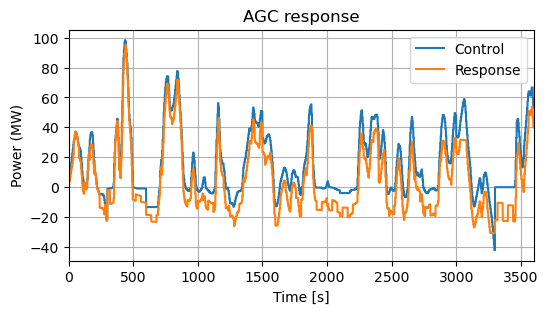

In [12]:
sse.plot_agc()

In [13]:
sse.data

{'ts': 18.999722222225575,
 'Pi': 53.14592138652146,
 'Pr': 75.42419920007943,
 'Prc': 39.857356192741136,
 'Per': 22.27827781355797,
 'ne': 17309,
 'nec': 12527,
 'Ptc': -2.3590257977155087,
 'Pcc': -28.7256084319018,
 'Pdc': 26.366582634186294,
 'Pt': -3.6712495486892243}

In [14]:
col = ['u', 'lc', 'c', 'c0', 'soc', 'soc0', 'socd', 'c', 'sx', 'agc', 'na0', 'na', 'nam']
sse.ev[((sse.ev['c']!=0)) & (sse.ev['lc']==1)][col]
# sse.ev[(sse.ev['c0']1)][col]

# self = sse
# self.ev['agc'] = self.ev['agc'] * (1 - self.ev['lc'])
# self.ev[((sse.ev['c']!=0)) & (sse.ev['lc']==1)][col]

,u,lc,c,c0,soc,soc0,socd,c,sx,agc,na0,na,nam
12566,1,1,-1,2,0.995,0.886295,0.803512,-1,19,1,1956,3320,3320


In [15]:
sse.ev[(sse.ev['lc']==1)]

,u,u0,soc,bd,c,c2,c0,sx,dP,xl,...,lc,agc,mod,na,nam,soc0,na0,pv,pu,p
4,1,1,0.995000,1,0,1,1,19,0.0,"[[], [], []]",...,1,0,0,2837,2837,1.000000,2837,-0.0,0.0,1.0
5,1,1,0.941300,0,0,1,1,18,0.0,"[[], [], []]",...,1,0,0,2975,2975,0.941300,2975,-0.0,0.0,1.0
8,1,1,0.980665,0,0,1,1,19,0.0,"[[], [], []]",...,1,0,0,3947,3947,0.980665,3947,-0.0,0.0,1.0
13,1,1,0.973578,0,0,1,1,19,0.0,"[[], [], []]",...,1,0,0,3793,3793,0.950188,3485,-0.0,0.0,1.0
22,1,1,0.937920,0,0,1,1,18,0.0,"[[], [], []]",...,1,0,0,3130,3130,0.909820,2852,-0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17357,1,1,0.912028,0,0,1,1,18,0.0,"[[], [], []]",...,1,0,0,3078,3078,0.909557,3036,-0.0,0.0,1.0
17363,1,1,0.959344,0,0,1,1,19,0.0,"[[], [], []]",...,1,0,0,3706,3706,0.959344,3706,-0.0,0.0,1.0
17366,1,1,0.983490,0,0,1,1,19,0.0,"[[], [], []]",...,1,0,0,3939,3939,0.955768,3585,-0.0,0.0,1.0
17367,1,1,0.971583,0,0,1,1,19,0.0,"[[], [], []]",...,1,0,0,3121,3121,0.971583,3121,-0.0,0.0,1.0


In [16]:
evc

NameError: name 'evc' is not defined

In [ ]:
sse.plot()

In [ ]:
sse.plot_agc()

In [ ]:
sse.data

In [ ]:
# ssa.TDS.save_output()

In [ ]:
%run -i 'cosim_plot.py'

In [ ]:
sse.ev.columns

In [ ]:
self = sse
scaler = 1

# predicted na; scale with running time
pna = (self.ev['na'] - self.ev['na0']) * (self.ev['tf'] -
                                          self.tsd['ts'].iloc[0]) / (self.data['ts'] - self.tsd['ts'].iloc[0])
if self.config['ict']:
    pna[pna > self.ev['nam']] = self.ev['nam'][pna > self.ev['nam']]  # upper cap
pna[pna < 0] = 0  # lower cap TODO: is this necessary?
# adjust by charging efficiency; unit: hour
self.ev['ict'] = pna / self.ev['nc'] * self.config['t_agc'] / 3600
self.ev['ict'] *= scaler  # scale
self.ev['ict'].hist(bins=30)
self.ev['tt'].hist(bins=30)

In [ ]:
sse.ev.soc0

In [ ]:
sse.ict()
sse.ev['ict'].hist(bins=30)
sse.ev['tt'].hist(bins=30)

In [ ]:
sse.ict2()
sse.ev['ict'].hist(bins=30)
sse.ev['tt'].hist(bins=30)

In [ ]:
# plot the AGC signal

figa, axa = plt.subplots()
axa.plot(range(0, 3600, 4),
         ssa.config.mva * agc_out.values[10:, 1:].reshape(900, 1),
         color='tab:orange')
axa.plot(range(0, 3600, 4),
         ssa.config.mva * agc_in.values[10:, 1:].reshape(900, 1),
         color='tab:red')
ssa.TDS.plt.plot(ssa.TGOV1N.paux,
                 linestyles=['-'],
                 yheader=yheader,
                 ytimes=ssa.config.mva,
                 legend=False, show=False,
                 title=r'AGC power', ylabel='MW',
                 fig=figa, ax=axa, style='default',
                 left=1000, right=2000)
axa.legend(['AGC_out-EV', 'AGC_in-EV'])

In [ ]:
# sim_name = '_F_ict'
# cosim_out.to_csv('cosim_18' + sim_name + '_out.csv', index=False)
# sse_out.to_csv('cosim_18' + sim_name + '_sse.csv', index=False)
# bu_df.to_csv('cosim_18' + sim_name + '_bu.csv', index=False)
# bd_df.to_csv('cosim_18' + sim_name + '_bd.csv', index=False)
# pg_df.to_csv('cosim_18' + sim_name + '_pg.csv', index=False)
# agc_mile.to_csv('cosim_18' + sim_name + '_agcm.csv', index=False)
# sfr_res.to_csv('cosim_18' + sim_name + '_sfr.csv', index=False)
# ev_agc.to_csv('cosim_18' + sim_name + '_evagc.csv', index=False)
# ev_soc.iloc[0:800].to_csv('cosim_18' + sim_name + '_evsoc1.csv', index=False)
# ev_soc.iloc[800:].to_csv('cosim_18' + sim_name + '_evsoc2.csv', index=False)
# sse.ev.to_csv('cosim_18' + sim_name + '_evdata.csv', index=False)

# import csv
# new_path = open('cosim_18' + sim_name + '_rted.csv', 'w')
# z = csv.writer(new_path)
# for new_k, new_v in rted_res.items():
#     z.writerow([new_k, new_v])
# new_path.close()

In [ ]:
# split -l 4 index.txt split_file
# !ls -lh

plt.style.use('science')
%run -i 'cosim_plotev.py'